## Toolbox

In [2]:
%matplotlib notebook
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import time, os, io, clipboard
from PIL import ImageGrab
from IPython.display import Image, display
from scipy import stats
import scipy.constants as const
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

pd.set_option("display.precision", 3)
plt.close('all')

import sys 
sys.path.append('..')
# from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\ProgramData\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


### Cheatsheets

[Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#links)

[DataColor](https://learnui.design/tools/data-color-picker.html)

[LaTeX math](https://kapeli.com/cheat_sheets/LaTeX_Math_Symbols.docset/Contents/Resources/Documents/index)

[Python Beginner](file:///C:/Users/racco/Downloads/papers/beginners_python_cheat_sheet_pcc_all.pdf)

[Python Matplotlib](file:///C:/Users/racco/Downloads/papers/Python_Matplotlib_Cheat_Sheet.pdf)

[Python Numpy](file:///C:/Users/racco/Downloads/papers/Numpy_Python_Cheat_Sheet.pdf)

[Python Pandas](file:///C:/Users/racco/Downloads/papers/Python_Pandas_Cheat_Sheet_2.pdf)

[Python Scipy](file:///C:/Users/racco/Downloads/papers/Python_SciPy_Cheat_Sheet_Linear_Algebra.pdf)


### Data processing scripts

In [4]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [5]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
    return ({'title':title, 'alldata':alldata})

def DFMbyid(run_id: int):
    data = databyid(run_id)
    DTF = {data['alldata'][0][0]['name'] : pd.Series(data['alldata'][0][0]['data'], 
                                                     index = np.arange(len(data['alldata'][0][0]['data']))), 
           data['alldata'][0][1]['name'] : pd.Series(data['alldata'][0][1]['data'], 
                                                     index = np.arange(len(data['alldata'][0][0]['data'])))} 
    DTF = pd.DataFrame(DTF)
    return DTF

def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

### Plotting

#### Update and flush inline outputs

In [5]:
import sys, time

N = 100
for j in range(int(N/30)):
    for i in range(N):
       time.sleep(0.05)
       sys.stdout.flush()
#        sys.stdout.write("\r{:.1f} %".format(i/N*100))
       print("{:.1f} %".format(i/N*100), end="\r")

#### Tilted washboard potential

<IPython.core.display.Javascript object>


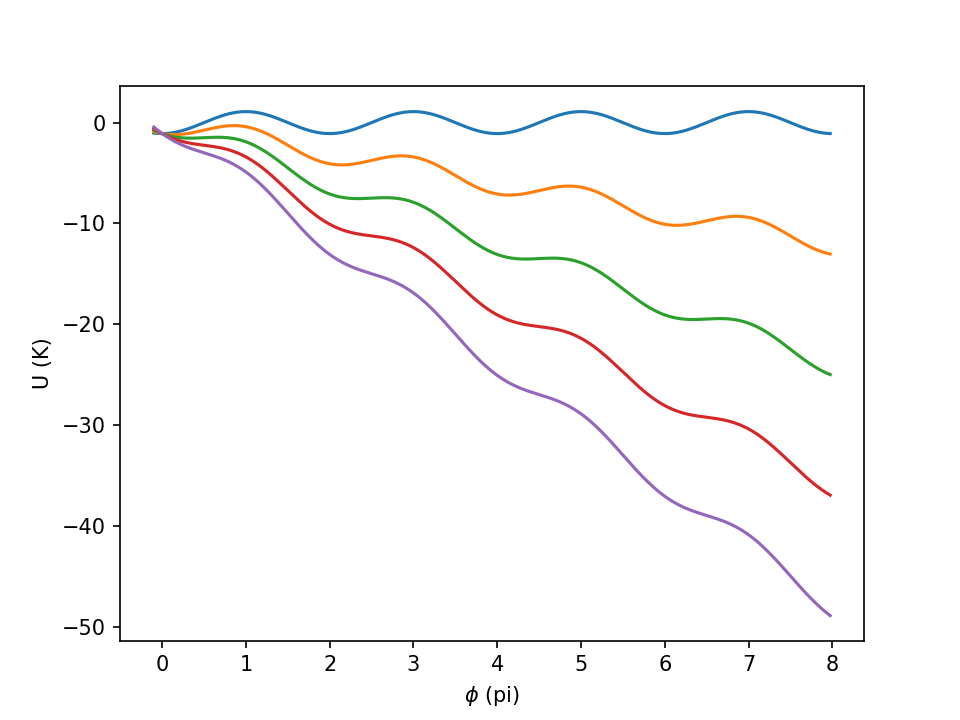

In [42]:
def tiltedWashboardU(EJKBT, IbiasArr, ax):
   phi = np.arange(-0.1*np.pi, 8*np.pi, 0.025*np.pi)
   UArr=[]
   for Ibias in IbiasArr:
       U = -EJKBT*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *Ibias *phi
       UArr.append(U)

#    ax.set_title('Tilted washboard', fontsize=16, fontweight='bold')
   ax.set_xlabel('$\phi$ (pi)')
   ax.set_ylabel('U (K)')

   i = 0   
   for i,U in enumerate(UArr):
       ax.plot(phi/np.pi, U/const.k,label = 'I$_b$ =' + format(si_format(IbiasArr[i])) + 'A')
#    ax.text(0.82, 0.94, 'E$_J$ =' + format(si_format(EJKBT)) + 'K\n', verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)

plt.close('all')
f,ax=plt.subplots()
tiltedWashboardU(1089.5586E-3, np.arange(0E-9, 100E-9, 20E-9), ax)
plt.show()

#### DC quick viewing

<IPython.core.display.Javascript object>


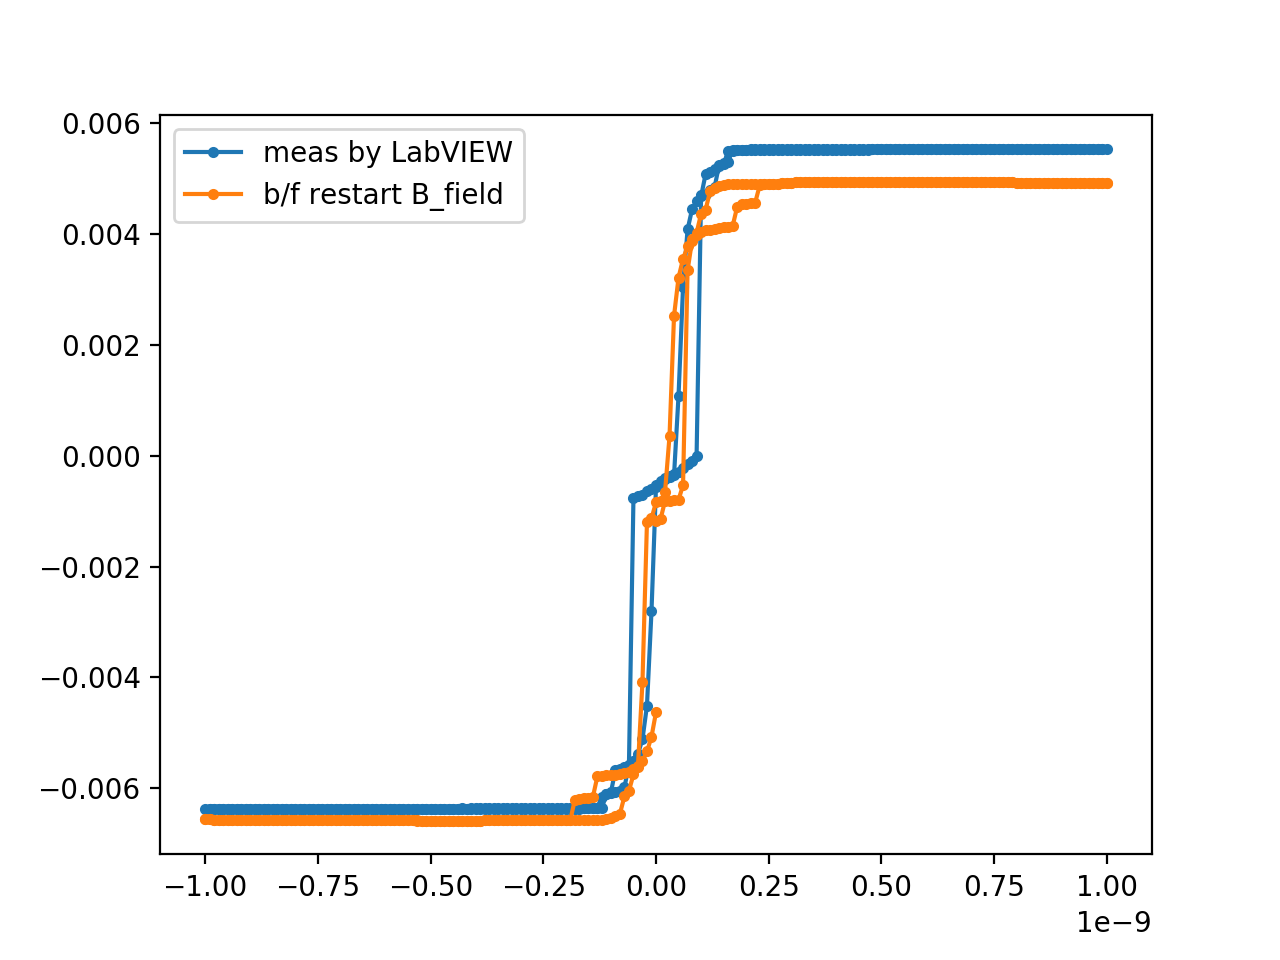

In [9]:
filepath1 = r'C:\Users\racco\Documents\QCoDes\measDC\experimental log toolbox'
filepath2 = r'C:\Users\racco\Documents\QCoDes\ExdData'

f,ax=plt.subplots()
dataLV = filetoDFM(filepath1 + r'\191104-70N3_IVc-115218.txt')
ax.plot(dataLV[0]['IS'],dataLV[0]['V1'], '.', ls='-',label = 'meas by LabVIEW')

qc.config["core"]["db_location"] = filepath2 + r'\Experiments_{}.db'.format('70B1N5')   
initialise_database()

label = ['b/f restart B_field']
for i,v in enumerate([1]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    ax.plot(Is, Vs, '.', ls='-', label = '{}'.format(label[i]))

ax.legend()

#### Bar plots

<IPython.core.display.Javascript object>


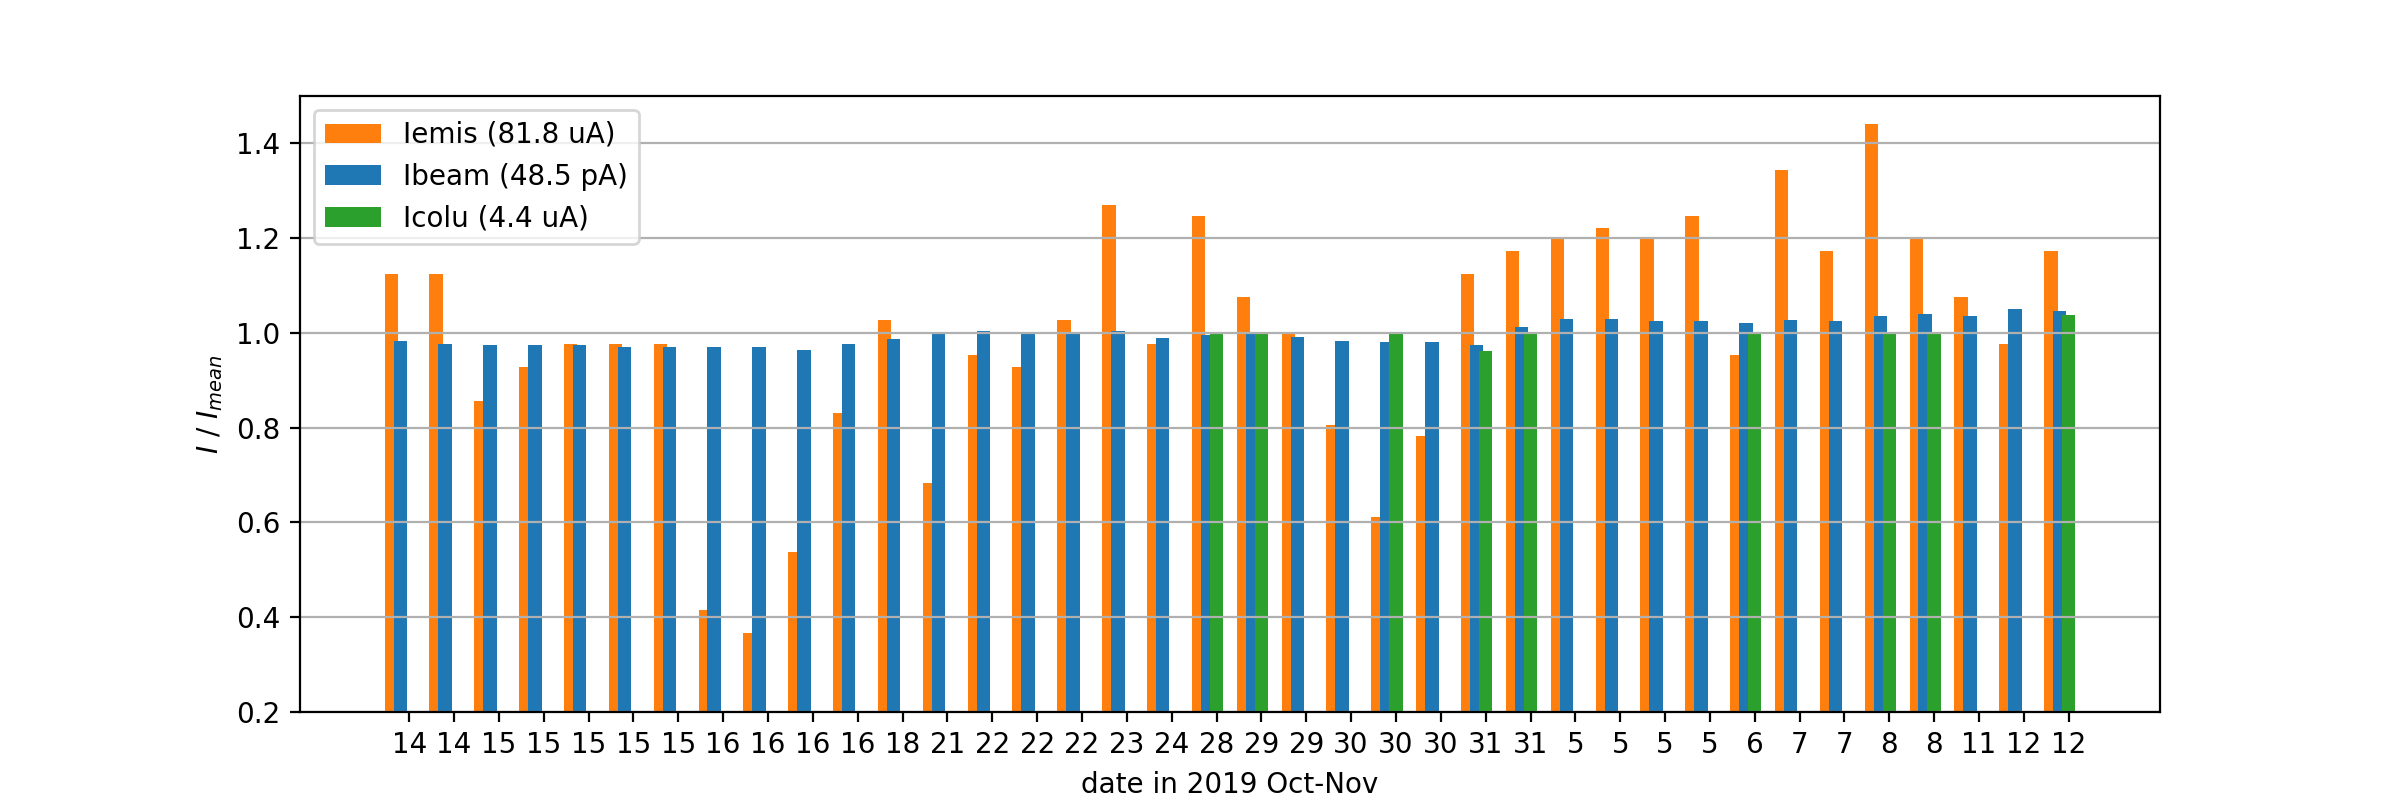

In [10]:
def lstmean (lst):
    for i,v in enumerate (lst):
        if v == 0:
            lst[i] = np.nan
    return np.nanmean(lst)

date = [ 14   , 14   , 15   , 15   , 15   , 15   , 15   , 16   , 16   , 16   , 16   , 18   , 21   , 22   , 22   , 22   , 23   , 24   , 28   , 29   , 29   , 30   , 30   , 30   , 31   , 31   , 5    , 5    , 5    , 5    , 6    , 7    , 7    , 8    , 8    , 11   , 12   , 12    ]
Iemi = [ 92   , 92   , 70   , 76   , 80   , 80   , 80   , 34   , 30   , 44   , 68   , 84   , 56   , 78   , 76   , 84   , 104  , 80   , 102  , 88   , 82   , 66   , 50   , 64   , 92   , 96   , 98   , 100  , 98   , 102  , 78   , 110  , 96   , 118  , 98   , 88   , 80   , 96    ]
Ibe1 = [ 47.6 , 47.3 , 47.2 , 47.2 , 47.2 , 47.0 , 47.0 , 47.0 , 47.0 , 46.7 , 47.3 , 47.8 , 48.4 , 48.7 , 48.5 , 48.5 , 48.7 , 47.9 , 48.2 , 48.5 , 48   , 47.6 , 47.5 , 47.5 , 47.2 , 49.1 , 49.9 , 49.9 , 49.7 , 49.7 , 49.5 , 49.8 , 49.7 , 50.2 , 50.4 , 50.2 , 50.9 , 50.7  ]
Icol = [ 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    ,  0   , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 4.354, 4.354, 0    , 0    , 4.354, 0    , 4.187, 4.354, 0    , 0    , 0    , 0    , 4.354, 0    , 0    , 4.354, 4.354, 0    , 0    , 4.522 ]
x = np.linspace(1,len(date),len(date))

Iemimean = lstmean(Iemi)
Ibe1mean = lstmean(Ibe1)
Icolmean = lstmean(Icol)

f,ax = plt.subplots (1,1,figsize=(12,4))
ax.bar(x    , Iemi/Iemimean, width=0.3, tick_label = date, 
       label = 'Iemis ({}uA)'.format(si_format(Iemimean)), color = 'C1')
ax.bar(x+0.2, Ibe1/Ibe1mean, width=0.3, tick_label = date, 
       label = 'Ibeam ({}pA)'.format(si_format(Ibe1mean)), color = 'C0')
ax.bar(x+0.4, Icol/Icolmean, width=0.3, tick_label = date, 
       label = 'Icolu ({}uA)'.format(si_format(Icolmean)), color = 'C2')
# plt.xlim(0,20)
ax.set_ylim(0.2,1.5)
ax.set_xlabel("date in 2019 Oct-Nov")
ax.set_ylabel("$I$ / $I_{mean}$")
ax.legend(loc=2)
ax.grid(True, 'both', axis = 'y')

#### Pie chart

<IPython.core.display.Javascript object>


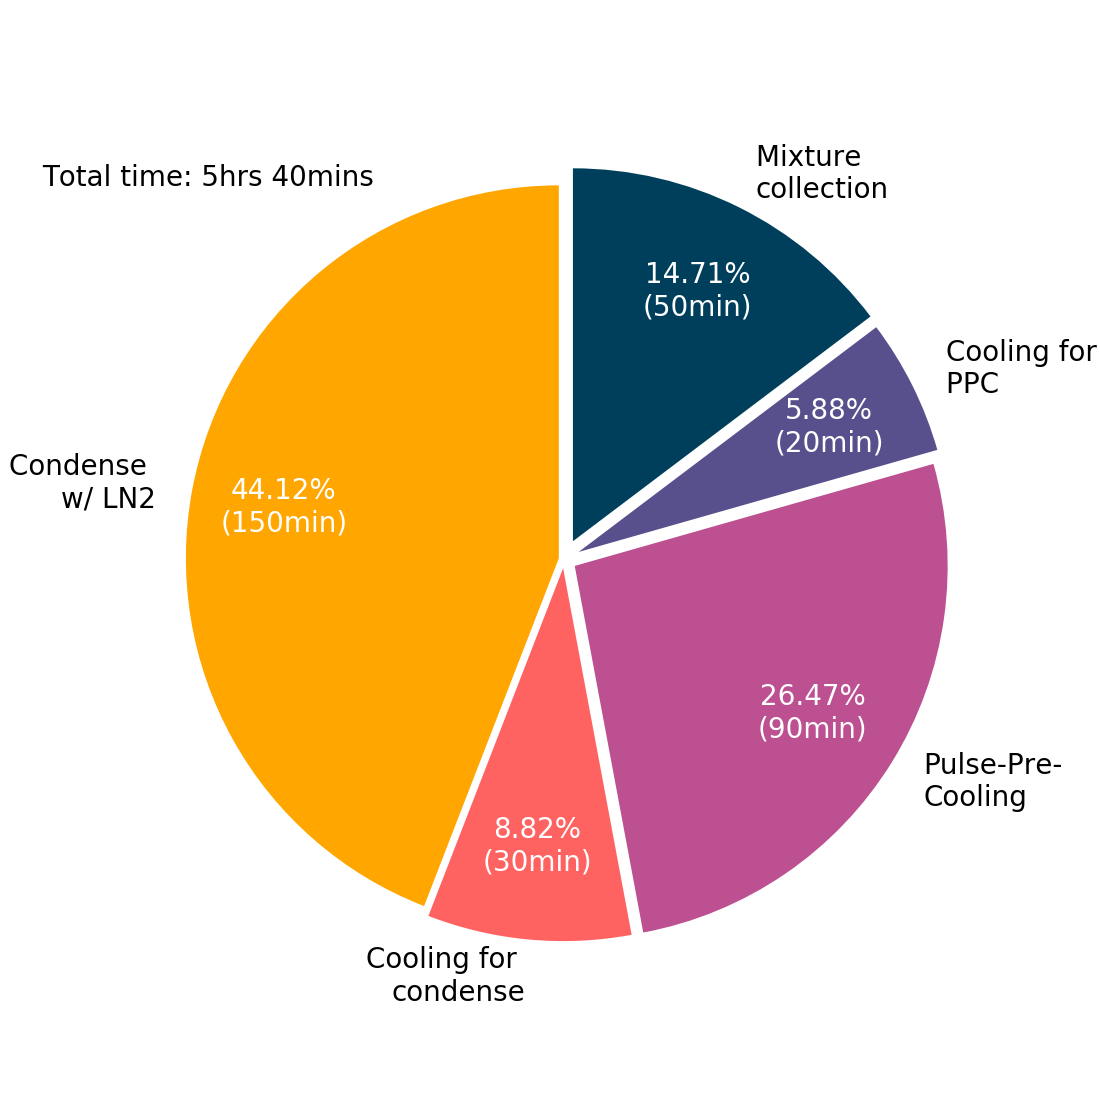

In [26]:
def min2hr(time='1hr20min'):
    hr, minu = time.split('hr')[0], time.split('hr')[1][:-3]
    return int(hr)*60+int(minu)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d}min)'.format(p=pct,v=val)
    return my_autopct


labels = ['Mixture \ncollection', 
          'Cooling for \nPPC ', 
          'Pulse-Pre-\nCooling',
          'Cooling for \ncondense',
          'Condense \nw/ LN2']

sizes =  [min2hr('0hr50min'), 
          min2hr('0hr20min'), 
          min2hr('1hr30min'), 
          min2hr('0hr30min'), 
          min2hr('2hr30min')]

colors = [[0    , 0.247, 0.361], 
          [0.345, 0.314, 0.553], 
          [0.737, 0.314, 0.565], 
          [1    , 0.388, 0.38 ],
          [1    , 0.651, 0    ],]

expldlst = np.array([])
for i in range(5):
    expldlst = np.append(expldlst, (1.35-i*0.25)/25)
explode = expldlst

_, _, autotexts = plt.pie(sizes, explode = explode, labels = labels, colors = colors, shadow = False,
                          autopct = make_autopct(sizes), startangle = 90, counterclock = False,
                          pctdistance=0.75, labeldistance=1.1)
for autotext in autotexts:
    autotext.set_color('white')

# '%1.1f%%'
plt.axis('equal')
plt.text(-1.4,1,'Total time: {}hrs {}mins'.format(int(np.floor(sum(sizes)/60)), 
                                                  np.remainder(sum(sizes),60)))
fig = plt.gcf()
fig.set_size_inches(5.5,5.5)
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)
plt.show()

### Pandas list and dictionary

#### Usage of merge

In [11]:
sku = [  122,  123,  113,  122,  123,  122,  301]
loc = [   61,   61,   62,   62,   62,   63,   63]
flag= [ True, True, True, True,False,False, True]
lst1= pd.DataFrame(data = list(zip(sku,loc,flag)), columns = ['sku', 'loc', 'flag'])
print(lst1,'\n')
sku = [  113,  122,  123,  301]
dep = [  'a',  'b',  'b',  'c']
lst2= pd.DataFrame(data = list(zip(sku,dep)), columns = ['sku', 'dep'])
print(lst2)

lst2.merge(lst1, on = 'sku', how = 'left')

   sku  loc   flag
0  122   61   True
1  123   61   True
2  113   62   True
3  122   62   True
4  123   62  False
5  122   63  False
6  301   63   True 

   sku dep
0  113   a
1  122   b
2  123   b
3  301   c


sku dep  loc   flag
0  113   a   62   True
1  122   b   61   True
2  122   b   62   True
3  122   b   63  False
4  123   b   61   True
5  123   b   62  False
6  301   c   63   True

#### JJ calc

In [19]:
def JJpar(RN=1e3, sizeX=0.2e-6, sizeY=0.2e-6, metalTHK=250e-10, Tc=1.34, Nser = 16, Npar = 2):
   
    JJarea = sizeX*sizeY + (sizeX+sizeY)*metalTHK
    Rs_JJ = RN * JJarea /Nser *Npar
    RN_JJ = RN /Nser *Npar
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /RN_JJ
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50e-15 *1e12 *JJarea
    EC_JJ = const.e*const.e /2 /C_JJ
    C0 = ParplateCap(area= 56e-12 , dielecTHK=10e-9, epsilon = 9.34*const.epsilon_0)
    EC0 = const.e*const.e /2 /C0
   
    freqPlasma = np.sqrt(2 *const.e *IAB *2*const.pi /const.h /C_JJ) /2/const.pi
    Q = freqPlasma*2*np.pi *RN *C_JJ
    EJoEc = EJ_JJ/EC_JJ
    
    key =  [ 'RN_JJ',    'Rs_JJ', 'I_AB',           'EJ',  'C_JJQP',          'EC',   '$\omega_p$', 'Q', 'beta', 'EJ/EC']
    unit=  [  'kohm','kohm*um^2',   'nA',            'K',      'fF',           'K',          'GHz',  '',     '',      '']
    lst = [[ RN_JJ/1e3 , Rs_JJ*1e9 ,IAB*1e9, EJ_JJ/const.k , C_JJ*1e15, EC_JJ/const.k, freqPlasma/1e9,  Q ,   Q*Q ,  EJoEc ]]
    JJparDFM = pd.DataFrame( data = list(zip(*lst)),      index = key ).transpose()
    JJparUNI = pd.DataFrame( data = dict(zip(key, unit)), index = [0] )

    return JJparDFM,JJparUNI


In [32]:
def toJJplst(srclst):

    lst = []
    for i in range(0,len(srclst['Device'])):
        JJw = np.sqrt(srclst.iloc[i]['J size'])
        JJpd = JJpar(  RN = srclst.iloc[i]['RN/al'], sizeX=JJw, sizeY=JJw, metalTHK = 250E-10, Tc=1.34, 
                     Nser = srclst.iloc[i]['#ser'] , Npar = srclst.iloc[i]['#par'])[0]

        JJpd = np.flip(JJpd.values[0]).tolist()
        JJpd += [srclst.iloc[i]['Device']]
        JJpd = np.flip(np.asarray(JJpd))
        lst.append(JJpd)

    key =    [ 'Device' ,  'RN_JJ', 'Rs/JJ',   'I_AB' , 'EJ' , 'C_JJQP' , 'EC', '$\omega_p$', 'Q',     'beta' , 'EJ/EC']
    unit=    ['       ' ,   'kohm',  'kohm',     'nA' ,  'K' ,     'fF' ,  'K',        'GHz',  '',         '' ,      '']
    JJplst =   pd.DataFrame(  data  = list(zip(*lst)), 
                            columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                              index = key ).transpose()
    JJpuni =   dict(zip(key, unit))
    
    return [JJplst,JJpuni]

def IABT(gapK = 2, RN = 1e3, T = np.arange(0,2,0.01)):
    return np.pi/2/const.e *gapK*const.k *np.tanh(gapK/2/T) /RN

def QQstar(srclst = Q1Dlst):
#     JJplst = toJJplst(srclst = srclst)[0]
    JJplst = toJJplst(srclst)[0].transpose().drop('Device').transpose().astype(float)
    srclst = srclst.transpose().drop('Device').drop('Mat.').drop('dsgn').transpose().astype(float)
    
    Q      = JJplst['Q']

    lst = [0]*len(srclst['R0ZF'])
    for i,v in enumerate(srclst['R0ZF']):
            if v < 1000:
                lst[i] = 0
            else:
                lst[i] = v
    R0 = lst
    freqPlasma = JJplst['$\omega_p$']*1e9 /2/np.pi
    C_JJ = JJplst['C_JJQP']*1e-15

    Q_star = freqPlasma * R0/srclst['#ser']*srclst['#par'] *C_JJ 
    
    return [Q,Q_star]

In [40]:
devlst = {'D079N1': JJpar(RN= 290e3, sizeX=0.177e-6, sizeY=0.177e-6, metalTHK=250e-10, Tc=1.34, Nser = 1, Npar = 2),
          'D079N3': JJpar(RN= 520e3, sizeX=0.784e-6, sizeY=0.263e-6, metalTHK=250e-10, Tc=1.34, Nser =16, Npar = 2),
          'D079N5': JJpar(RN=  27e3, sizeX=2.250e-6, sizeY=1.740e-6, metalTHK=250e-10, Tc=1.34, Nser =16, Npar = 2),
          'D079N6': JJpar(RN=2.15e3, sizeX=2.210e-6, sizeY=1.720e-6, metalTHK=250e-10, Tc=1.34, Nser = 1, Npar = 2),
          'D079N0': JJpar(RN=24.3e3, sizeX=2.210e-6, sizeY=1.670e-6, metalTHK=250e-10, Tc=1.34, Nser =16, Npar = 2)} 

D079 = devlst['D079N1'][0]
print(devlst['D079N1'][1])

idlst = []
for dev in devlst:
    D079 = D079.merge(devlst[dev][0], 'outer')
    idlst.append(dev)
D079.insert(loc = 0, column = 'dev id', value = idlst)
D079

  RN_JJ      Rs_JJ I_AB EJ C_JJQP EC $\omega_p$ Q beta EJ/EC
0  kohm  kohm*um^2   nA  K     fF  K        GHz             


dev id    RN_JJ   Rs_JJ     I_AB     EJ   C_JJQP     EC  $\omega_p$  \
0  D079N1  580.000  23.304    0.552  0.013    2.009  0.463       4.597   
1  D079N3   65.000  15.104    4.922  0.117   11.618  0.080       5.710   
2  D079N5    3.375  13.550   94.803  2.260  200.738  0.005       6.029   
3  D079N6    4.300  16.768   74.409  1.774  194.973  0.005       5.420   
4  D079N0    3.038  11.505  105.337  2.511  189.385  0.005       6.543   

         Q       beta    EJ/EC  
0   16.829    283.203    0.028  
1  216.770  46989.196    1.466  
2  205.315  42154.359  487.973  
3   14.275    203.771  372.003  
4  189.191  35793.327  511.529

#### <span class="mark">Q1D list</span>

In [485]:
# key =    [ 'Device' ,    'T8',  'EJ/JJ',   'ECJ',  'ISW' ,     'R0ZF' ,     'R0FF' , '#ser', '#par' ]
# unit=    ['       ' ,    'K' ,     'K' ,     'K',    'A' , '$\Omega$' , '$\Omega$' ,   'ea',   'ea' ]
# lst =   [['D55BCN7' ,  0.030 ,   0.465 ,  0.214 ,      0 ,          0 ,          0 ,    20 ,      2 ],
#          ['       ' ,  0.300 ,   0.465 ,  0.214 ,      0 ,          0 ,          0 ,    16 ,      2 ],
#          ['D53N2  ' ,  0.030 ,   0.465 ,  8.131 ,      0 ,          0 ,          0 ,    20 ,      2 ],
#          ['D55B1N9' ,  0.030 ,   0.465 ,  0.660 ,      0 ,          0 ,          0 ,    20 ,      2 ],
#          ['D59B6N3' ,  0.030 ,   0.465 ,  0.905 ,      0 ,          0 ,          0 ,    20 ,      2 ],
#          ['D59B0N1' ,  0.030 ,   0.465 ,  0.857 ,      0 ,          0 ,          0 ,     2 ,      2 ],
#          ['D59BBN2' ,  0.030 ,   0.465 ,  0.044 ,      0 ,          0 ,          0 ,    20 ,      2 ],
#          ['D62B3N2' ,  0.030 ,   0.465 ,  0.358 ,      0 ,          0 ,          0 ,    20 ,      2 ],
#          ['D60B2N6' ,  0.030 ,   0.465 ,  0.408 ,      0 ,          0 ,          0 ,    20 ,      2 ],
#          ['D60B2N2' ,  0.030 ,   0.465 ,  0.128 ,      0 ,          0 ,          0 ,     4 ,      2 ],
#          ['D63BAN6' ,  0.030 ,   0.465 ,  0.238 ,      0 ,          0 ,          0 ,    30 ,      2 ],
#          ['       ' , np.nan ,   0.465 ,  0.238 ,      0 ,          0 ,          0 ,    30 ,      2 ],
#          ['D070   ' ,  0.030 ,   0.038 ,  0.763 ,      0 ,          0 ,          0 ,    16 ,      2 ]]
    
# Q1Dlst =   pd.DataFrame(  data  = list(zip(*lst)), 
#                         columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
#                           index = key ).transpose()
# Q1Duni =   dict(zip(key, unit))

In [114]:
#D55BCN7, 66B8N5_b

In [33]:
key =    [ 'Device' ,  'Vo/al', 'RN/al',   'ISW' , 'R0ZF' , 'R0FF' , '#ser', '#par', 'Mat.',  'BT' , 'dsgn', 'J size']
unit=    ['       ' ,      'V',   'ohm',     'A' ,  'ohm' ,  'ohm' ,   'ea',   'ea',     '',   'K' ,     '',    'm^2']
lst =   [['53N2'    , 1.610e-3, 9.376e3,    9e-8 ,  np.nan,  np.nan,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.53e-10, 1.006e6, 6.668e8,    20 ,      2,   'Al', 0.027 ,  'Fin', 0.04e-12],
         ['59B6N3'  , 1.875e-3, 8.438e4, 1.98e-9 , 7.883e4, 2.591e7,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['59B0N1'  , 2.178e-4, 8.756e3,  3.9e-9 , 1.314e3, 1.650e9,     2 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,  3.2e-13, 2.367e8, 9.032e8,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,  2.1e-11, 4.319e6, 8.931e8,    20 ,      2,   'Al', 0.045 ,  'Fin', 0.04e-12],
         ['60B2N6'  , 3.345e-3, 6.647e5,  1.2e-12, 2.292e7, 9.587e8,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['60B2N2'  , 3.186e-4, 1.199e5, 2.68e-12, 2.909e7, 9.209e8,     4 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['63BAN6_b', 5.010e-3, 5.942e5,  2.0e-11, 7.715e6, 9.350e8,    30 ,      2,   'Al', 0.030 ,  'x_s', 0.04e-12],
         ['63BAN6_a', 3.070e-3, 5.859e5,  2.2e-11, 2.650e5, 1.380e7,    30 ,      2,   'Al', 0.030 ,  'x_s',    4e-12],
         ['66B8N5_b', 1.720e-3, 6.613e4,  5.4e-9 , 8.510e2, 1.463e8,    30 ,      2,   'Al', 0.030 ,  'x_s', 0.04e-12],
         ['70B1N0'  ,   np.nan, 1.682e5,  1.6e-10, 2.373e4,  np.nan,    15 ,      2,   'Al', 0.030 ,  'x_L',    4e-12],
         ['79N6'    , 1.645e-4, 1.458e3, 1.37e-7 ,  2.20e0,  np.nan,     1 ,      2,   'Al', 0.030 ,  'x_L', 3.74e-12],
         ['79N5'    , 2.021e-3, 2.335e4,  5.6e-9 , -3.07e2,  np.nan,    15 ,      2,   'Al', 0.030 ,  'x_L', 3.74e-12],
#          ['74N4'    , 1.972e-3, 1.350e4,  9.0e-8 ,  1.00e0,  np.nan,     9 ,      2,   'Al', 0.030 ,  'x_L', 2.25e-12],
         ['74N4'    , 1.972e-3, 1.350e4,  9.0e-9 ,  1.00e0,  np.nan,     9 ,      2,   'Al', 0.030 ,  'x_L', 2.25e-12],
         ['78N0'    , 1.931e-3, 2.542e5, 3.71e-11,  1.00e4,  np.nan,    15 ,      2,   'Al', 0.030 ,  'x_L',    4e-12],
         ['78N5'    , 9.685e-5, 1.670e4,  8.0e-10,  1.00e5,  np.nan,     1 ,      2,   'Al', 0.030 ,  'x_L',    4e-12]]
         
Q1Dlst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
Q1Duni =   dict(zip(key, unit))

Q1Dlst = Q1Dlst.replace(to_replace = Q1Dlst[Q1Dlst['Device']=='55B1N9']['R0ZF'][0], value=260367)
Q1Dlst = Q1Dlst.replace(to_replace = Q1Dlst[Q1Dlst['Device']=='55B1N9']['BT'][0], value=0.040)

JJplst = toJJplst(srclst = Q1Dlst)[0]

Q1D = Q1Dlst.transpose().drop('Device').drop('Mat.').drop('dsgn').transpose().astype(float)
JJp = toJJplst(Q1Dlst)[0].transpose().drop('Device').transpose().astype(float)

In [37]:
key =    [ 'Device' ,  'Vo/al', 'RN/al',   'ISW' , 'R0ZF' , 'R0FF' , '#ser', '#par', 'Mat.',  'T8' , 'dsgn', 'J size']
unit=    ['       ' ,      'V',   'ohm',     'A' ,  'ohm' ,  'ohm' ,   'ea',   'ea',     '',   'K' ,     '',    'm^2']
lst =   [['55B1N9'  , 1.675e-3, 1.152e5, 1.95e-10,  260367, 1.204e8,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.92e-10,  262869, 1.393e8,    20 ,      2,   'Al', 0.040 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.94e-10,  254764, 1.262e8,    20 ,      2,   'Al', 0.050 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.87e-10,  283480, 1.202e8,    20 ,      2,   'Al', 0.075 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.72e-10,  297238, 1.388e8,    20 ,      2,   'Al', 0.100 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.67e-10,  337839, 1.190e8,    20 ,      2,   'Al', 0.125 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.58e-10,  366584, 1.275e8,    20 ,      2,   'Al', 0.150 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5,  1.4e-10,  492142, 1.360e8,    20 ,      2,   'Al', 0.200 ,  'x_s', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.23e-10,  536512, 1.275e8,    20 ,      2,   'Al', 0.250 ,  'x_s', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.49e-10,  488088, 2.053e7,    20 ,      2,   'Al', 0.300 ,  'x_s', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 2.12e-10,  384047, 6.133e6,    20 ,      2,   'Al', 0.350 ,  'x_L', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5,  3.5e-10,  312522, 2.806e6,    20 ,      2,   'Al', 0.400 ,  'x_L', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5,  5.5e-10,  195413, 1.465e6,    20 ,      2,   'Al', 0.450 ,  'x_L', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5,    8e-10,  136093,  8935e8,    20 ,      2,   'Al', 0.500 ,  'x_L', 0.04e-12]]
Q1D55B1N9lst =   pd.DataFrame(  data  = list(zip(*lst)), 
                              columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                                index = key ).transpose()

In [38]:
lst =   [['62B3N2'  , 2.495e-3, 9.935e5, 1.83e-11 , 4.338e6, 8.352e9,    20 ,      2,   'Al', 0.045 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,  1.7e-11 , 4.277e6, 7.050e9,    20 ,      2,   'Al', 0.050 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5, 1.63e-11 , 5.131e6, 7.053e9,    20 ,      2,   'Al', 0.075 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5, 1.68e-11 , 4.919e6, 6.846e9,    20 ,      2,   'Al', 0.100 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5, 1.63e-11 , 5.528e6, 7.204e9,    20 ,      2,   'Al', 0.125 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,  1.6e-11 , 5.949e6, 6.724e9,    20 ,      2,   'Al', 0.150 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,  1.6e-11 , 7.106e6, 5.285e9,    20 ,      2,   'Al', 0.200 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5, 1.68e-11 , 7.144e6, 1.579e8,    20 ,      2,   'Al', 0.250 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5, 1.95e-11 , 6.004e6, 4.281e7,    20 ,      2,   'Al', 0.300 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,   np.nan , 4.212e6, 1.725e7,    20 ,      2,   'Al', 0.350 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,   np.nan , 2.870e6, 7.684e6,    20 ,      2,   'Al', 0.400 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,   np.nan , 2.266e6, 4.134e6,    20 ,      2,   'Al', 0.450 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,   np.nan , 1.639e6, 2.497e6,    20 ,      2,   'Al', 0.500 ,  'Fin', 0.04e-12]]
Q1D62B3N2lst =   pd.DataFrame(  data  = list(zip(*lst)), 
                                columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                                index = key ).transpose()

In [39]:
lst =   [['59BBN2'  , 1.385e-3, 1.754e6,   np.nan , 3.343e8, 5.643e9,    20 ,      2,   'Al', 0.070 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,   np.nan , 2.952e8, 5.255e9,    20 ,      2,   'Al', 0.100 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,   np.nan , 2.644e8, 5.143e9,    20 ,      2,   'Al', 0.125 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,   np.nan , 2.651e8, 6.282e9,    20 ,      2,   'Al', 0.150 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,    1e-13 , 2.096e8, 2.800e9,    20 ,      2,   'Al', 0.200 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,   np.nan , 2.233e8, 5.139e8,    20 ,      2,   'Al', 0.250 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,    3e-13 , 1.865e8, 3.217e8,    20 ,      2,   'Al', 0.275 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,    7e-13 , 1.356e8, 2.276e8,    20 ,      2,   'Al', 0.300 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,  2.6e-12 ,  np.nan,  np.nan,    20 ,      2,   'Al', 0.350 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,    7e-11 , 2.685e7, 5.693e7,    20 ,      2,   'Al', 0.400 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,  1.2e-10 ,  np.nan,  np.nan,    20 ,      2,   'Al', 0.450 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,   np.nan , 9.835e6, 1.935e7,    20 ,      2,   'Al', 0.500 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,   np.nan , 5.065e6, 1.487e7,    20 ,      2,   'Al', 0.600 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,   np.nan , 2.773e6, 5.690e6,    20 ,      2,   'Al', 0.800 ,  'Fin', 0.04e-12],
         ]
Q1D59BBN2lst =   pd.DataFrame(  data  = list(zip(*lst)), 
                              columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                                index = key ).transpose()

In [35]:
Q1D

Vo/al      RN/al        ISW       R0ZF       R0FF  #ser  #par  \
53N2      1.610e-03  9.376e+03  9.000e-08        NaN        NaN  20.0   2.0   
55B1N9    1.675e-03  1.152e+05  1.530e-10  2.604e+05  6.668e+08  20.0   2.0   
59B6N3    1.875e-03  8.438e+04  1.980e-09  7.883e+04  2.591e+07  20.0   2.0   
59B0N1    2.178e-04  8.756e+03  3.900e-09  1.314e+03  1.650e+09   2.0   2.0   
59BBN2    1.385e-03  1.754e+06  3.200e-13  2.367e+08  9.032e+08  20.0   2.0   
62B3N2    2.495e-03  9.935e+05  2.100e-11  4.319e+06  8.931e+08  20.0   2.0   
60B2N6    3.345e-03  6.647e+05  1.200e-12  2.292e+07  9.587e+08  20.0   2.0   
60B2N2    3.186e-04  1.199e+05  2.680e-12  2.909e+07  9.209e+08   4.0   2.0   
63BAN6_b  5.010e-03  5.942e+05  2.000e-11  7.715e+06  9.350e+08  30.0   2.0   
63BAN6_a  3.070e-03  5.859e+05  2.200e-11  2.650e+05  1.380e+07  30.0   2.0   
66B8N5_b  1.720e-03  6.613e+04  5.400e-09  8.510e+02  1.463e+08  30.0   2.0   
70B1N0          NaN  1.682e+05  1.600e-10  2.373e+04        NaN  15.0   2.0   
79N6      1.645e-04  1.458e+03  1.370e-07  2.200e+00        NaN   1.0   2.0   
79N5      2.021e-03  2.335e+04  5.600e-09 -3.070e+02        NaN  15.0   2.0   
74N4      1.972e-03  1.350e+04  9.000e-09  1.000e+00        NaN   9.0   2.0   
78N0      1.931e-03  2.542e+05  3.710e-11  1.000e+04        NaN  15.0   2.0   
78N5      9.685e-05  1.670e+04  8.000e-10  1.000e+05        NaN   1.0   2.0   

             BT     J size  
53N2      0.030  4.000e-14  
55B1N9    0.040  4.000e-14  
59B6N3    0.030  4.000e-14  
59B0N1    0.030  4.000e-14  
59BBN2    0.030  4.000e-14  
62B3N2    0.045  4.000e-14  
60B2N6    0.030  4.000e-14  
60B2N2    0.030  4.000e-14  
63BAN6_b  0.030  4.000e-14  
63BAN6_a  0.030  4.000e-12  
66B8N5_b  0.030  4.000e-14  
70B1N0    0.030  4.000e-12  
79N6      0.030  3.740e-12  
79N5      0.030  3.740e-12  
74N4      0.030  2.250e-12  
78N0      0.030  4.000e-12  
78N5      0.030  4.000e-12

In [36]:
JJp

RN_JJ    Rs/JJ     I_AB     EJ   C_JJQP     EC  $\omega_p$  \
53N2        0.938    0.047  341.255  8.135    2.500  0.372     102.499   
55B1N9     11.520    0.576   27.774  0.662    2.500  0.372      29.242   
59B6N3      8.438    0.422   37.919  0.904    2.500  0.372      34.167   
59B0N1      8.756    0.438   36.542  0.871    2.500  0.372      33.541   
59BBN2    175.400    8.770    1.824  0.043    2.500  0.372       7.494   
62B3N2     99.350    4.967    3.221  0.077    2.500  0.372       9.957   
60B2N6     66.470    3.323    4.814  0.115    2.500  0.372      12.174   
60B2N2     59.950    2.997    5.337  0.127    2.500  0.372      12.818   
63BAN6_b   39.613    1.981    8.077  0.193    2.500  0.372      15.769   
63BAN6_a   39.060  160.146    8.192  0.195  205.000  0.005       1.754   
66B8N5_b    4.409    0.220   72.575  1.730    2.500  0.372      47.269   
70B1N0     22.427   91.949   14.267  0.340  205.000  0.005       2.314   
79N6        2.916   11.188  109.726  2.616  191.835  0.005       6.635   
79N5        3.113   11.945  102.771  2.450  191.835  0.005       6.421   
74N4        3.000    6.975  106.653  2.542  116.250  0.008       8.403   
78N0       33.893  138.963    9.440  0.225  205.000  0.005       1.883   
78N5       33.400  136.940    9.580  0.228  205.000  0.005       1.896   

                 Q       beta    EJ/EC  
53N2        15.096  2.279e+02   21.876  
55B1N9      52.915  2.800e+03    1.780  
59B6N3      45.287  2.051e+03    2.431  
59B0N1       4.613  2.128e+01    2.342  
59BBN2     206.474  4.263e+04    0.117  
62B3N2     155.394  2.415e+04    0.206  
60B2N6     127.105  1.616e+04    0.309  
60B2N2      24.142  5.828e+02    0.342  
63BAN6_b   147.184  2.166e+04    0.518  
63BAN6_a  1323.471  1.752e+06   43.059  
66B8N5_b    49.102  2.411e+03    4.652  
70B1N0     501.419  2.514e+05   74.995  
79N6        11.660  1.360e+02  539.735  
79N5       180.725  3.266e+04  505.525  
74N4        82.861  6.866e+03  317.916  
78N0       616.418  3.800e+05   49.623  
78N5        40.794  1.664e+03   50.356

<IPython.core.display.Javascript object>


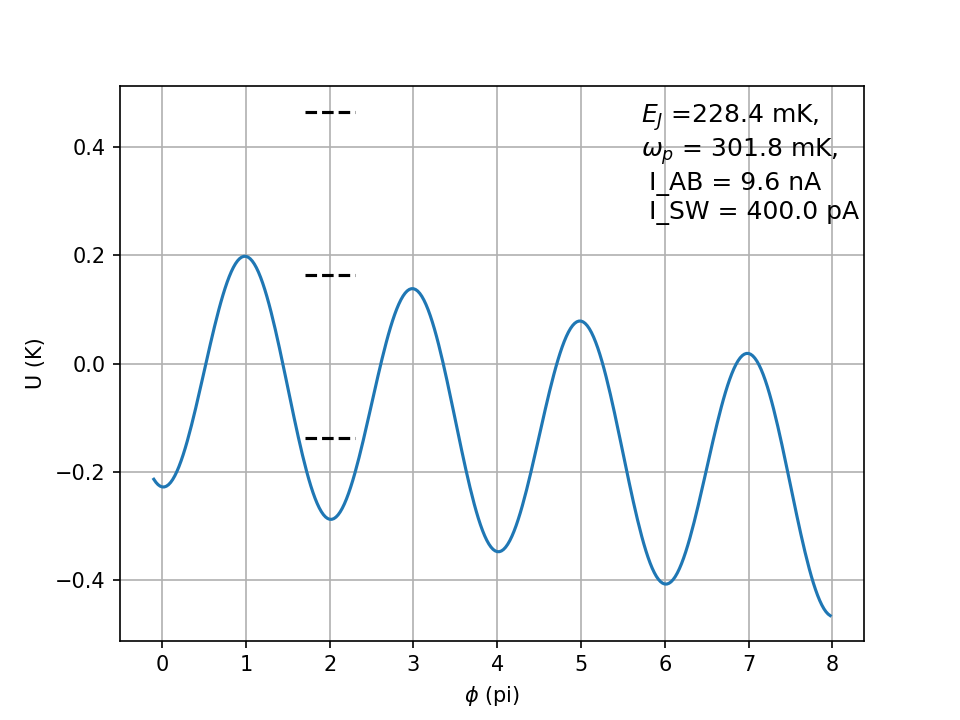

RN_JJ           33.400
Rs/JJ          136.940
I_AB             9.580
EJ               0.228
C_JJQP         205.000
EC               0.005
$\omega_p$       1.896
Q               40.794
beta          1664.181
EJ/EC           50.356
Name: 78N5, dtype: float64

In [43]:
f,ax = plt.subplots()

device = ['78N5']#, '78N5']
for i in device:
    JJplst = toJJplst(Q1Dlst)[0]
    ISW = Q1Dlst[Q1Dlst['Device']==i]['ISW'].astype(float)[0]/2
    EJ = JJplst[JJplst['Device']==i]['EJ'].astype(float)[0]
    tiltedWashboardU(EJ,[ISW],ax)

    freqPlasma = JJplst[JJplst['Device']==i]['$\omega_p$'].astype(float)/2/np.pi#*1e9*const.h/const.k
    U = lambda phi : -EJ*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *ISW *phi
    
    GSE = U(2*np.pi)/const.k
    ZPE = freqPlasma *0.5
    fx = np.asarray([1.7, 2.3])*np.pi
    ax.plot(fx/np.pi, [ GSE+ZPE*1, GSE+ZPE*1 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*3, GSE+ZPE*3 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*5, GSE+ZPE*5 ] ,ls = '--', color = 'black')

IAB = JJplst[JJplst['Device']==i]['I_AB'].astype(float)[0]*1e-9
ax.text(0.70, 0.75, 
        '$E_J$ ={}K,\n$\omega_p$ = {}K,\n I_AB = {}A\n I_SW = {}A'.format(si_format(EJ), si_format(freqPlasma[0]), si_format(IAB), si_format(ISW)), 
        verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)

ax.grid()
JJp.transpose()[device[0]]

<IPython.core.display.Javascript object>


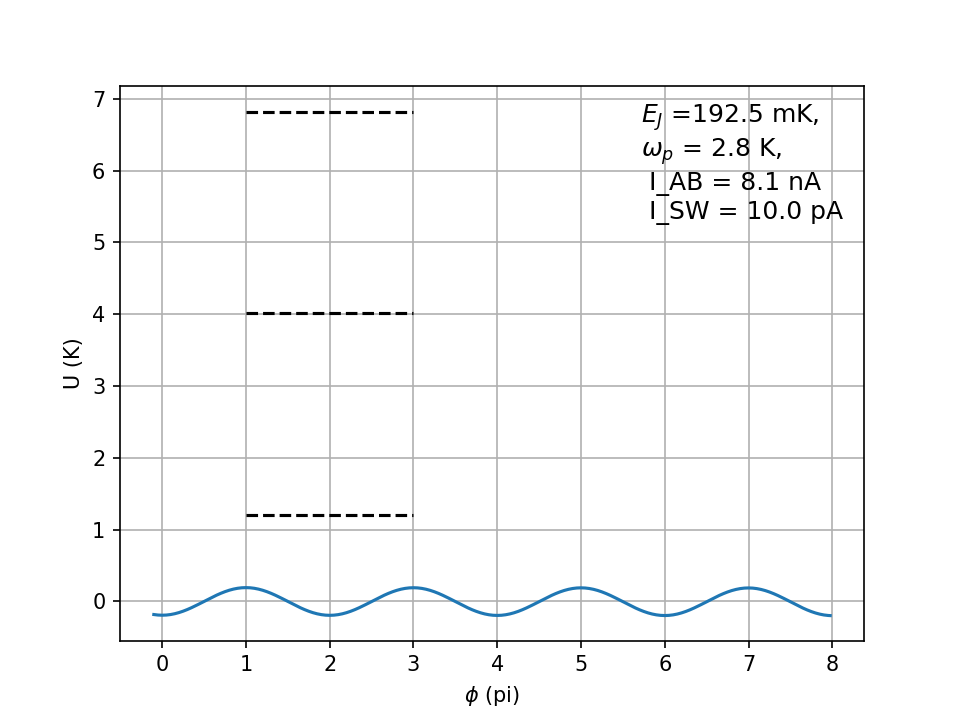

RN_JJ            39.613
Rs/JJ             1.981
I_AB              8.077
EJ                0.193
C_JJQP            2.000
EC                0.465
$\omega_p$       17.630
Q               131.646
beta          17330.621
EJ/EC             0.414
Name: 63BAN6_b, dtype: float64

In [473]:
f,ax = plt.subplots()

device = ['63BAN6_b']#, '78N5']
for i in device:
    JJplst = toJJplst(Q1Dlst)[0]
    ISW = Q1Dlst[Q1Dlst['Device']==i]['ISW'].astype(float)[0]/Q1Dlst[Q1Dlst['Device']==i]['#par'].astype(float)[0]
    EJ = JJplst[JJplst['Device']==i]['EJ'].astype(float)[0]
    tiltedWashboardU(EJ,[ISW],ax)

    freqPlasma = JJplst[JJplst['Device']==i]['$\omega_p$'].astype(float)/2/np.pi#*1e9*const.h/const.k
    U = lambda phi : -EJ*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *ISW *phi

    GSE = U(2*np.pi)/const.k
    ZPE = freqPlasma *0.5
    fx = np.asarray([1, 3])*np.pi
    ax.plot(fx/np.pi, [ GSE+ZPE*1, GSE+ZPE*1 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*3, GSE+ZPE*3 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*5, GSE+ZPE*5 ] ,ls = '--', color = 'black')
    
IAB = JJplst[JJplst['Device']==i]['I_AB'].astype(float)[0]*1e-9
ax.text(0.70, 0.75, 
        '$E_J$ ={}K,\n$\omega_p$ = {}K,\n I_AB = {}A\n I_SW = {}A'.format(si_format(EJ), si_format(freqPlasma[0]), si_format(IAB), si_format(ISW)), 
        verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)

ax.grid()
JJp.transpose()[device[0]]

<IPython.core.display.Javascript object>


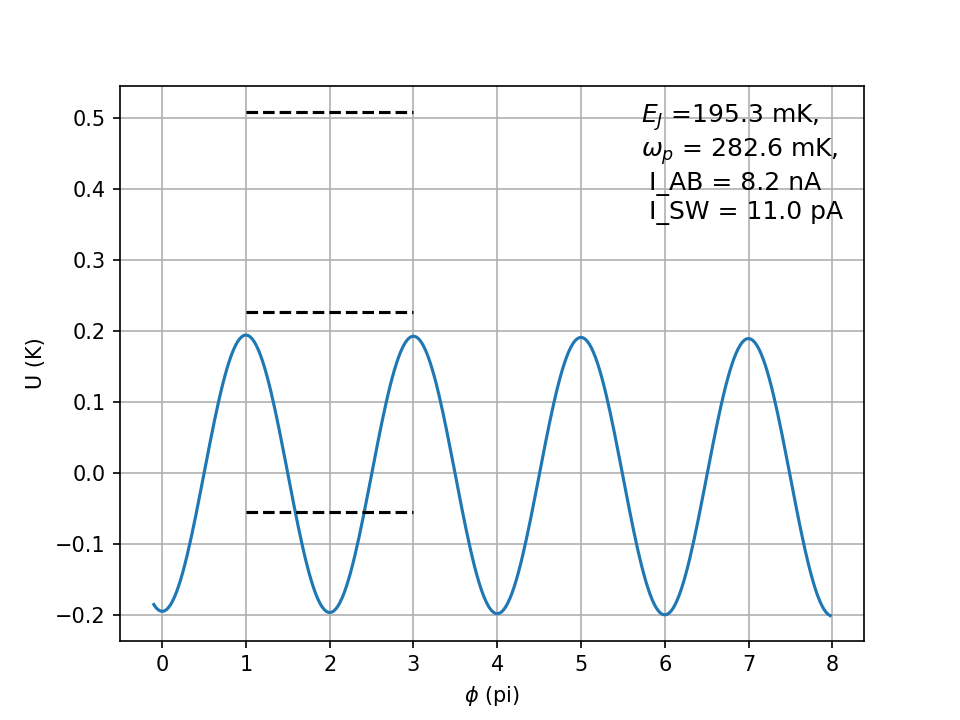

RN_JJ         3.906e+01
Rs/JJ         1.601e+02
I_AB          8.192e+00
EJ            1.953e-01
C_JJQP        2.000e+02
EC            4.648e-03
$\omega_p$    1.775e+00
Q             1.307e+03
beta          1.709e+06
EJ/EC         4.201e+01
Name: 63BAN6_a, dtype: float64

In [517]:
f,ax = plt.subplots()

device = ['63BAN6_a']#, '78N5']
for i in device:
    JJplst = toJJplst(Q1Dlst)[0]
    ISW = Q1Dlst[Q1Dlst['Device']==i]['ISW'].astype(float)[0]/Q1Dlst[Q1Dlst['Device']==i]['#par'].astype(float)[0]
    EJ = JJplst[JJplst['Device']==i]['EJ'].astype(float)[0]
    tiltedWashboardU(EJ,[ISW],ax)

    freqPlasma = JJplst[JJplst['Device']==i]['$\omega_p$'].astype(float)/2/np.pi#*1e9*const.h/const.k
    U = lambda phi : -EJ*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *ISW *phi

    GSE = U(2*np.pi)/const.k
    ZPE = freqPlasma *0.5
    fx = np.asarray([1, 3])*np.pi
    ax.plot(fx/np.pi, [ GSE+ZPE*1, GSE+ZPE*1 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*3, GSE+ZPE*3 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*5, GSE+ZPE*5 ] ,ls = '--', color = 'black')
    
IAB = JJplst[JJplst['Device']==i]['I_AB'].astype(float)[0]*1e-9
ax.text(0.70, 0.75, 
        '$E_J$ ={}K,\n$\omega_p$ = {}K,\n I_AB = {}A\n I_SW = {}A'.format(si_format(EJ), si_format(freqPlasma[0]), si_format(IAB), si_format(ISW)), 
        verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)

ax.grid()
JJp.transpose()[device[0]]

<IPython.core.display.Javascript object>


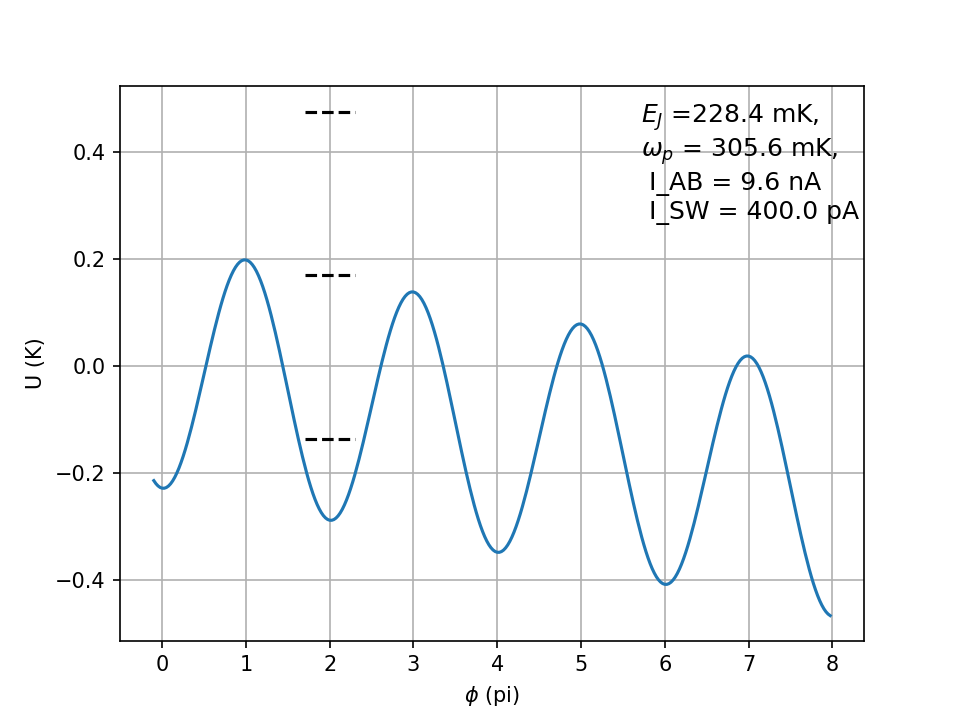

RN_JJ           33.400
Rs/JJ          136.940
I_AB             9.580
EJ               0.228
C_JJQP         200.000
EC               0.005
$\omega_p$       1.920
Q               40.294
beta          1623.591
EJ/EC           49.127
Name: 78N5, dtype: float64

In [505]:
f,ax = plt.subplots()

device = ['78N5']#, '78N5']
for i in device:
    JJplst = toJJplst(Q1Dlst)[0]
    ISW = Q1Dlst[Q1Dlst['Device']==i]['ISW'].astype(float)[0]/Q1Dlst[Q1Dlst['Device']==i]['#par'].astype(float)[0]

    EJ = JJplst[JJplst['Device']==i]['EJ'].astype(float)[0]
    tiltedWashboardU(EJ,[ISW],ax)

    freqPlasma = JJplst[JJplst['Device']==i]['$\omega_p$'].astype(float)/2/np.pi#*1e9*const.h/const.k
    U = lambda phi : -EJ*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *ISW *phi

    GSE = U(2*np.pi)/const.k
    ZPE = freqPlasma *0.5
    fx = np.asarray([1.7, 2.3])*np.pi
    ax.plot(fx/np.pi, [ GSE+ZPE*1, GSE+ZPE*1 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*3, GSE+ZPE*3 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*5, GSE+ZPE*5 ] ,ls = '--', color = 'black')
    
IAB = JJplst[JJplst['Device']==i]['I_AB'].astype(float)[0]*1e-9
ax.text(0.70, 0.75, 
        '$E_J$ ={}K,\n$\omega_p$ = {}K,\n I_AB = {}A\n I_SW = {}A'.format(si_format(EJ), si_format(freqPlasma[0]), si_format(IAB), si_format(ISW)), 
        verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)
    
ax.grid()
JJp.transpose()[device[0]]

<IPython.core.display.Javascript object>


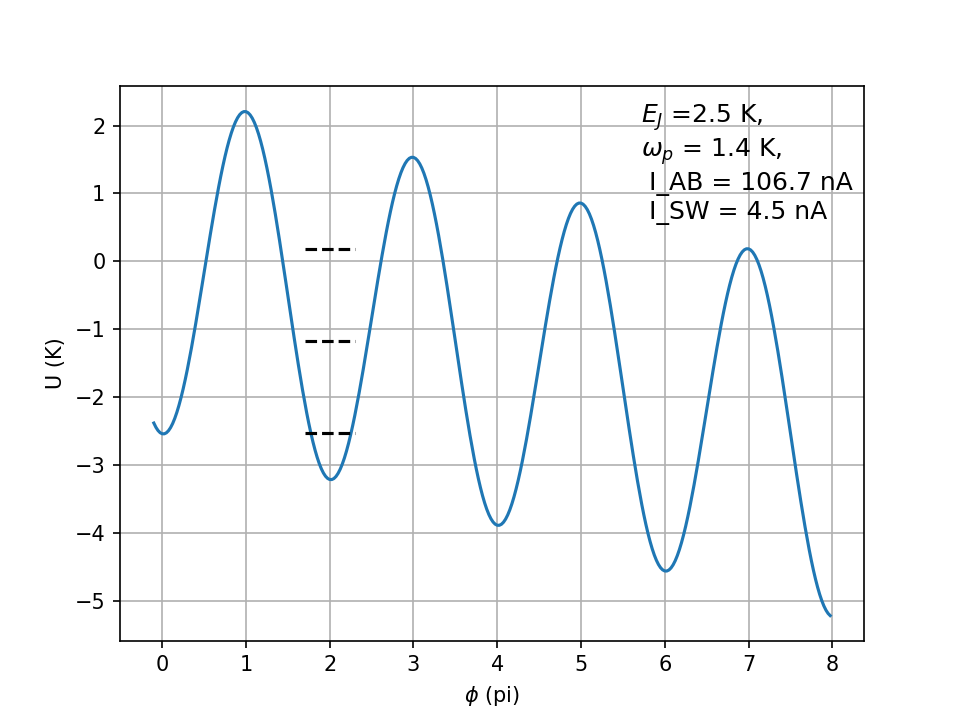

RN_JJ            3.000
Rs/JJ            6.975
I_AB           106.653
EJ               2.542
C_JJQP         112.500
EC               0.008
$\omega_p$       8.542
Q               81.513
beta          6644.450
EJ/EC          307.661
Name: 74N4, dtype: float64

In [475]:
f,ax = plt.subplots()

device = ['74N4']
for i in device:
    JJplst = toJJplst(Q1Dlst)[0]
    ISW = Q1Dlst[Q1Dlst['Device']==i]['ISW'].astype(float)[0]/Q1Dlst[Q1Dlst['Device']==i]['#par'].astype(float)[0]
    EJ = JJplst[JJplst['Device']==i]['EJ'].astype(float)[0]
    tiltedWashboardU(EJ,[ISW],ax)

    freqPlasma = JJplst[JJplst['Device']==i]['$\omega_p$'].astype(float)/2/np.pi
    U = lambda phi : -EJ*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *ISW *phi

    GSE = U(2*np.pi)/const.k
    ZPE = freqPlasma *0.5
    fx = np.asarray([1.7, 2.3])*np.pi
    ax.plot(fx/np.pi, [ GSE+ZPE*1, GSE+ZPE*1 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*3, GSE+ZPE*3 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*5, GSE+ZPE*5 ] ,ls = '--', color = 'black')

IAB = JJplst[JJplst['Device']==i]['I_AB'].astype(float)[0]*1e-9
ax.text(0.70, 0.75, 
        '$E_J$ ={}K,\n$\omega_p$ = {}K,\n I_AB = {}A\n I_SW = {}A'.format(si_format(EJ), si_format(freqPlasma[0]), si_format(IAB), si_format(ISW)), 
        verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)
    
ax.grid()
JJp.transpose()[device[0]]

<IPython.core.display.Javascript object>


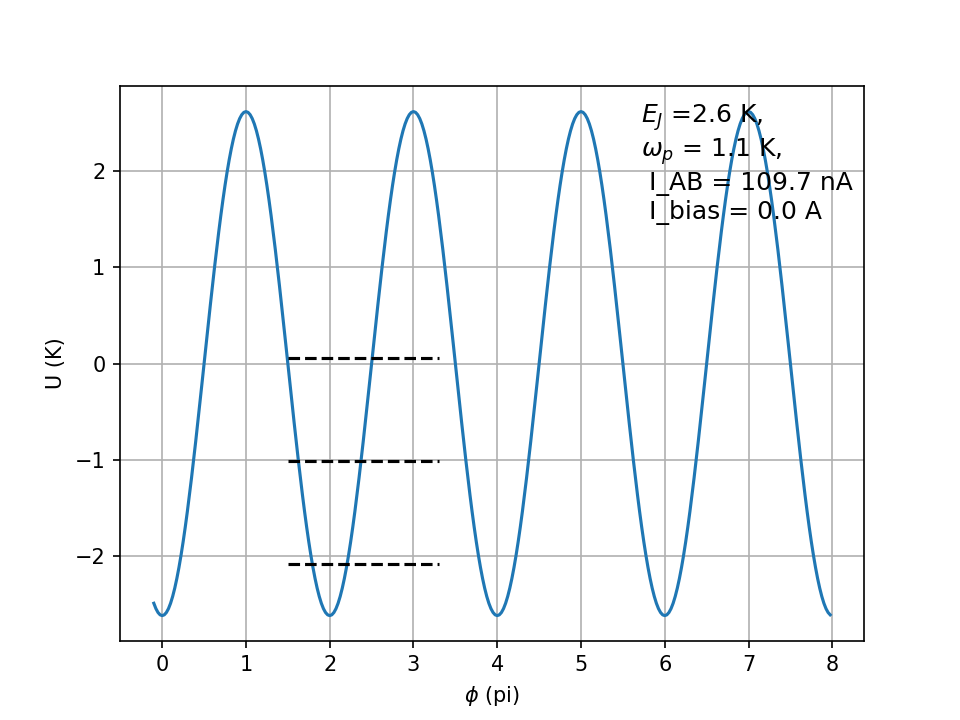

RN_JJ           2.916
Rs/JJ          11.188
I_AB          109.726
EJ              2.616
C_JJQP        187.000
EC              0.005
$\omega_p$      6.720
Q              11.512
beta          132.535
EJ/EC         526.132
Name: 79N6, dtype: float64

In [530]:
f,ax = plt.subplots()

device = ['79N6']
for i in device:
    JJplst = toJJplst(Q1Dlst)[0]
    ISW = Q1Dlst[Q1Dlst['Device']==i]['ISW'].astype(float)[0]/Q1Dlst[Q1Dlst['Device']==i]['#par'].astype(float)[0]
    ISW=ISW*0
    EJ = JJplst[JJplst['Device']==i]['EJ'].astype(float)[0]
    tiltedWashboardU(EJ,[ISW],ax)

    freqPlasma = JJplst[JJplst['Device']==i]['$\omega_p$'].astype(float)/2/np.pi#*1e9*const.h/const.k
    U = lambda phi : -EJ*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *ISW *phi

    GSE = U(2*np.pi)/const.k
    ZPE = freqPlasma *0.5
    fx = np.asarray([1.5, 3.3])*np.pi
    ax.plot(fx/np.pi, [ GSE+ZPE*1, GSE+ZPE*1 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*3, GSE+ZPE*3 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*5, GSE+ZPE*5 ] ,ls = '--', color = 'black')

IAB = JJplst[JJplst['Device']==i]['I_AB'].astype(float)[0]*1e-9
ax.text(0.70, 0.75, 
        '$E_J$ ={}K,\n$\omega_p$ = {}K,\n I_AB = {}A\n I_bias = {}A'.format(si_format(EJ), si_format(freqPlasma[0]), si_format(IAB), si_format(ISW)), 
        verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)
        
ax.grid()
JJp.transpose()[device[0]]

<IPython.core.display.Javascript object>


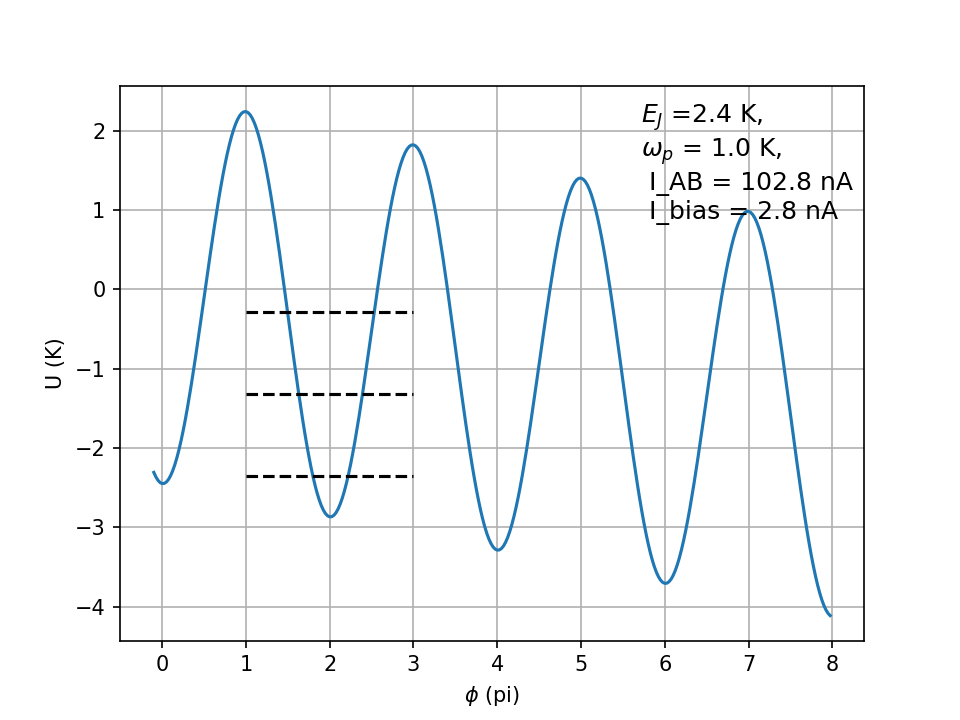

In [532]:
f,ax = plt.subplots()

device = ['79N5']
for i in device:
    JJplst = toJJplst(Q1Dlst)[0]
    ISW = Q1Dlst[Q1Dlst['Device']==i]['ISW'].astype(float)[0]/Q1Dlst[Q1Dlst['Device']==i]['#par'].astype(float)[0]
    ISW=ISW*1
    EJ = JJplst[JJplst['Device']==i]['EJ'].astype(float)[0]
    tiltedWashboardU(EJ,[ISW],ax)

    freqPlasma = JJplst[JJplst['Device']==i]['$\omega_p$'].astype(float)/2/np.pi#*1e9*const.h/const.k
    U = lambda phi : -EJ*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *ISW *phi

    GSE = U(2*np.pi)/const.k
    ZPE = freqPlasma *0.5
    fx = np.asarray([1, 3])*np.pi
    ax.plot(fx/np.pi, [ GSE+ZPE*1, GSE+ZPE*1 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*3, GSE+ZPE*3 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*5, GSE+ZPE*5 ] ,ls = '--', color = 'black')

IAB = JJplst[JJplst['Device']==i]['I_AB'].astype(float)[0]*1e-9
ax.text(0.70, 0.75, 
        '$E_J$ ={}K,\n$\omega_p$ = {}K,\n I_AB = {}A\n I_bias = {}A'.format(si_format(EJ), si_format(freqPlasma[0]), si_format(IAB), si_format(ISW)), 
        verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)
    
ax.grid()

<IPython.core.display.Javascript object>


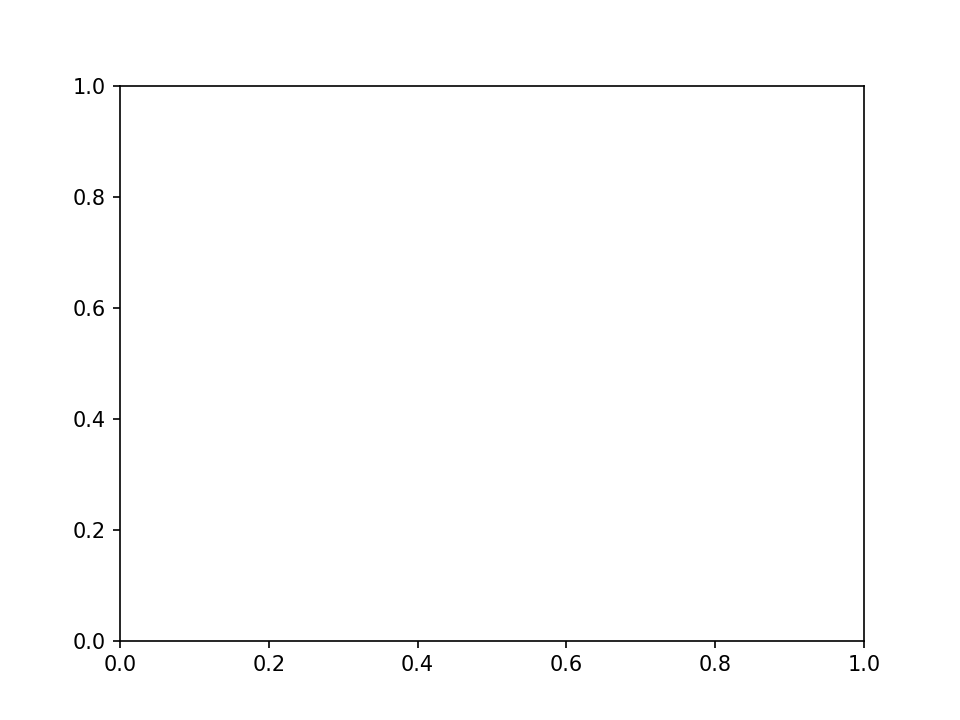

IndexError: index out of bounds

In [533]:
f,ax = plt.subplots()

device = ['59B0']
for i in device:
    JJplst = toJJplst(Q1Dlst)[0]
    ISW = Q1Dlst[Q1Dlst['Device']==i]['ISW'].astype(float)[0]/Q1Dlst[Q1Dlst['Device']==i]['#par'].astype(float)[0]
    ISW=ISW*1
    EJ = JJplst[JJplst['Device']==i]['EJ'].astype(float)[0]
    tiltedWashboardU(EJ,[ISW],ax)

    freqPlasma = JJplst[JJplst['Device']==i]['$\omega_p$'].astype(float)/2/np.pi#*1e9*const.h/const.k
    U = lambda phi : -EJ*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *ISW *phi

    GSE = U(2*np.pi)/const.k
    ZPE = freqPlasma *0.5
    fx = np.asarray([1, 3])*np.pi
    ax.plot(fx/np.pi, [ GSE+ZPE*1, GSE+ZPE*1 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*3, GSE+ZPE*3 ] ,ls = '--', color = 'black')
    ax.plot(fx/np.pi, [ GSE+ZPE*5, GSE+ZPE*5 ] ,ls = '--', color = 'black')

IAB = JJplst[JJplst['Device']==i]['I_AB'].astype(float)[0]*1e-9
ax.text(0.70, 0.75, 
        '$E_J$ ={}K,\n$\omega_p$ = {}K,\n I_AB = {}A\n I_bias = {}A'.format(si_format(EJ), si_format(freqPlasma[0]), si_format(IAB), si_format(ISW)), 
        verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)
    
ax.grid()

<IPython.core.display.Javascript object>


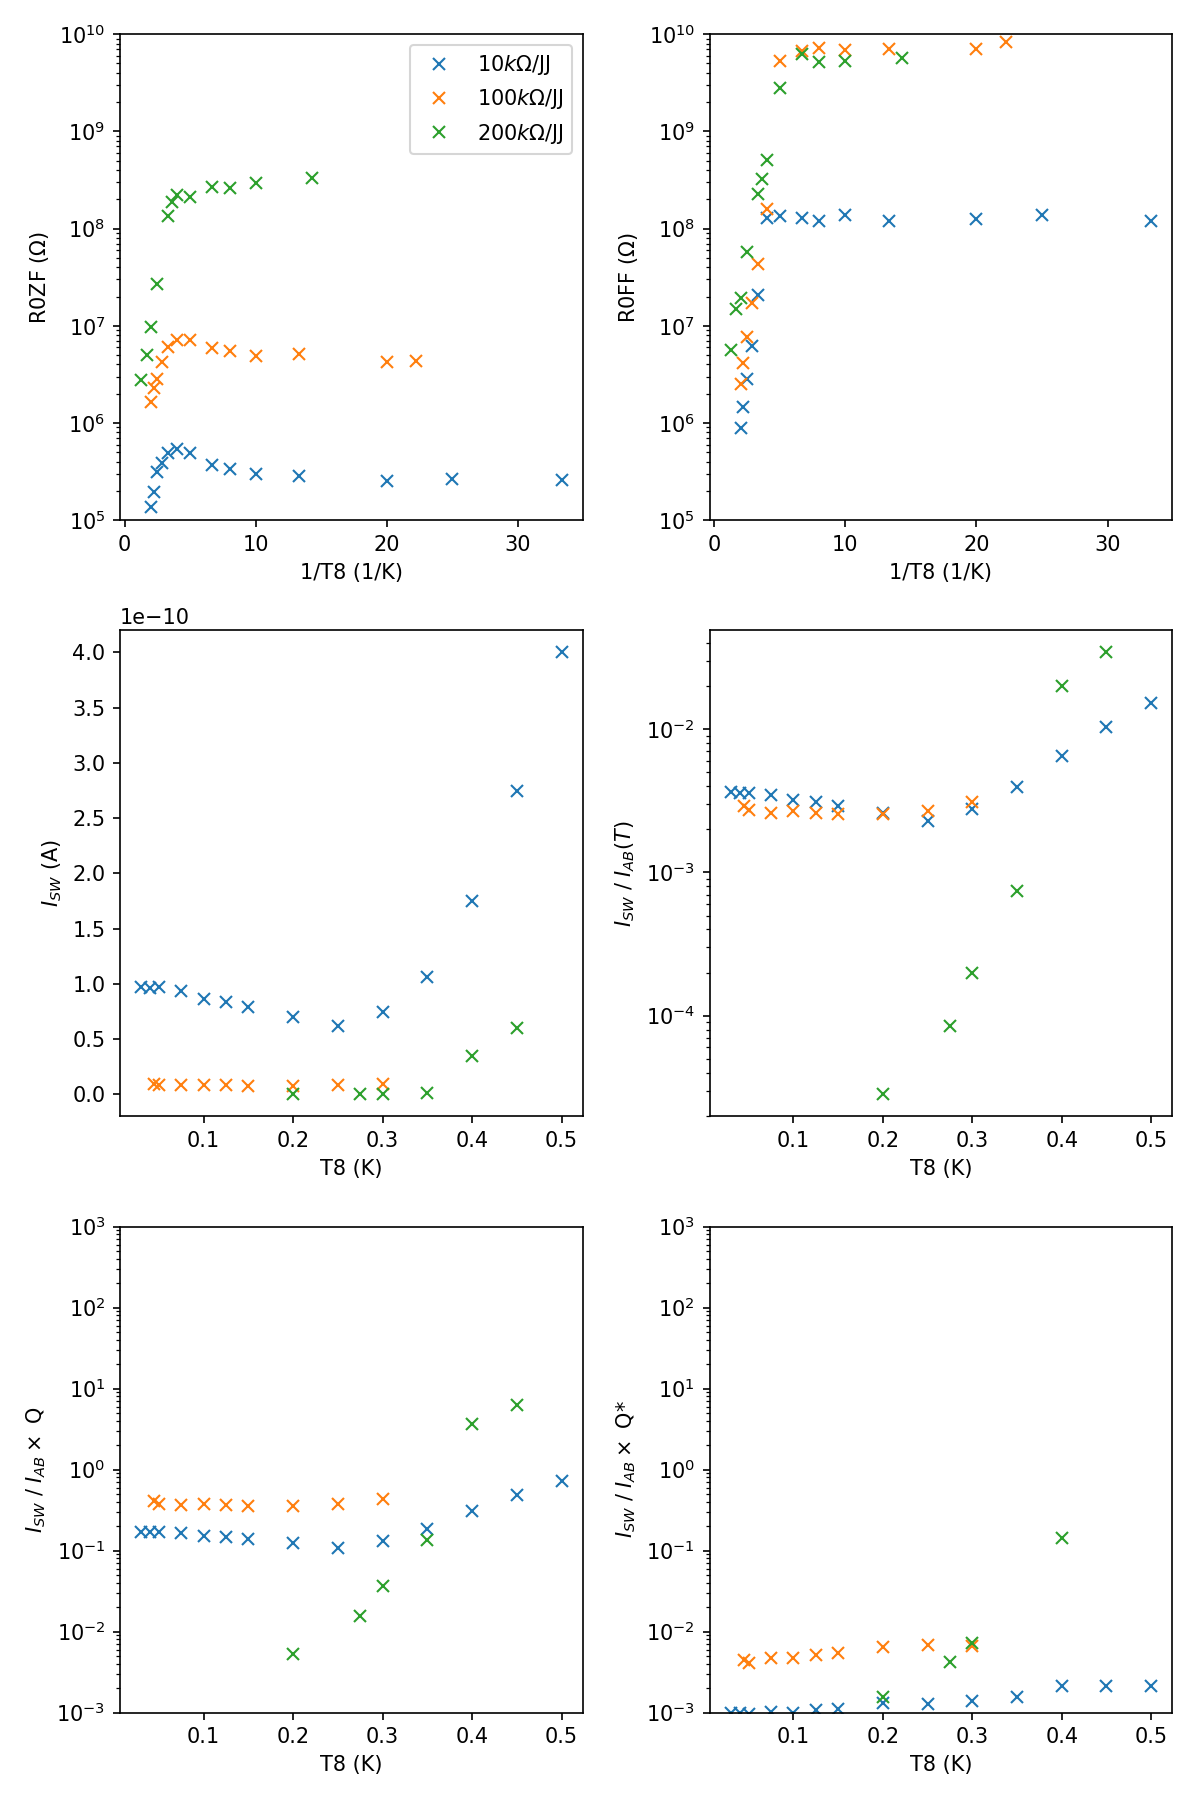

In [479]:
f,ax = plt.subplots(3,2,figsize = (8,12))
ax = ax.flatten()
labellst = ['$10k\Omega$/JJ', '$100k\Omega$/JJ', '$200k\Omega$/JJ']

for i,v in enumerate([Q1D55B1N9lst, Q1D62B3N2lst, Q1D59BBN2lst]):
    ax[0].plot(1/v['T8'],v['R0ZF'],ls = 'None', marker = 'x', label = labellst[i])
    ax[1].plot(1/v['T8'],v['R0FF'],ls = 'None', marker = 'x')
    ax[2].plot(v['T8'],v['ISW']/2,ls = 'None', marker = 'x')
    
    RN = (v['RN/al']/v['#ser']*v['#par']).iloc[0]
    IAB = IABT(gapK = 1.764*1.3, RN = RN, T = np.asarray(v['T8'].to_list()))
    ax[3].plot(v['T8'],v['ISW']/2/(IAB),
               ls = 'None', marker = 'x')
    
    Qarr = QQstar(srclst = v)
    ax[4].plot(v['T8'],v['ISW']/2/(IAB/Qarr[0]),
               ls = 'None', marker = 'x')
    ax[5].plot(v['T8'],v['ISW']/2/(IAB/Qarr[1]),
               ls = 'None', marker = 'x')
    
ax[0].set_yscale('log')
ax[0].set_ylim(1e5,1e10)
ax[0].legend()
ax[0].set_xlabel('1/T8 (1/K)')
ax[0].set_ylabel('R0ZF ($\Omega$)')

ax[1].set_yscale('log')
ax[1].set_ylim(1e5,1e10)
ax[1].set_xlabel('1/T8 (1/K)')
ax[1].set_ylabel('R0FF ($\Omega$)')

ax[2].set_xlabel('T8 (K)')
ax[2].set_ylabel('$I_{SW}$ (A)')

ax[3].set_yscale('log')
ax[3].set_xlabel('T8 (K)')
ax[3].set_ylabel('$I_{SW}$ / $I_{AB}(T)$')

ax[4].set_yscale('log')
ax[4].set_ylim(1e-3,1e3)
ax[4].set_xlabel('T8 (K)')
ax[4].set_ylabel(r'$I_{SW}$ / $I_{AB} \times$ Q')

ax[5].set_yscale('log')
ax[5].set_ylim(1e-3,1e3)
ax[5].set_xlabel('T8 (K)')
ax[5].set_ylabel(r'$I_{SW}$ / $I_{AB} \times$ Q*')


plt.tight_layout()

<IPython.core.display.Javascript object>


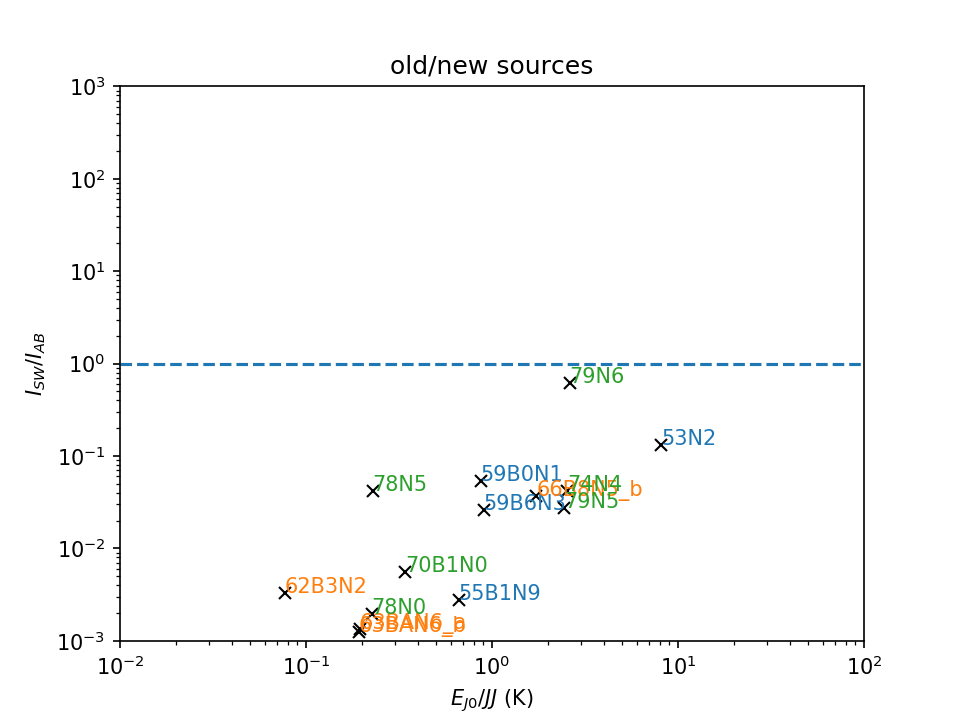

(0.001, 1000.0)

In [478]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float), marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
for i, txt in enumerate(n):
    if int(Q1Dlst['Device'][i][:2]) < 60:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C0')
    elif 60 <= int(Q1Dlst['Device'][i][:2]) < 70:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C1')
    elif 70 <= int(Q1Dlst['Device'][i][:2]):
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C2')
        
ax.axhline(1e0,ls = '--')
ax.set_title('old/new sources')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel('$I_{SW} / I_{AB}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


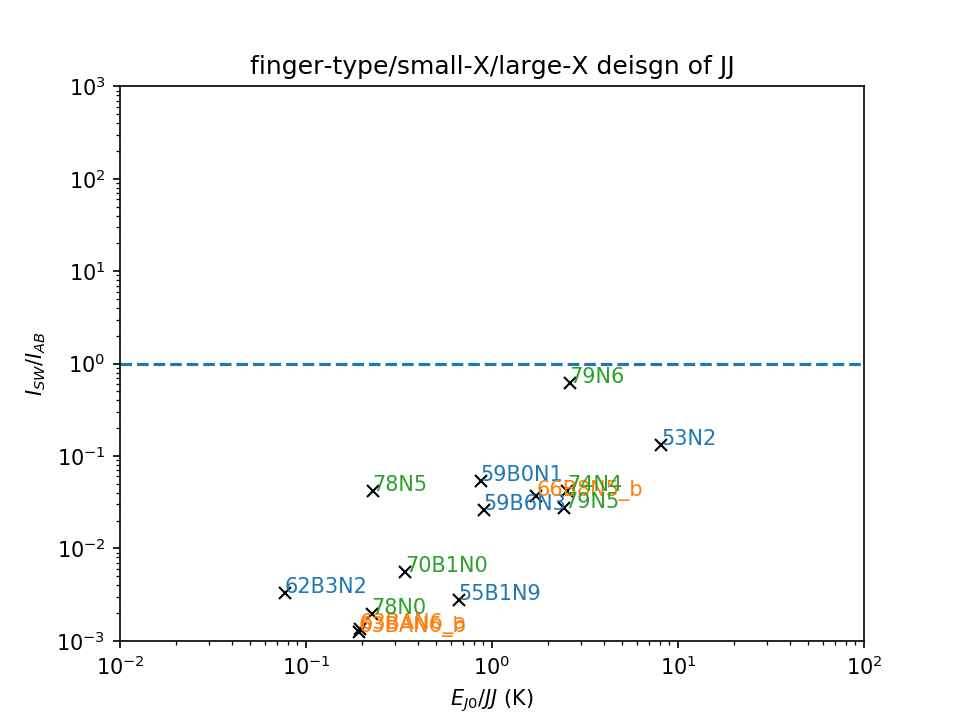

(0.001, 1000.0)

In [480]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float), marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
for i, txt in enumerate(n):
    if Q1Dlst['dsgn'][i] == 'Fin':
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C0')
    elif Q1Dlst['dsgn'][i] == 'x_s':
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C1')
    elif Q1Dlst['dsgn'][i] == 'x_L':
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C2')

        
ax.axhline(1e0,ls = '--')
ax.set_title('finger-type/small-X/large-X deisgn of JJ')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel('$I_{SW} / I_{AB}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


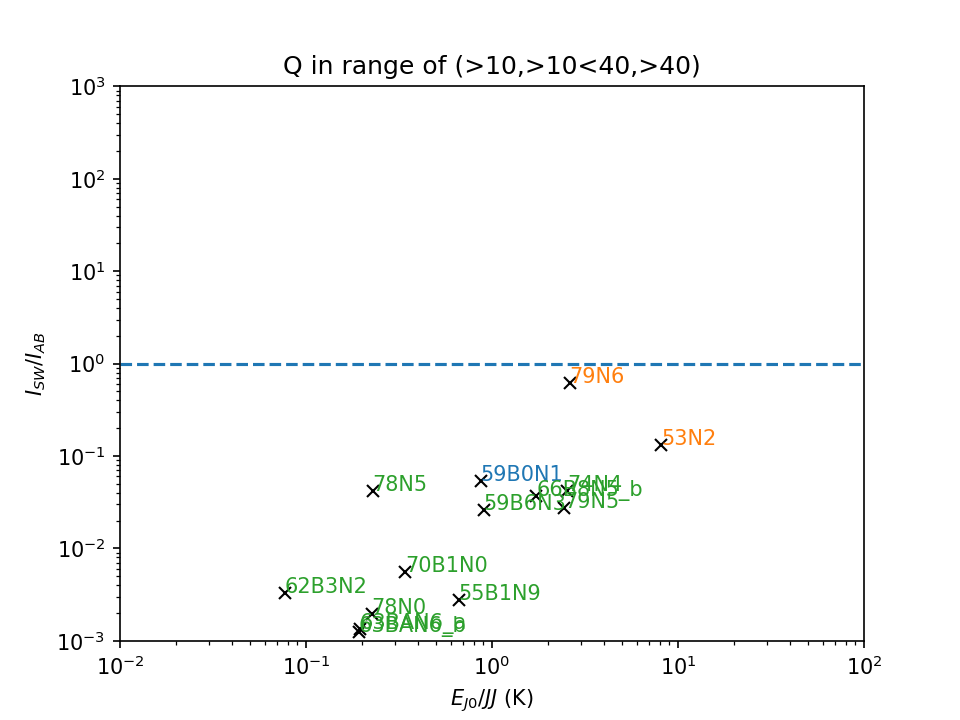

(0.001, 1000.0)

In [481]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float), marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
srchtgt = JJplst['Q'].astype(float)
criteria = [0, 10, 40]
for i, txt in enumerate(n):
    if   criteria[0] <= srchtgt[i] < criteria[1]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C0')
    elif criteria[1] <= srchtgt[i] < criteria[2]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C1')
    elif criteria[2] <= srchtgt[i]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C2')
       
ax.axhline(1e0,ls = '--')
ax.set_title('Q in range of (>10,>10<40,>40)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel('$I_{SW} / I_{AB}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


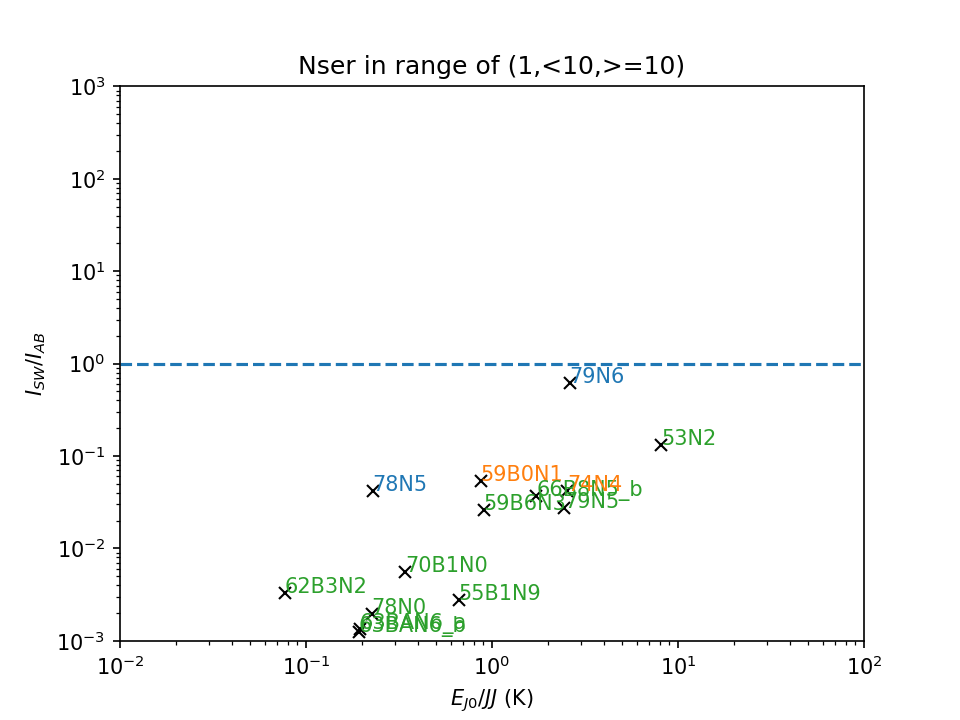

(0.001, 1000.0)

In [482]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float), marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
srchtgt = Q1Dlst['#ser'].astype(float)
criteria = [0, 2, 10]
for i, txt in enumerate(n):
    if   criteria[0] <= srchtgt[i] < criteria[1]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C0')
    elif criteria[1] <= srchtgt[i] < criteria[2]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C1')
    elif criteria[2] <= srchtgt[i]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C2')

ax.axhline(1e0,ls = '--')
ax.set_title('Nser in range of (1,<10,>=10)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel('$I_{SW} / I_{AB}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


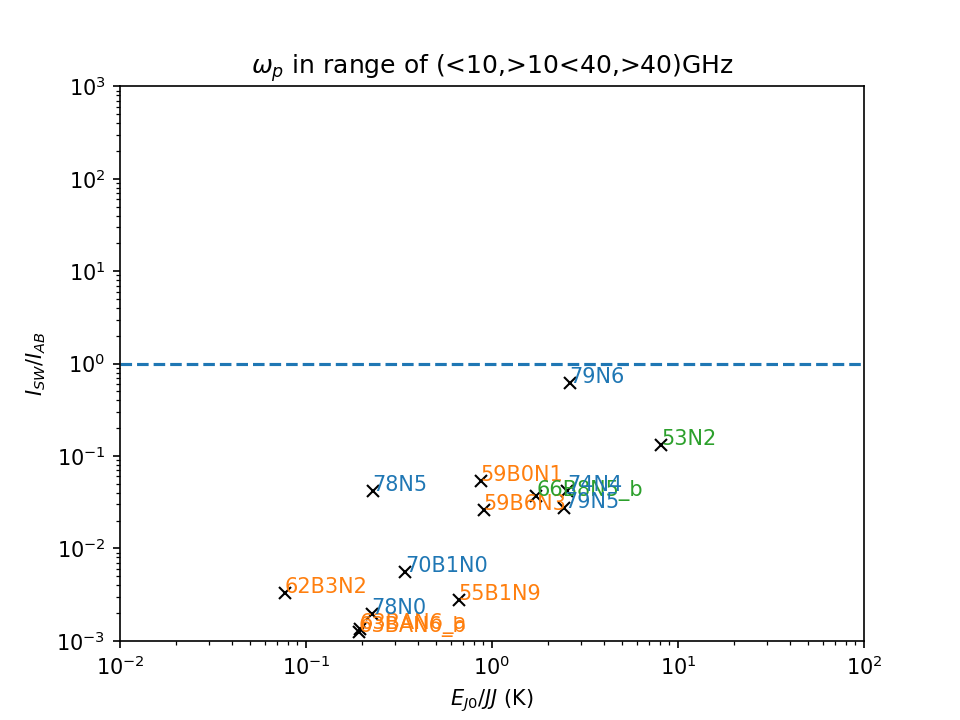

(0.001, 1000.0)

In [483]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float), marker = 'x', ls = 'None', color = 'black')


n = Q1Dlst['Device']
srchtgt = JJplst['$\omega_p$'].astype(float)
criteria = [0, 10, 40]
for i, txt in enumerate(n):
    if   criteria[0] <= srchtgt[i] < criteria[1]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C0')
    elif criteria[1] <= srchtgt[i] < criteria[2]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C1')
    elif criteria[2] <= srchtgt[i]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C2')

ax.axhline(1e0,ls = '--')
ax.set_title('$\omega_p$ in range of (<10,>10<40,>40)GHz')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel('$I_{SW} / I_{AB}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

In [488]:
Q1Dlst['ISW']/JJplst['I_AB'].astype(float)/Q

53N2              NaN
53N2              NaN
55B1N9      1.164e-13
59B0N1      2.587e-11
59B6N3      1.289e-12
59BBN2      9.499e-16
60B2N2      2.325e-14
60B2N6      2.193e-15
62B3N2      4.692e-14
63BAN6_a    2.055e-14
63BAN6_b    1.881e-14
66B8N5_b    1.694e-12
70B1N0      2.264e-14
74N4        1.035e-12
78N0        6.455e-15
78N5        2.073e-12
79N5        3.054e-13
79N6        1.085e-10
dtype: float64

<IPython.core.display.Javascript object>


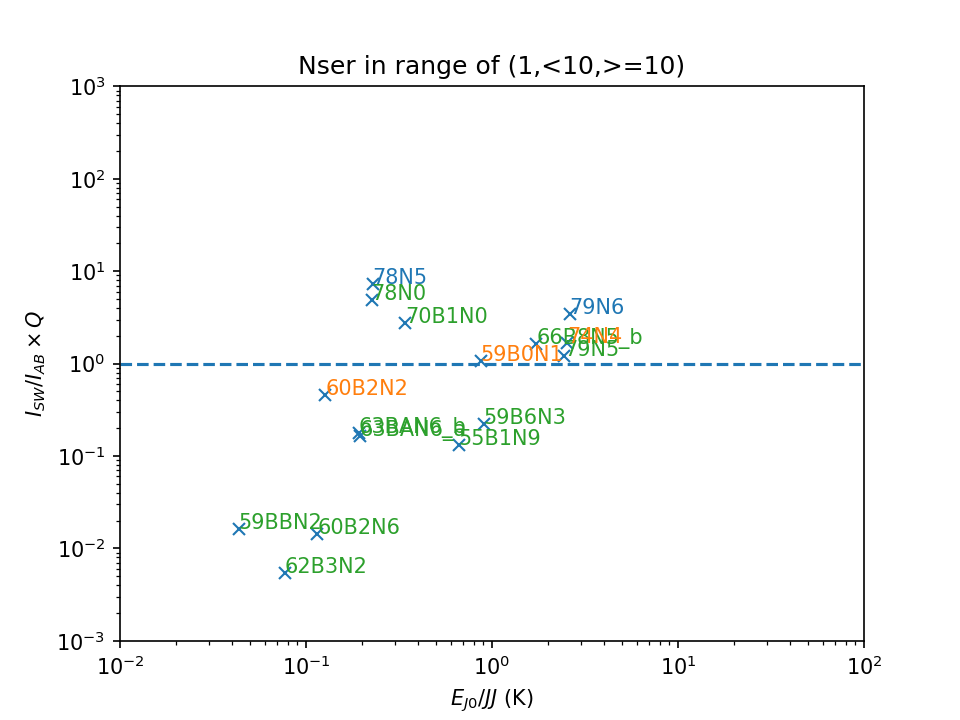

(0.001, 1000.0)

In [491]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), (Q1Dlst['ISW']/2/1e-9/(JJplst['I_AB'].astype(float)/Q))[1:], marker = 'x', ls = 'None')

n = Q1Dlst['Device']
srchtgt = Q1Dlst['#ser'].astype(float)
criteria = [0, 2, 10]
for i, txt in enumerate(n):
    if   criteria[0] <= srchtgt[i] < criteria[1]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/(JJplst['I_AB'].astype(float)/Q))[1:][i]),
                    color='C0')
    elif criteria[1] <= srchtgt[i] < criteria[2]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/(JJplst['I_AB'].astype(float)/Q))[1:][i]),
                    color='C1')
    elif criteria[2] <= srchtgt[i]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/2/1e-9/(JJplst['I_AB'].astype(float)/Q))[1:][i]),
                    color='C2')
        
ax.axhline(1e0,ls = '--')
ax.set_title('Nser in range of (1,<10,>=10)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel(r'$I_{SW} / I_{AB} \times Q$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


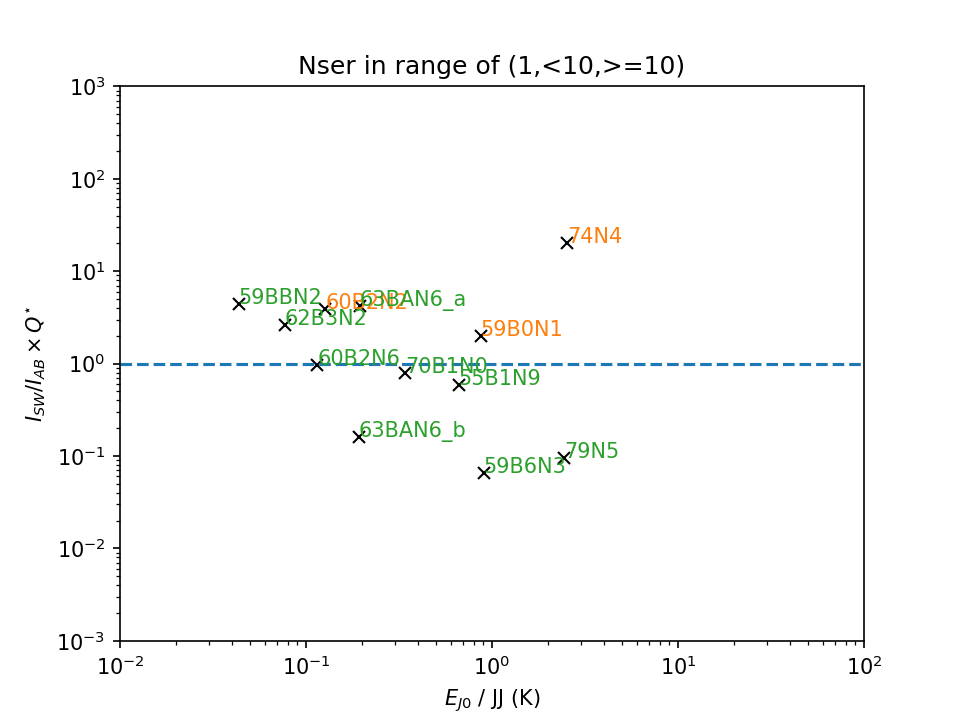

(0.001, 1000.0)

In [493]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:], marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
srchtgt = Q1Dlst['#ser'].astype(float)
criteria = [0, 2, 10]
for i, txt in enumerate(n):
    if   criteria[0] <= srchtgt[i] < criteria[1]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C0')
    elif criteria[1] <= srchtgt[i] < criteria[2]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C1')
    elif criteria[2] <= srchtgt[i]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C2')

ax.axhline(1e0,ls = '--')
ax.set_title('Nser in range of (1,<10,>=10)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$E_{J0}$ / JJ (K)')
ax.set_ylabel(r'$I_{SW} / I_{AB} \times Q^{\star}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


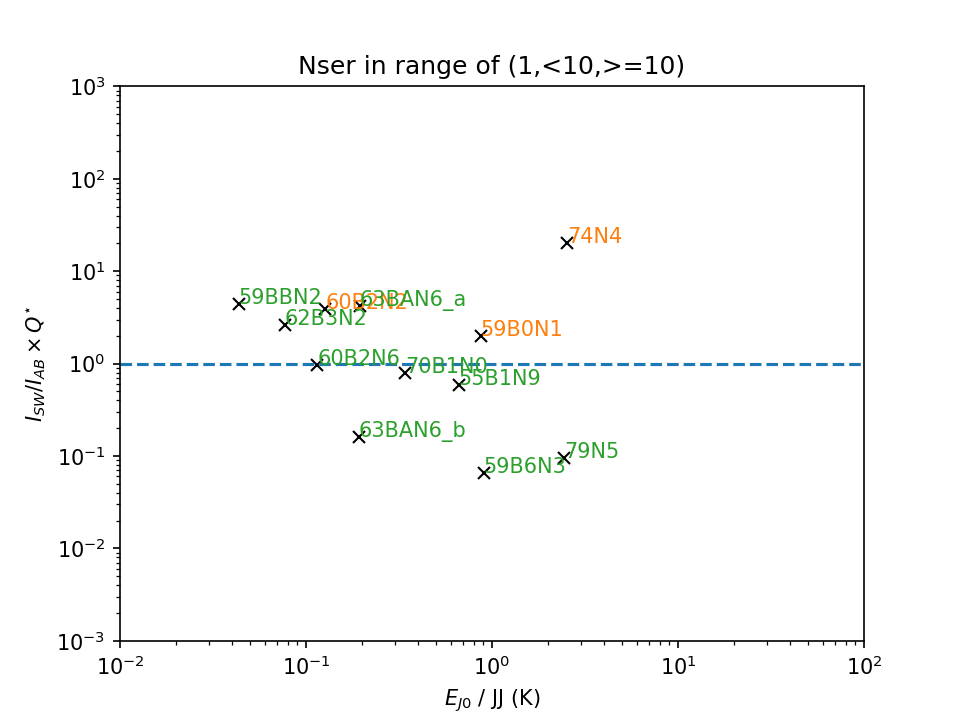

(0.001, 1000.0)

In [494]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:], marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
srchtgt = Q1Dlst['#ser'].astype(float)
criteria = [0, 2, 10]
for i, txt in enumerate(n):
    if   criteria[0] <= srchtgt[i] < criteria[1]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C0')
    elif criteria[1] <= srchtgt[i] < criteria[2]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C1')
    elif criteria[2] <= srchtgt[i]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C2')

ax.axhline(1e0,ls = '--')
ax.set_title('Nser in range of (1,<10,>=10)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$E_{J0}$ / JJ (K)')
ax.set_ylabel(r'$I_{SW} / I_{AB} \times Q^{\star}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


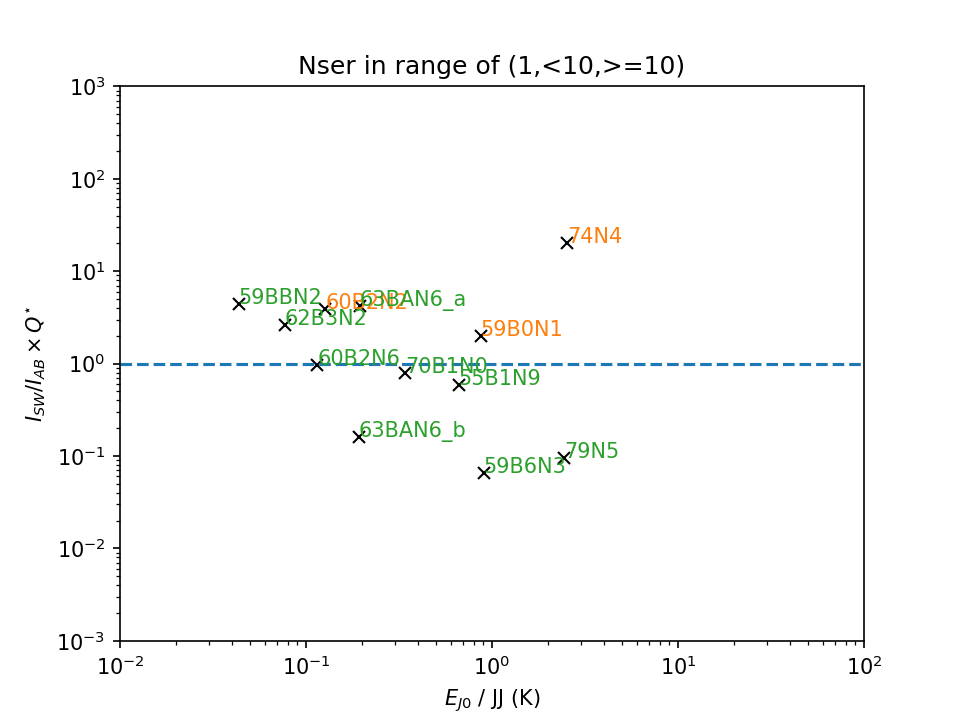

(0.001, 1000.0)

In [495]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:], marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
srchtgt = Q1Dlst['#ser'].astype(float)
criteria = [0, 2, 10]
for i, txt in enumerate(n):
    if   criteria[0] <= srchtgt[i] < criteria[1]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C0')
    elif criteria[1] <= srchtgt[i] < criteria[2]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C1')
    elif criteria[2] <= srchtgt[i]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C2')

ax.axhline(1e0,ls = '--')
ax.set_title('Nser in range of (1,<10,>=10)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$E_{J0}$ / JJ (K)')
ax.set_ylabel(r'$I_{SW} / I_{AB} \times Q^{\star}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


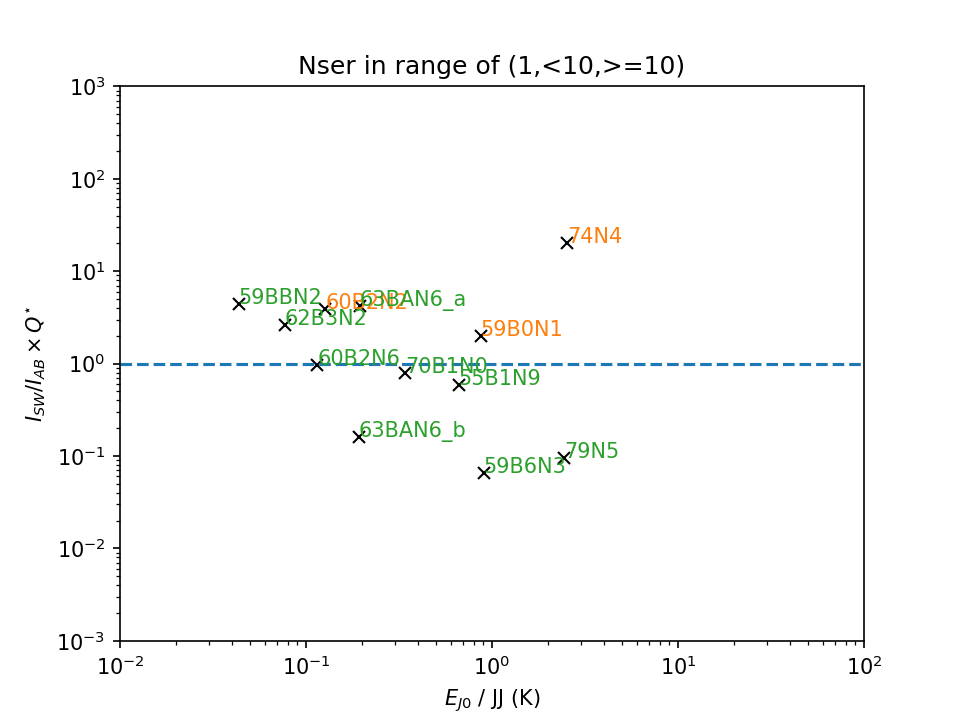

(0.001, 1000.0)

In [496]:
f,ax = plt.subplots()
JJplst = toJJplst(Q1Dlst)[0]
ax.plot(JJplst['EJ'].astype(float), (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:], marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
srchtgt = Q1Dlst['#ser'].astype(float)
criteria = [0, 2, 10]
for i, txt in enumerate(n):
    if   criteria[0] <= srchtgt[i] < criteria[1]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C0')
    elif criteria[1] <= srchtgt[i] < criteria[2]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C1')
    elif criteria[2] <= srchtgt[i]:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/(JJplst['I_AB'].astype(float)/Q_star))[1:][i]),
                    color='C2')

ax.axhline(1e0,ls = '--')
ax.set_title('Nser in range of (1,<10,>=10)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$E_{J0}$ / JJ (K)')
ax.set_ylabel(r'$I_{SW} / I_{AB} \times Q^{\star}$')
ax.set_xlim(0.01,100)
ax.set_ylim(1e-3,1e3)

<IPython.core.display.Javascript object>


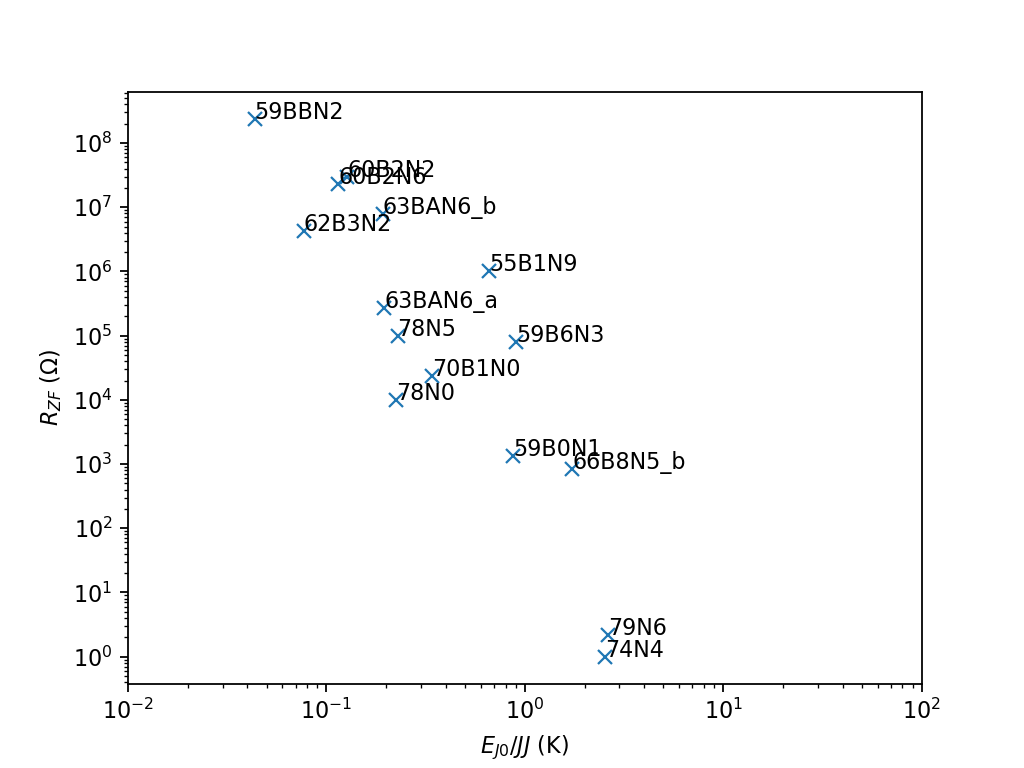

(0.01, 100)

In [806]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), Q1Dlst['R0ZF'], marker = 'x', ls = 'None')

n = Q1Dlst['Device']
for i, txt in enumerate(n):
    ax.annotate(txt, (JJplst['EJ'][i].astype(float), Q1Dlst['R0ZF'][i]))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel('$R_{ZF}$ ($\Omega$)')
ax.set_xlim(0.01,100)

<IPython.core.display.Javascript object>


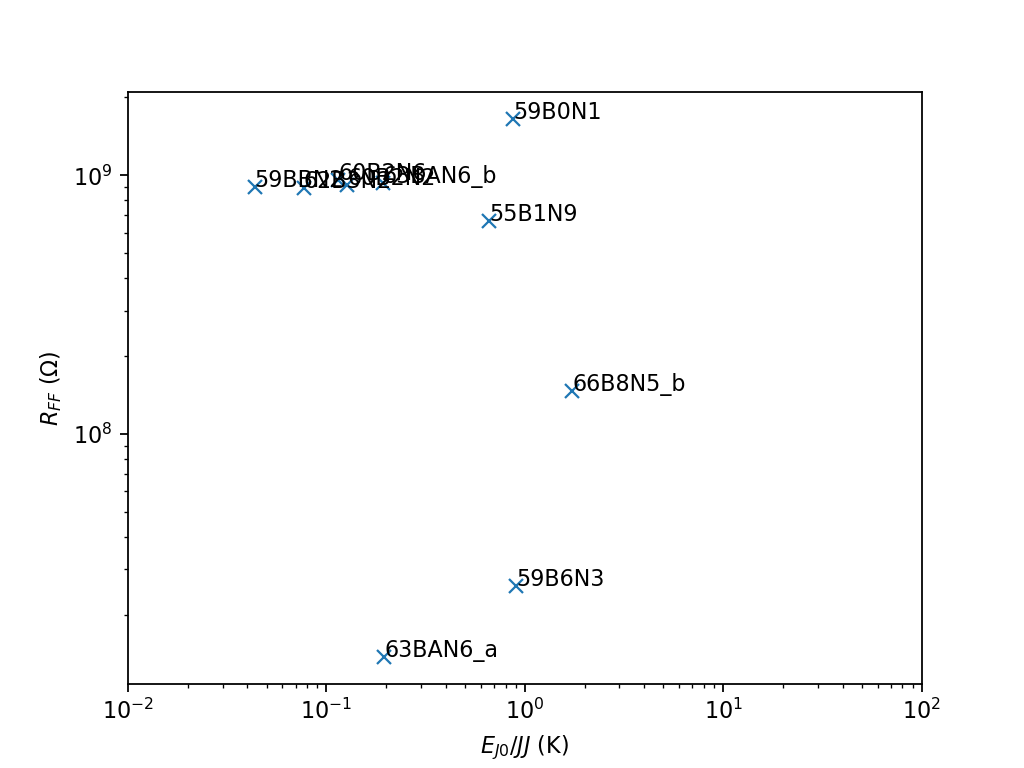

(0.01, 100)

In [807]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), Q1Dlst['R0FF'], marker = 'x', ls = 'None')

n = Q1Dlst['Device']
for i, txt in enumerate(n):
    ax.annotate(txt, (JJplst['EJ'][i].astype(float), Q1Dlst['R0FF'][i]))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel('$R_{FF}$ ($\Omega$)')
ax.set_xlim(0.01,100)

In [248]:
cf1 = ['79N5', '63BAN6_b']

for i in cf1:
    JJp = toJJplst(Q1Dlst[Q1Dlst['Device']==i])[0]
    Q1D = Q1Dlst[Q1Dlst['Device']==i]
    O = pd.merge(Q1D,JJp)
O

Device  Vo/al     RN/al        ISW       R0ZF       R0FF  #ser  #par  \
0  63BAN6_b  0.005  594200.0  2.000e-11  7.715e+06  9.350e+08    30     2   

  Mat.    BT  ...              RN_JJ               Rs/JJ               I_AB  \
0   Al  0.03  ...  39.61333333333334  1.9806666666666661  8.077084182907447   

                    EJ              C_JJQP                   EC  \
0  0.19253391667095376  2.0000000000000004  0.46481234851830844   

          $\omega_p$                   Q               beta  \
0  17.63049697167039  131.64581755425252  17330.62127952754   

                 EJ/EC  
0  0.41421859226567015  

[1 rows x 22 columns]

Device               RN_JJ               Rs/JJ                I_AB  \
79N5   79N5  3.1133333333333333  11.944911672530496  102.77095120949903   

                      EJ              C_JJQP                    EC  \
79N5  2.4497570296762468  186.99999999999997  0.004971255064366936   

             $\omega_p$                  Q               beta  \
79N5  6.503791834836159  178.4329239514929  31838.30834987925   

                  EJ/EC  
79N5  492.7844172059618

Device  Vo/al    RN/al        ISW   R0ZF  R0FF  #ser  #par Mat.    BT  \
79N5   79N5  0.002  23350.0  5.600e-09 -307.0   NaN    15     2   Al  0.03   

     dsgn     J size  
79N5  x_L  3.740e-12

In [190]:
toJJplst(Q1Dlst[Q1Dlst['Device']=='63BAN6_b'])[0]

Device              RN_JJ               Rs/JJ               I_AB  \
63BAN6_b  63BAN6_b  39.61333333333334  1.9806666666666661  8.077084182907447   

                           EJ              C_JJQP                   EC  \
63BAN6_b  0.19253391667095376  2.0000000000000004  0.46481234851830844   

                 $\omega_p$                   Q               beta  \
63BAN6_b  17.63049697167039  131.64581755425252  17330.62127952754   

                        EJ/EC  
63BAN6_b  0.41421859226567015

In [186]:
Q1Dlst[Q1Dlst['Device']=='74N4']

Device  Vo/al    RN/al        ISW  R0ZF  R0FF  #ser  #par Mat.    BT  \
74N4   74N4  0.002  13500.0  9.000e-08   1.0   NaN     9     2   Al  0.03   

     dsgn     J size  
74N4  x_L  2.250e-12

In [170]:
toJJplst(Q1Dlst)[0]

Device               RN_JJ                Rs/JJ  \
53N2        53N2                0.9376              0.04688   
55B1N9      55B1N9               11.52   0.5759999999999998   
59B6N3      59B6N3               8.438  0.42189999999999994   
59B0N1      59B0N1               8.756  0.43779999999999997   
59BBN2      59BBN2               175.4                 8.77   
62B3N2      62B3N2               99.35    4.967499999999999   
60B2N6      60B2N6               66.47               3.3235   
60B2N2      60B2N2               59.95   2.9974999999999996   
63BAN6_b  63BAN6_b   39.61333333333334   1.9806666666666661   
63BAN6_a  63BAN6_a               39.06   1.9529999999999998   
66B8N5_b  66B8N5_b   4.408666666666667  0.22043333333333331   
70B1N0      70B1N0   22.42666666666667    91.94933333333333   
79N6          79N6               2.916   11.187803780652763   
79N5          79N5  3.1133333333333333   11.944911672530496   
74N4          74N4                 3.0    6.974999999999999   
78N0          78N0   33.89333333333334   138.96266666666668   
78N5          78N5                33.4               136.94   

                        I_AB                    EJ              C_JJQP  \
53N2       341.2545094911551     8.134503219985833  2.0000000000000004   
55B1N9    27.774325355807896    0.6620581787377358  2.0000000000000004   
59B6N3     37.91896516934191    0.9038765369825451  2.0000000000000004   
59B0N1    36.541825959217334    0.8710495910300041  2.0000000000000004   
59BBN2    1.8241746185798575  0.043482954498624375  2.0000000000000004   
62B3N2     3.220535763451505   0.07676809480683157  2.0000000000000004   
60B2N6     4.813603551961893   0.11474214260657012  2.0000000000000004   
60B2N2     5.337118066704037   0.12722118797429052  2.0000000000000004   
63BAN6_b   8.077084182907447   0.19253391667095376  2.0000000000000004   
63BAN6_a   8.191506095722145   0.19526139833739672  2.0000000000000004   
66B8N5_b   72.57528234513238    1.7299811475257936  2.0000000000000004   
70B1N0    14.266954285028552    0.3400822035846633               200.0   
79N6      109.72572980072256    2.6155384839021663  186.99999999999997   
79N5      102.77095120949903    2.4497570296762468  186.99999999999997   
74N4      106.65340936630233     2.542303406352905  112.50000000000001   
78N0       9.440211293240765   0.22502685540102427               200.0   
78N5       9.579647547871467   0.22835060536103938               200.0   

                            EC          $\omega_p$                   Q  \
53N2       0.46481234851830844  114.59784459505063  13.502180580125636   
55B1N9     0.46481234851830844   32.69331877824153   47.32834871586487   
59B6N3     0.46481234851830844  38.200186931750785  40.505581676341585   
59B0N1     0.46481234851830844     37.500095368107   4.126178284686472   
59BBN2     0.46481234851830844   8.378580644500232  184.67576520030536   
62B3N2     0.46481234851830844   11.13272068441026  138.98855775500982   
60B2N6     0.46481234851830844  13.610447643838766   113.6862528188774   
60B2N2     0.46481234851830844  14.331467228888403  21.593333984625993   
63BAN6_b   0.46481234851830844   17.63049697167039  131.64581755425252   
63BAN6_a   0.46481234851830844  17.754936736094017  130.72314603098522   
66B8N5_b   0.46481234851830844  52.848372421820635  43.917742048854635   
70B1N0    0.004648123485183085  2.3431650700121374   495.2662570442166   
79N6      0.004971255064366936  6.7202539280438165  11.512368493685434   
79N5      0.004971255064366936   6.503791834836159   178.4329239514929   
74N4      0.008263330640325483   8.542074560516618    81.5134955079209   
78N0      0.004648123485183085   1.906022869507605   608.8544961485472   
78N5      0.004648123485183085  1.9200476874937638   40.29381149994416   

                        beta                EJ/EC  
53N2      182.30888041832185    17.50061771361357  
55B1N9     2239.972592170508   1.4243558305802155  
59B6N3    1640.7021469387792   1.9446052581517044  
59B

<IPython.core.display.Javascript object>


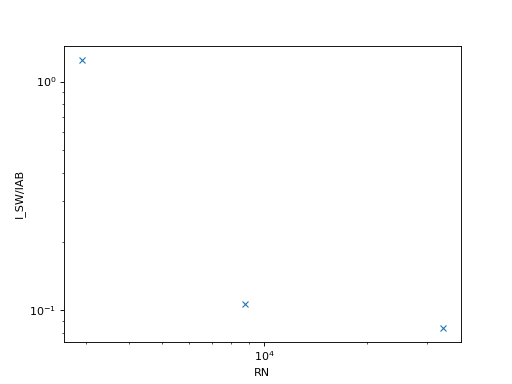

Text(0, 0.5, 'I_SW/IAB')

In [180]:
lst = Q1Dlst[Q1Dlst['#ser']<=2]
pst = toJJplst(lst)[0]
RN = lst['RN/al'].astype(float)/lst['#ser'].astype(float)*lst['#par'].astype(float)
Iratio = lst['ISW'].astype(float)/pst['I_AB'].astype(float)*1e9

f,ax = plt.subplots()
ax.plot(RN,Iratio,marker='x', ls = 'None')
ax.set_xscale('log')
ax.set_xlabel('RN')
ax.set_yscale('log')
ax.set_ylabel('I_SW/IAB')

In [181]:
lst

Device      Vo/al    RN/al        ISW      R0ZF       R0FF  #ser  \
59B0N1  59B0N1  2.178e-04   8756.0  3.900e-09    1314.0  1.650e+09     2   
79N6      79N6  1.645e-04   1458.0  1.370e-07       2.2        NaN     1   
78N5      78N5  9.685e-05  16700.0  8.000e-10  100000.0        NaN     1   

        #par Mat.    BT dsgn     J size  
59B0N1     2   Al  0.03  Fin  4.000e-14  
79N6       2   Al  0.03  x_L  3.740e-12  
78N5       2   Al  0.03  x_L  4.000e-12

In [183]:
pst

Device  RN_JJ                Rs/JJ                I_AB  \
59B0N1  59B0N1  8.756  0.43779999999999997  36.541825959217334   
79N6      79N6  2.916   11.187803780652763  109.72572980072256   
78N5      78N5   33.4               136.94   9.579647547871467   

                         EJ              C_JJQP                    EC  \
59B0N1   0.8710495910300041  2.0000000000000004   0.46481234851830844   
79N6     2.6155384839021663  186.99999999999997  0.004971255064366936   
78N5    0.22835060536103938               200.0  0.004648123485183085   

                $\omega_p$                   Q                beta  \
59B0N1     37.500095368107   4.126178284686472  17.025347237018195   
79N6    6.7202539280438165  11.512368493685434  132.53462833440102   
78N5    1.9200476874937638   40.29381149994416  1623.5912451930324   

                     EJ/EC  
59B0N1   1.873981174998182  
79N6     526.1324253204942  
78N5    49.127482539772686

In [182]:
lst['RN/al']/lst['#ser']

59B0N1     4378.0
79N6       1458.0
78N5      16700.0
dtype: float64

<IPython.core.display.Javascript object>


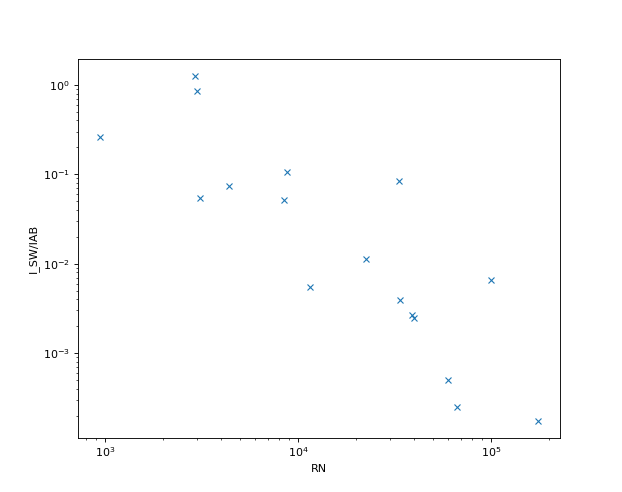

Text(0, 0.5, 'I_SW/IAB')

In [184]:
lst = Q1Dlst
pst = toJJplst(lst)[0]
RN = lst['RN/al'].astype(float)/lst['#ser'].astype(float)*lst['#par'].astype(float)
Iratio = lst['ISW'].astype(float)/pst['I_AB'].astype(float)*1e9

f,ax = plt.subplots()
ax.plot(RN,Iratio,marker='x', ls = 'None')
ax.set_xscale('log')
ax.set_xlabel('RN')
ax.set_yscale('log')
ax.set_ylabel('I_SW/IAB')

In [639]:
key =    [ 'Device' ,  'Vo/al', 'RN/al',   'ISW' , 'R0ZF' , 'R0FF' , '#ser', '#par', 'Mat.',  'BT' , 'J size',  'EC']
unit=    ['       ' ,      'V',   'ohm',     'A' ,  'ohm' ,  'ohm' ,   'ea',   'ea',     '',   'K' ,    'm^2',   'K']
lst =   [['PhC_01'  ,   np.nan,  289800,   11e-12,  np.nan,  np.nan,    63 ,      2,   'Al', 0.030 , 0.07e-12, 0.267],
         ['PRB_90'  ,     1e-5,   30000,  1.1e-9 ,    12e3,  np.nan,     1 ,      1,   'Nb', 1.270 ,  0.4e-12, 0.046],
         ['IEE_87'  ,   np.nan,   66670,  1.3e-9 ,     6e3,  np.nan,     1 ,      1,   'Nb', 0.010 ,  0.2e-12, 0.092],
         ['PRB_86'  ,   np.nan,     168,  0.5e-6 ,  np.nan,  np.nan,     1 ,      1,   'Sn', 1.710 ,  3.0e-12, 0.006],
         ['PRL_87'  ,   np.nan,   70000,  1.2e-9 ,     1e3,  np.nan,     1 ,      1,   'Sn', 0.023 , 0.02e-12, 0.928],
         ['JLT_11'  ,   np.nan,     828,  290e-9 ,  np.nan,  np.nan,     1 ,      1,   'Al', 0.050 ,   65e-12,2.8e-4],
         ['STh_13'  ,   np.nan,    2700,   10e-9 ,     130,  np.nan,     1 ,      1,   'Al', 0.017 ,  0.4e-12, 0.046],
         ['PRB_89'  ,   np.nan,  140000,   10e-9 ,    7000,  np.nan,     1 ,      1,   'Sn', 0.020 , 0.02e-12, 0.928],                
         ['NJP_13'  ,   np.nan,  235950,  np.nan ,     400,  np.nan,  2888 ,      1,   'Al', 0.020 ,0.018e-12, 1.030],
         ['PRL_01'  ,   np.nan,   17000,  np.nan ,     400,  np.nan,     1 ,      1,   'Al', 0.020 , 0.04e-12, 0.464],
         ['JPc_03'  ,   np.nan,  561000,   50e-9 ,     357,  np.nan,   255 ,      1,  'Al2', 0.040 , 0.07e-12, 0.265],
         ['PhB_00'  ,   np.nan, 1377000,  np.nan ,    1000,  np.nan,   255 ,      1,  'Al2', 0.040 , 0.07e-12, 0.265],
         ['PRL_06'  ,   np.nan,    2800,  np.nan ,     1e7,  np.nan,     1 ,      1,  'Al2', 0.050 ,0.036e-12, 0.522],
         ['PRL_05'  ,   np.nan,    1300,7.285e-8 ,  np.nan,  np.nan,     1 ,      2,  'Al2', 0.038 ,    1e-12, 0.019],
         ['PRL_05'  ,   np.nan, 1087750,  np.nan ,  np.nan,  np.nan,   250 ,      1,   'Al', 0.020 ,  200e-12, 0.946],
         
        ]
    
LTRlst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
LTRuni =   dict(zip(key, unit))

Tcdic = {'Nb' : 9,
         'Al' : 1.34,
         'Sn' : 3.72,
        'Al2' : 1.12}
lst = []
l = len(LTRlst['Device'])
for i in range(0,l):
    JJwidthUM = np.sqrt(LTRlst.iloc[i]['J size']*1e12)
    JJlpd = JJpar(  RN = LTRlst.iloc[i]['RN/al'], JJwidthUM=JJwidthUM, metalTHK=250E-10, Tc = Tcdic[LTRlst['Mat.'][i]], 
                  Nser = LTRlst.iloc[i]['#ser'] , Npar = LTRlst.iloc[i]['#par'])[0]
    JJlpd = np.flip(JJlpd.values[0]).tolist()
    JJlpd += [LTRlst.iloc[i]['Device']]
    JJlpd = np.flip(np.asarray(JJlpd))
    lst.append(JJlpd)
 
key =    [ 'Device' ,  'RN_JJ', 'Rs/JJ',   'I_AB' , 'EJ' , 'C_JJQP' , 'EC', '$\omega_p$', 'Q',  'beta' , 'EJ/EC']
unit=    ['       ' ,   'kohm',  'kohm',     'nA' ,  'K' ,     'fF' ,  'K',        'GHz',  '',      '' ,      '']
JJlplst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
JJlpuni =   dict(zip(key, unit))
JJlplst

Device    RN_JJ                  Rs/JJ                I_AB  \
PhC_01  PhC_01    289.8     0.7657045603089713  34.778285662924674   
PRB_90  PRB_90     30.0     12.948683298050513   71.63288688781499   
IEE_87  IEE_87    66.67      14.82478652059911   32.23318744014473   
PRB_86  PRB_86    0.168     0.5185492267835784   5287.189270291106   
PRL_87  PRL_87     70.0      1.894974746830583  12.689254248698656   
JLT_11  JLT_11    0.828     54.153777470779545  386.42539625471863   
STh_13  STh_13      2.7     1.1653814968245462  118.50378818478036   
PRB_89  PRB_89    140.0      3.789949493661166   6.344627124349328   
NJP_13  NJP_13   235.95  0.0020186636834741084  3916.2752225032573   
PRL_01  PRL_01     17.0                   0.85     18.821189888171   
JPc_03  JPc_03    561.0    0.18310326442171052     121.55883835508   
PhB_00  PhB_00   1377.0      0.449435285398744   49.52397118169926   
PRL_06  PRL_06      2.8    0.12736313234541438      95.51051585042   
PRL_05  PRL_05      1.3     2.7299999999999995  102.85747860814462   
PRL_05  PRL_05  1087.75      873.2766216049426   73.53717032840888   

                         EJ              C_JJQP                     EC  \
PhC_01   0.8290119803324691   3.500000000000001     0.2656070562961762   
PRB_90   1.7075172132221004  20.000000000000004    0.04648123485183085   
IEE_87   0.7683443287335083   9.999999999999998    0.09296246970366172   
PRB_86   126.03103240448837               150.0   0.006197497980244114   
PRL_87    0.302474477770772                 1.0     0.9296246970366171   
JLT_11    9.211244225916325  3249.9999999999995  0.0002860383683189591   
STh_13   2.8247815626143393  20.000000000000004    0.04648123485183085   
PRB_89    0.151237238885386                 1.0     0.9296246970366171   
NJP_13    93.35247600187148  0.9000000000000002     1.0329163300406854   
PRL_01  0.44864177759168916  2.0000000000000004    0.46481234851830844   
JPc_03   2.8976049678920495   3.500000000000001     0.2656070562961762   
PhB_00    1.180505727659724   3.500000000000001     0.2656070562961762   
PRL_06   2.2766896176294678  1.7999999999999996     0.5164581650203429   
PRL_05     2.45181958821635                50.0    0.01859249394073234   
PRL_05    1.752909726283318  10000.000000000002  9.296246970366169e-05   

                $\omega_p$                   Q                beta  \
PhC_01  27.654913896598774  176.24573023235592   31062.55742513638   
PRB_90   16.60326412903218   62.59283113605412  3917.8625096265864   
IEE_87  15.750845606115904   65.98028664139065   4353.398225280073   
PRB_86   52.08576496233212   8.247065730738269   68.01409316711754   
PRL_87   31.25145897739927  13.745109551230449  188.92803657532653   
JLT_11  3.0251255079982973   51.14897837212046  2616.2179885116466   
STh_13  21.355186401291544   7.245644045148523   52.49935762899624   
PRB_89  22.098118564892232  19.438520343654066    377.856073150653   
NJP_13   578.7188059735219   772.1647198324775   596238.3545539685   
PRL_01  26.912917987590905   5.749360929680654   33.05515109973839   
JPc_03  51.702494376345754   637.8554491351172  406859.57399136206   
PhB_00  33.000913103022036   999.3274328160903   998655.3179787975   
PRL_06   63.90599342882125  2.0237273227215313   4.095472276729657   
PRL_05  12.583028564290537  5.1389975126731375  26.409295435260695   
PRL_05  0.7523253655698887   51417.93905365161   2643804456.525031   

                      EJ/EC  
PhC_01    3.121197124401864  
PRB_90    36.73562500362107  
IEE_87    8.265102370696201  
PRB_86   20335.792412718805  
PRL_87  0.32537267860350083  
JLT_11   32202.827473987472  
STh_13    60.77251543808918  
PRB_89  0.16268633930175042  
NJP_13    90.37757782200464  
PRL_01   0.9652105393108282  
JPc_03   10.909367425317775  
PhB_00    4.444557099203538  
PRL_06    4.408275000434528  
PRL_05   131.87147437197308  
PRL_05    18856.10108973119

In [749]:
key =    [    'Device' ,    'BT',  'EJ',  'EC']
unit=    ['          ' ,     'K',   'K',   'K']
lst =   [['Charge Qbit',   0.030, 0.601, 1.357],
         ['Flux Qbit'  ,   0.035, 4.799, 0.576],
         ['Tansmon'    ,   0.035, 0.837, 0.019],
         ['Fluxonium'  ,   0.035, 0.144, 0.040],
         ['Bifluxon'   ,   0.035, 1.305, 0.370]]
Qbtlst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
Qbtuni =   dict(zip(key, unit))
Qbtlst

Device     BT     EJ     EC
Charge Qbit  Charge Qbit   0.03  0.601   1.36
Flux Qbit      Flux Qbit  0.035    4.8  0.576
Tansmon          Tansmon  0.035  0.837  0.019
Fluxonium      Fluxonium  0.035  0.144   0.04
Bifluxon        Bifluxon  0.035    1.3   0.37

<IPython.core.display.Javascript object>


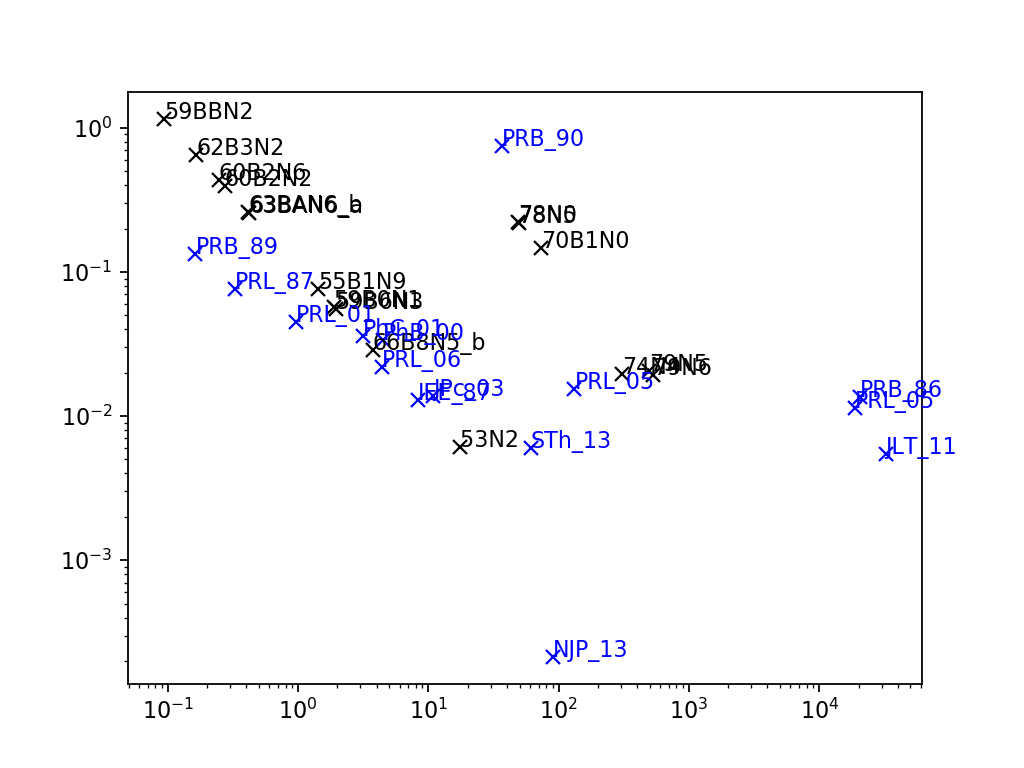

In [650]:
f,ax = plt.subplots()


EJ = JJplst['EJ'].astype(float)
EC = JJplst['EC'].astype(float)
T = [50e-3]*len(JJplst['EJ'])

ax.plot(EJ/EC, T/EJ, marker = 'x', ls = 'None', color = 'black')
n = JJplst['Device']
for i, txt in enumerate(n):
    ax.annotate(txt, ((EJ/EC)[i], (T/EJ)[i]))
    

EJ = JJlplst['EJ'].astype(float)
EC = JJlplst['EC'].astype(float)
T = LTRlst['BT']

ax.plot(EJ/EC, T/EJ, marker = 'x', ls = 'None', color = 'blue')
n = JJlplst['Device']
for i, txt in enumerate(n):
    ax.annotate(txt, ((EJ/EC)[i], (T/EJ)[i]), color = 'blue')
    
ax.set_xscale('log')
ax.set_yscale('log')

<IPython.core.display.Javascript object>


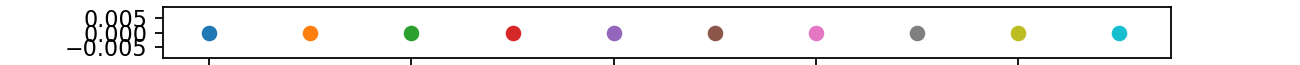

<IPython.core.display.Javascript object>


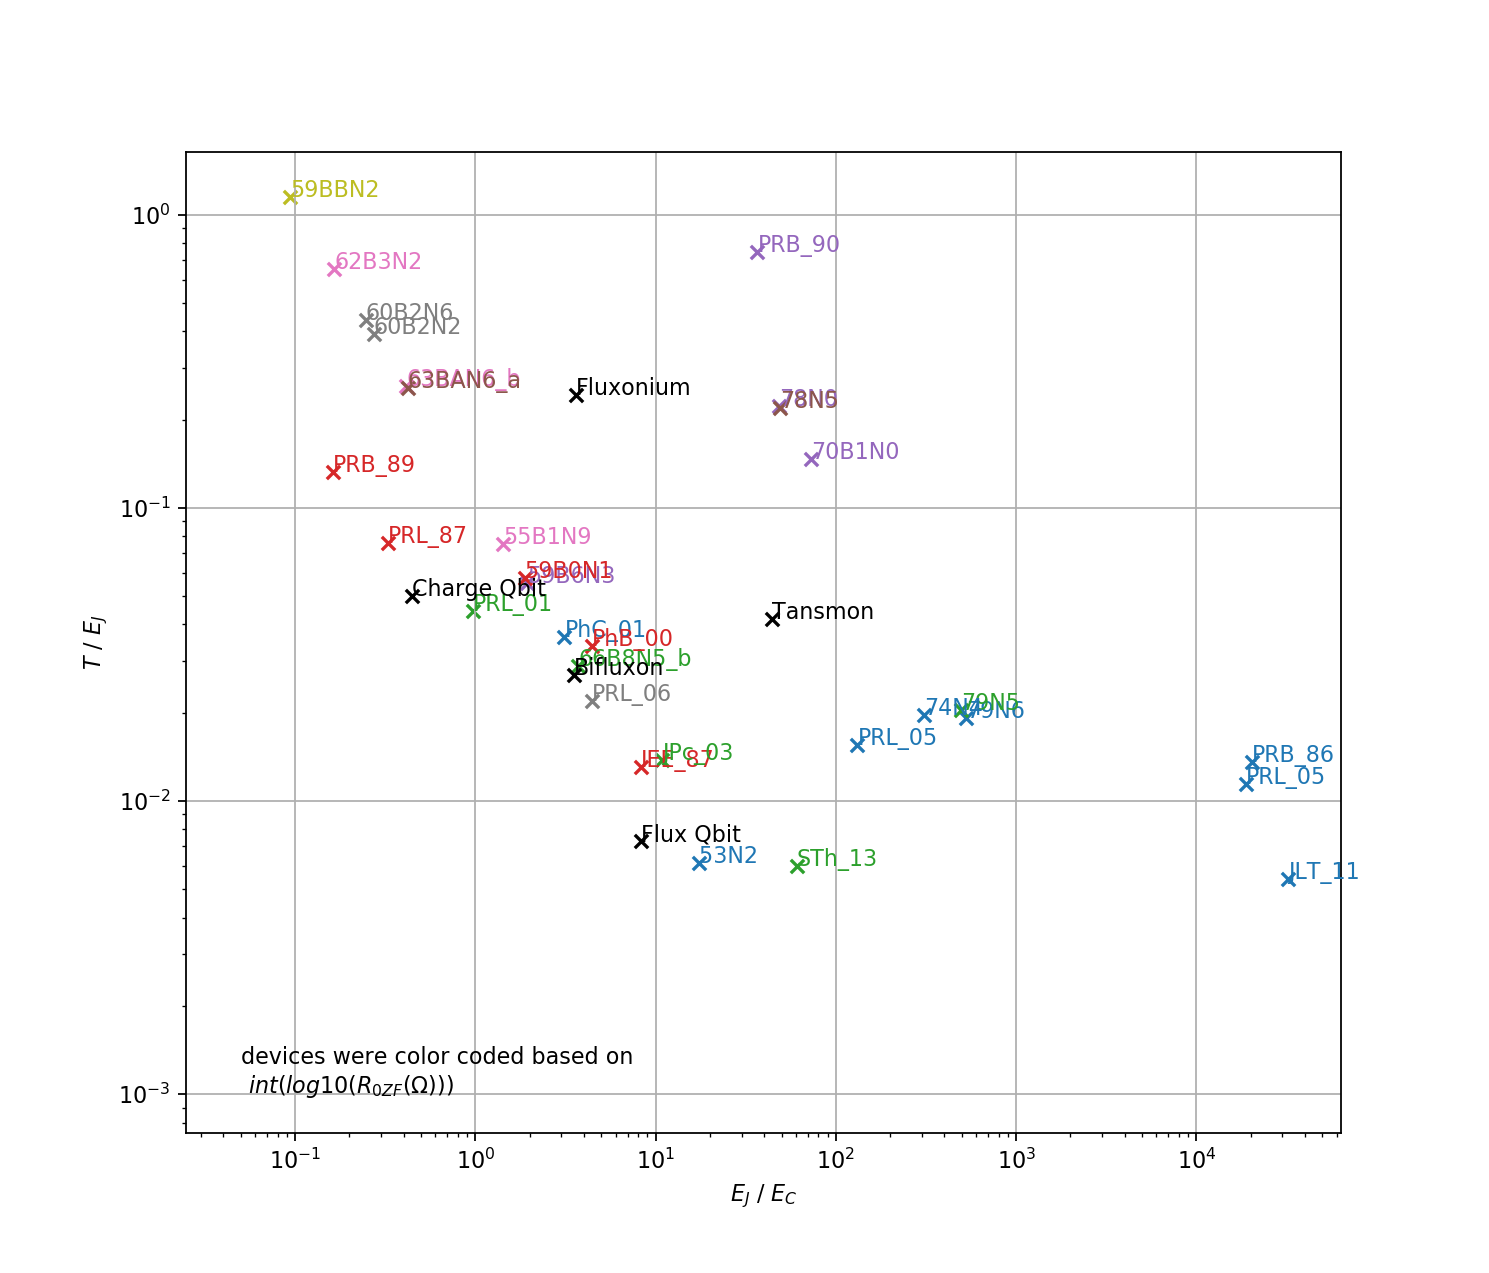

Text(0, 0.5, '$T$ / $E_J$')

In [750]:
f,ax=plt.subplots()
for i in range(10):
    ax.scatter([i], [0], color = 'C'+str(i))
    
f,ax = plt.subplots()

EJ = JJplst['EJ'].astype(float)
EC = JJplst['EC'].astype(float)
T = [50e-3]*len(JJplst['EJ'])
R0 = Q1Dlst['R0ZF']

n = JJplst['Device']
for i, txt in enumerate(n):
    if np.isfinite(R0.tolist()[i]):
        color = 'C'+ str(int(np.log10(np.abs(R0.tolist()[i]))))
    else:
        color = 'C0'
    x = [(EJ/EC)[i]]
    y = [( T/EJ)[i]]
    ax.scatter(x, y, marker = 'x', color = color)
    ax.annotate(txt, (x[0], y[0]), color = color)
    

EJ = JJlplst['EJ'].astype(float)
EC = JJlplst['EC'].astype(float)
T = LTRlst['BT']
R0 = LTRlst['R0ZF']

n = JJlplst['Device']
for i, txt in enumerate(n):
    if np.isfinite(R0.tolist()[i]):
        color = 'C'+ str(int(np.log10(np.abs(R0.tolist()[i]))))
    else:
        color = 'C0'
    x = [(EJ/EC)[i]]
    y = [( T/EJ)[i]]
    ax.scatter(x, y, marker = 'x', color = color, label = 'R0:1E{}'.format(color[1:2]))
    ax.annotate(txt, (x[0], y[0]), color = color)    

EJ = Qbtlst['EJ'].astype(float)
EC = Qbtlst['EC'].astype(float)
T = Qbtlst['BT'].astype(float)
n = Qbtlst['Device']
for i, txt in enumerate(n):
    x = [(EJ/EC)[i]]
    y = [( T/EJ)[i]]
    ax.scatter(x, y, marker = 'x', color = 'black')
    ax.annotate(txt, (x[0], y[0]), color = 'black')    

ax.text(0.05,0.001,'devices were color coded based on \n $int(log10(R_{0ZF}(\Omega)))$')
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid('on')

ax.set_xlabel('$E_J$ / $E_C$')
ax.set_ylabel('$T$ / $E_J$')

<IPython.core.display.Javascript object>


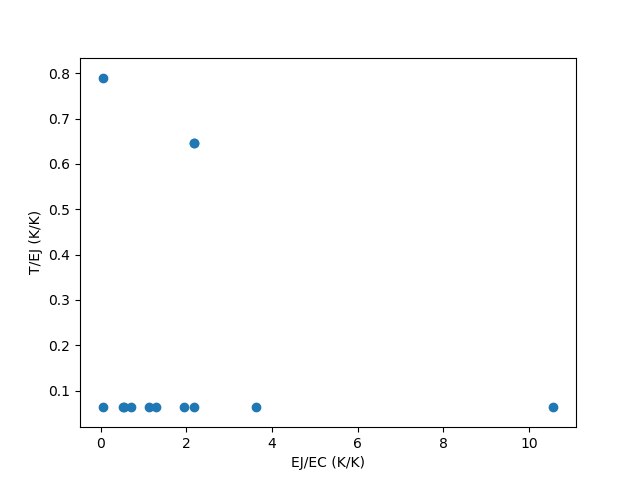

Text(0.5, 0, 'EJ/EC (K/K)')

In [37]:
ToEJlst  = np.array([])
EJoEClst = np.array([])

for devid in Q1Dlst.loc[:]['Device']:
    ToEJ  = Q1Dlst.loc[devid]['T8']/Q1Dlst.loc[devid]['EJ/JJ']
    ToEJlst = np.append(ToEJlst, ToEJ)
    EJoEC = Q1Dlst.loc[devid]['EJ/JJ']/Q1Dlst.loc[devid]['ECJ']
    EJoEClst= np.append(EJoEClst, EJoEC)

f,ax=plt.subplots()
ax.scatter(EJoEClst, ToEJlst)
ax.set_ylabel('T/EJ ({}/{})'.format(Q1Duni['T8'],Q1Duni['EJ/JJ']))
ax.set_xlabel('EJ/EC ({}/{})'.format(Q1Duni['EJ/JJ'],Q1Duni['ECJ']))

# for i, v in enumerate(devlst):
#     ax.annotate(v, (EJoEClst[i], ToEJlst[i]))

#### <span class="mark">Dome</span>

In [3]:
pd.set_option("display.precision", 3)

In [5]:
# Dome from literature
key =  [ '$T_C$', '$\\rho$']
# lst = [[    2.4  ,  100e-8 ],
#        [    3.0  ,  500e-8 ],
#        [    2.5  , 2000e-8 ],
#        [    2.7  ,  180e-8 ],
#        [    2.8  ,  350e-8 ],
#        [    2.2  , 3200e-8 ]]

lst = [[    1.3  ,   10e-8 ],
       [    2.4  ,  100e-8 ],
       [    2.6  ,  180e-8 ],
       [    2.9  ,  350e-8 ],
       [    3.0  ,  500e-8 ],
       [    3.1  ,  700e-8 ],
       [   3.08  , 1000e-8 ],
       [   2.93  , 1300e-8 ],
       [   2.60  , 2000e-8 ],
       [    2.2  , 3200e-8 ],
       [    1.2  ,12000e-8 ]]

domeLitDF =   pd.DataFrame(  data  = list(zip(*lst)), 
#                            columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                             index = key ).transpose()

# with open(r'dataframes/domeLitDF.csv','w') as f:
#     domeLitDF.to_csv(f)
# with open(r'dataframes/domeLitDF.csv','r') as f:
#     domeLitDF2 = pd.read_csv(f)
#     print(domeLitDF2)

In [4]:
# Dome for wet-grAl
key = ['Device'      ,    'THK','$w_{re}$','$l_{re}$',     '$R$', '$T_C$', '$I_C$', 'ion',  'dose', '$l_i$', 'tilt','$R_{af}$','$R_{1w}$','$T_{C,1w}$']
unit= [''            ,      'm',       'm',       'm','$\Omega$',     'K',     'A',    '','#/cm^2',     'm',  'deg','$\Omega$','$\Omega$',         'K']
lst =[
# old device
      ['ALOX06'       ,  150e-9,     5e-6 ,  52.7e-6 ,    13490 ,   1.39 ,5.65e-6 ,np.nan, np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX05B_10um' ,   35e-9,  9.97e-6 ,  35.4e-6 ,     4260 ,    1.7 ,0.41e-6 ,np.nan, np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX05B_2um'  ,   28e-9,  1.94e-6 ,    17e-6 ,    13140 ,    1.7 , 3.3e-6 ,np.nan, np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX05B_.5um' ,   20e-9,   0.8e-6 ,    17e-6 ,   105190 ,   1.75 ,12.5e-6 ,np.nan, np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX03'       ,  140e-9,   5.0e-6 ,    18e-6 ,     3120 ,    1.2 , 4.6e-6 ,np.nan, np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX07_10um'  ,   40e-9,    10e-6 ,    18e-6 ,     1390 ,   1.73 ,14.5e-6 ,np.nan, np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['Q1D066B8'     ,   40e-9,   0.7e-6 ,    18e-6 ,    29250 ,   1.80 ,12.5e-6 ,np.nan, np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['Q1D067B8'     ,   40e-9,   0.7e-6 ,    18e-6 ,    24560 ,   2.00 ,12.5e-6 ,np.nan, np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
# HIM grAl device
      ['D335bN8_Up'   ,   40e-9,  0.65e-6 ,    16e-6 ,     5700 ,   2.03 , np.nan ,  'He',   1e12 ,  13e-6 ,     0 ,     7330 ,     3300 ,       1.97 ],
      ['D335bN8_Mid'  ,   40e-9,  0.65e-6 ,    16e-6 ,     5800 ,   1.95 , np.nan ,  'He',   1e16 ,  13e-6 ,     0 ,    417.0 ,     4700 ,       1.98 ],
      ['D335bN8_Dow'  ,   40e-9,  0.65e-6 ,    16e-6 ,     5600 ,   1.85 , np.nan ,  'He',   5e16 ,  13e-6 ,     0 ,     4890 ,     5900 ,       1.97 ],
      ['D276bN8_Up'   ,   40e-9,  0.65e-6 ,    16e-6 ,     3507 , np.nan , np.nan ,  'He',   1e12 ,  13e-6 ,     0 ,     3970 ,     3120 ,     np.nan ],
      ['D276bN8_Mid'  ,   40e-9,  0.65e-6 ,    16e-6 ,     3500 ,   2.02 , np.nan ,  'He',   1e16 ,  13e-6 ,     0 ,    447.0 ,     2740 ,     np.nan ],
      ['D276bN8_Dow'  ,   40e-9,  0.65e-6 ,    16e-6 ,     3400 ,   1.95 , np.nan ,  'He',   5e16 ,  13e-6 ,     0 ,     2850 ,     1980 ,     np.nan ],
      ['D06N5_Mid'    ,   55e-9,  7.05e-6 ,  11.8e-6 ,     1400 ,   1.87 , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['D06N7_Mid'    ,   23e-9,  0.47e-6 ,  16.4e-6 ,    78900 ,   1.78 , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
# HIM pure Al device
      ['SiOx002N1_Mid',  np.nan,   np.nan ,   np.nan ,   np.nan , np.nan , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N2_Mid',  np.nan,   np.nan ,   np.nan ,   np.nan , np.nan , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N3_Mid',   40e-9,  1.51e-6 ,  17.9e-6 ,     52.8 , np.nan , np.nan ,  'He',   5e17 ,  13e-6 ,     0 ,   63.32  ,   np.nan ,     np.nan ],
      ['SiOx002N4_Mid',   48e-9,  3.06e-6 ,  12.2e-6 ,     18.0 , np.nan , np.nan ,  'He',   1e17 ,   8e-6 ,     0 ,    18.6  ,   np.nan ,     np.nan ],
      ['SiOx002N5_Mid',   55e-9,  7.05e-6 ,  11.8e-6 ,     5.78 , np.nan , np.nan ,  'He',   1e18 , 8.2e-6 ,    35 ,   8.713  ,   np.nan ,     np.nan ],
      ['SiOx002N6_Mid',  np.nan,  12.3e-6 ,  11.9e-6 ,     2.86 , np.nan , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N7_Mid',  np.nan,   np.nan ,   np.nan ,   np.nan , np.nan , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N8_Mid',   44e-9,  1.48e-6 ,  15.9e-6 ,    53.70 , np.nan , np.nan ,  'He',   5e16 ,   8e-6 ,     0 ,    47.9  ,   np.nan ,     np.nan ],
      ['SiOx002N9_Mid',  np.nan,  12.4e-6 ,  12.0e-6 ,     2.88 , np.nan , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N0_Mid',   44e-9,  0.99e-6 ,  16.0e-6 ,     72.0 , np.nan , np.nan ,  'He',   1e18 ,  13e-6 ,     0 ,   177.6  ,   np.nan ,     np.nan ],  

      ['SiOx003N1_Mid', 17.8e-9,  0.37e-6 ,  16.3e-6 ,     1750 , np.nan , np.nan ,  'He',   1e18 ,10.7e-6 ,    35 ,     1775 ,     1779 ,     np.nan ],
      ['SiOx003N2_Mid',  np.nan,   np.nan ,   np.nan ,   np.nan , np.nan , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N3_Mid',   40e-9,  1.51e-6 ,  15.8e-6 ,    54.50 , np.nan , np.nan ,  'He',   5e18 ,  13e-6 ,     0 ,    121.8 ,   117.51 ,     np.nan ],
      ['SiOx003N4_Mid',   48e-9,  2.95e-6 ,  12.3e-6 ,     18.0 ,   1.42 , np.nan ,  'He',   1e17 , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N5_Mid',   55e-9,  7.05e-6 ,  11.8e-6 ,     5.77 , np.nan , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N6_Mid',   56e-9,  12.3e-6 ,  12.3e-6 ,     2.90 ,   1.43 , np.nan ,  'Ne',   5e15 ,   4e-6 ,     0 ,    3.175 ,   np.nan ,     np.nan ],
      ['SiOx003N7_Mid',   23e-9,  0.47e-6 ,  16.4e-6 ,     1050 , np.nan , np.nan ,  'Ne',   1e16 ,  13e-6 ,     0 ,     1524 ,   np.nan ,     np.nan ],
      ['SiOx003N8_Mid',   44e-9,  1.48e-6 ,  15.9e-6 ,     53.7 , np.nan , np.nan ,  'He',   5e16 , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N9_Mid', 52.6e-9,  12.1e-6 ,  11.9e-6 ,     2.91 , np.nan , np.nan ,  'Ne',   1e16 ,   5e-6 ,     0 ,    3.455 ,   np.nan ,     np.nan ],
      ['SiOx003N0_Mid',  np.nan,   np.nan ,   np.nan ,      159 , np.nan , np.nan ,np.nan, np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],

      ['SiOx004N1_Upp', 43.2e-9,  0.71e-6 ,  12.0e-6 ,    62.83 , np.nan , np.nan ,  'Ne',   1e17 ,  13e-6 ,     0 ,   185.49 ,   np.nan ,     np.nan ],
      ['SiOx004N1_Mid', 36.5e-9,  0.81e-6 ,  12.0e-6 ,    65.84 , np.nan , np.nan ,  'Ne',   5e16 ,  13e-6 ,     0 ,   136.31 ,   np.nan ,     np.nan ],
      ['SiOx004N1_Low', 43.3e-9,  0.88e-6 ,  12.0e-6 ,    66.44 , np.nan , np.nan ,  'Ne',   1e16 ,  13e-6 ,     0 ,    83.52 ,   np.nan ,     np.nan ],
      ['SiOx004N5_Upp',   50e-9,  0.75e-6 ,  12.0e-6 ,    56.38 , np.nan , np.nan ,  'Ne', np.nan , np.nan ,     0 ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx004N5_Mid',   50e-9,  0.73e-6 ,  12.0e-6 ,    58.63 , np.nan , np.nan ,  'Ne', np.nan , np.nan ,     0 ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx004N5_Low',   50e-9,  0.72e-6 ,  12.0e-6 ,    61.86 , np.nan , np.nan ,  'Ne', np.nan , np.nan ,     0 ,   np.nan ,   np.nan ,     np.nan ]]

domeWetun =   dict(zip(key, unit))
domeWetDF =   pd.DataFrame(    data  = list(zip(*lst)), 
#                             columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                               index = domeWetun ).transpose()

# with open(r'dataframes/domeWetDF.csv','w') as f:
#     domeWetDF.to_csv(f)
# with open(r'dataframes/domeWetDF.csv','r') as f:
#     domeWetDF = pd.read_csv(f)
#     print(domeWetDF)
# domeWetDF['Device'] == 'SiOx003N3_Mid'
domeWetDF[domeWetDF['ion'] == 'Ne']['$R$'].tolist()

[2.9, 1050, 2.91, 62.83, 65.84, 66.44, 56.38, 58.63, 61.86]

In [42]:
# Dome for dry-grAl
key = ['Device'       , 'THK','$w_{re}$','$l_{re}$',     '$R$', '$T_C$', '$I_C$',   'dose','$R_{af}$','$R_{co}$','$T_{C,af}$']
unit= [''             ,   'm',       'm',       'm','$\Omega$',     'K',     'A', '#/cm^2','$\Omega$','$\Omega$',         'K']
lst =[         
      ['D06N5_Mid'    , 55e-9,  7.05e-6 ,  11.8e-6 ,     1400 ,   1.87 , np.nan ,  np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['D06N7_Mid'    , 23e-9,  0.47e-6 ,  16.4e-6 ,    78900 , np.nan , np.nan ,  np.nan ,   np.nan ,   np.nan ,     np.nan ]
     ]

domeDryun =   dict(zip(key, unit))
domeDryDF =   pd.DataFrame(    data  = list(zip(*lst)), 
                             columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                               index = domeDryun ).transpose()

# with open(r'dataframes/domeDryDF.csv','w') as f:
#     domeDryDF.to_csv(f)
# with open(r'dataframes/domeDryDF.csv','r') as f:
#     domeDryDF = pd.read_csv(f)
#     print(domeDryDF)

<IPython.core.display.Javascript object>


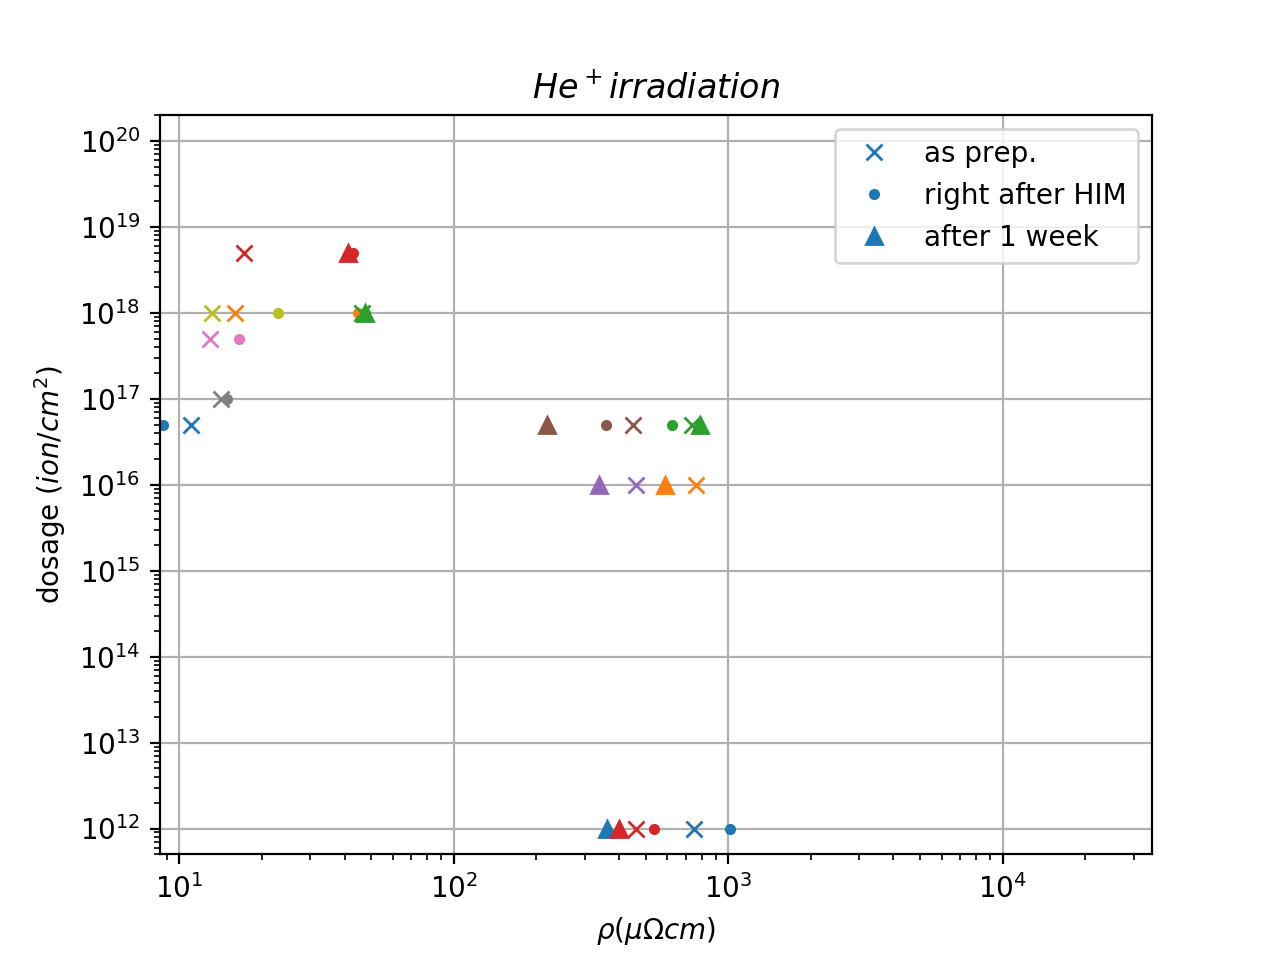

In [5]:
dWDF = domeWetDF[domeWetDF['ion'] == 'He']
rho    = (dWDF['$R$']*dWDF['$l_i$']/dWDF['$l_{re}$'])                                        /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$'] 
rho_af = (dWDF['$R_{af}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']
rho_1w = (dWDF['$R_{1w}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']

plt.close('all')
f,ax=plt.subplots()
label = [['as prep.','right after HIM','after 1 week']]
for i,v in enumerate(dWDF.index.tolist()):#
    label.append([None,None,None])#, label = label[i][0]
    ax.plot(rho[v   ]*1e8,dWDF['dose'][v], 'x', label = label[i][0], color='C{}'.format(int(i%9)))
    ax.plot(rho_af[v]*1e8,dWDF['dose'][v], '.', label = label[i][1], color='C{}'.format(int(i%9)))
    ax.plot(rho_1w[v]*1e8,dWDF['dose'][v], '^', label = label[i][2], color='C{}'.format(int(i%9)))

ax.set_xlim(8.5e-8*1e8,3.5e-4*1e8)
ax.set_ylim(5e11,2e20)
ax.set_xlabel('$\\rho (\mu\Omega cm)$')
ax.set_ylabel('dosage ($ion/cm^2)$')
ax.set_title('$He^+ irradiation$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True)
# ax.ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))
# plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


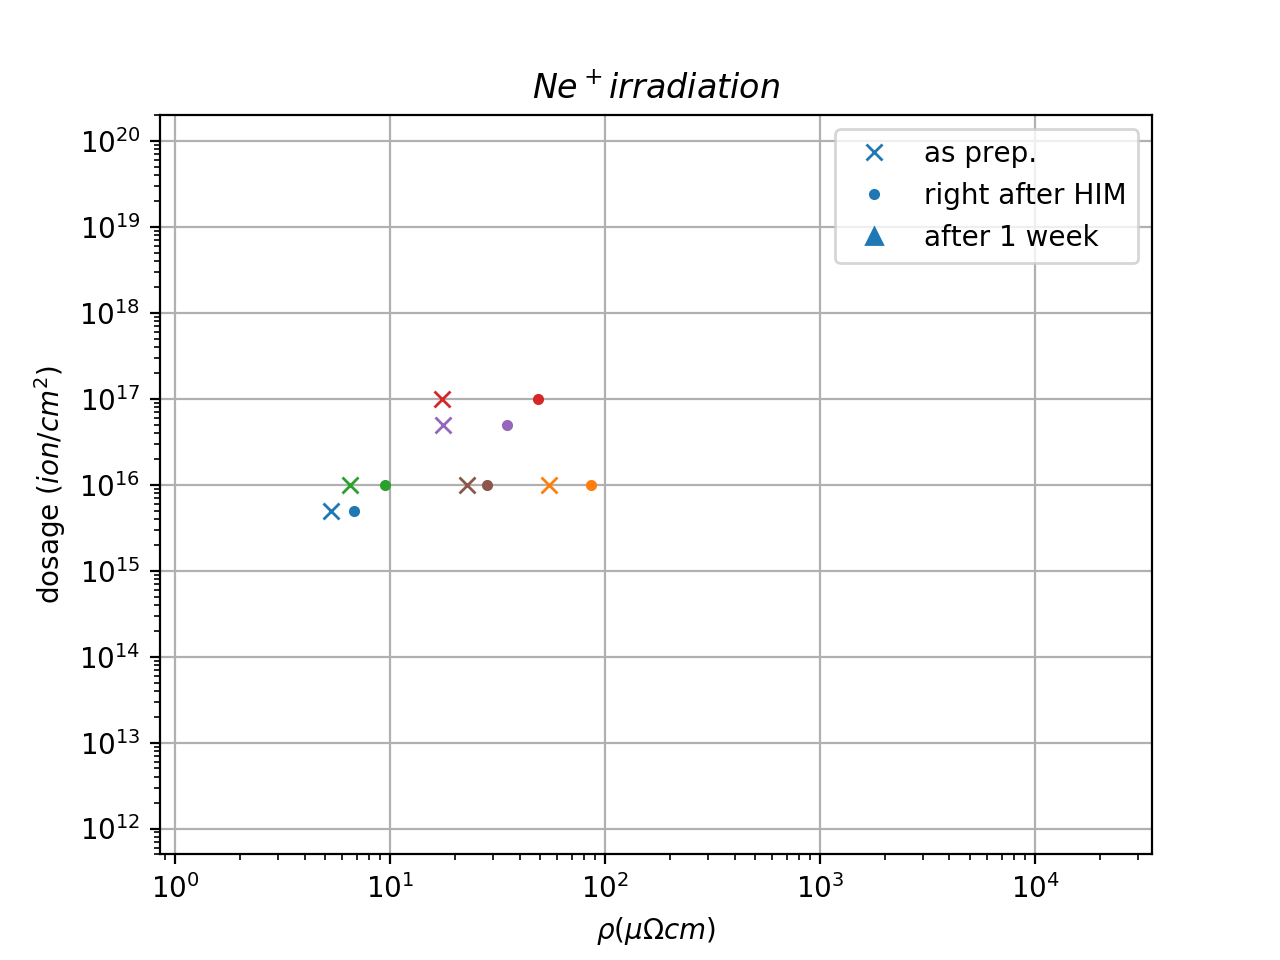

In [6]:
dWDF = domeWetDF[domeWetDF['ion'] == 'Ne']
rho    = (dWDF['$R$']*dWDF['$l_i$']/dWDF['$l_{re}$'])                                        /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$'] 
rho_af = (dWDF['$R_{af}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']
rho_1w = (dWDF['$R_{1w}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']

plt.close('all')
f,ax=plt.subplots()
label = [['as prep.','right after HIM','after 1 week']]
for i,v in enumerate(dWDF.index.tolist()):#
    label.append([None,None,None])#, label = label[i][0]
    ax.plot(rho[v   ]*1e8,dWDF['dose'][v], 'x', label = label[i][0], color='C{}'.format(int(i%9)))
    ax.plot(rho_af[v]*1e8,dWDF['dose'][v], '.', label = label[i][1], color='C{}'.format(int(i%9)))
    ax.plot(rho_1w[v]*1e8,dWDF['dose'][v], '^', label = label[i][2], color='C{}'.format(int(i%9)))

ax.set_xlim(0.1*8.5e-8*1e8,3.5e-4*1e8)
ax.set_ylim(5e11,2e20)
ax.set_xlabel('$\\rho (\mu\Omega cm)$')
ax.set_ylabel('dosage ($ion/cm^2)$')
ax.set_title('$Ne^+ irradiation$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True)
# ax.ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))
# plt.tight_layout()
plt.show()

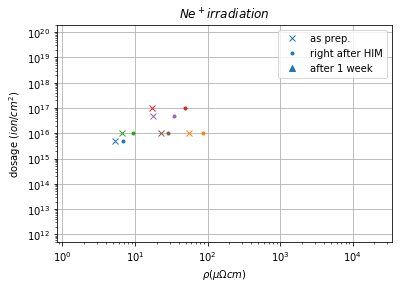

In [155]:
dWDF = domeWetDF[domeWetDF['ion'] == 'Ne']
rho    = (dWDF['$R$']*dWDF['$l_i$']/dWDF['$l_{re}$'])                                        /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$'] 
rho_af = (dWDF['$R_{af}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']
rho_1w = (dWDF['$R_{1w}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']

plt.close('all')
f,ax=plt.subplots()
label = [['as prep.','right after HIM','after 1 week']]
for i,v in enumerate(dWDF.index.tolist()):#
    label.append([None,None,None])#, label = label[i][0]
    ax.plot(rho[v   ]*1e8,dWDF['dose'][v], 'x', label = label[i][0], color='C{}'.format(int(i%9)))
    ax.plot(rho_af[v]*1e8,dWDF['dose'][v], '.', label = label[i][1], color='C{}'.format(int(i%9)))
    ax.plot(rho_1w[v]*1e8,dWDF['dose'][v], '^', label = label[i][2], color='C{}'.format(int(i%9)))

ax.set_xlim(0.1*8.5e-8*1e8,3.5e-4*1e8)
ax.set_ylim(5e11,2e20)
ax.set_xlabel('$\\rho (\mu\Omega cm)$')
ax.set_ylabel('dosage ($ion/cm^2)$')
ax.set_title('$Ne^+ irradiation$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True)
# ax.ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))
# plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


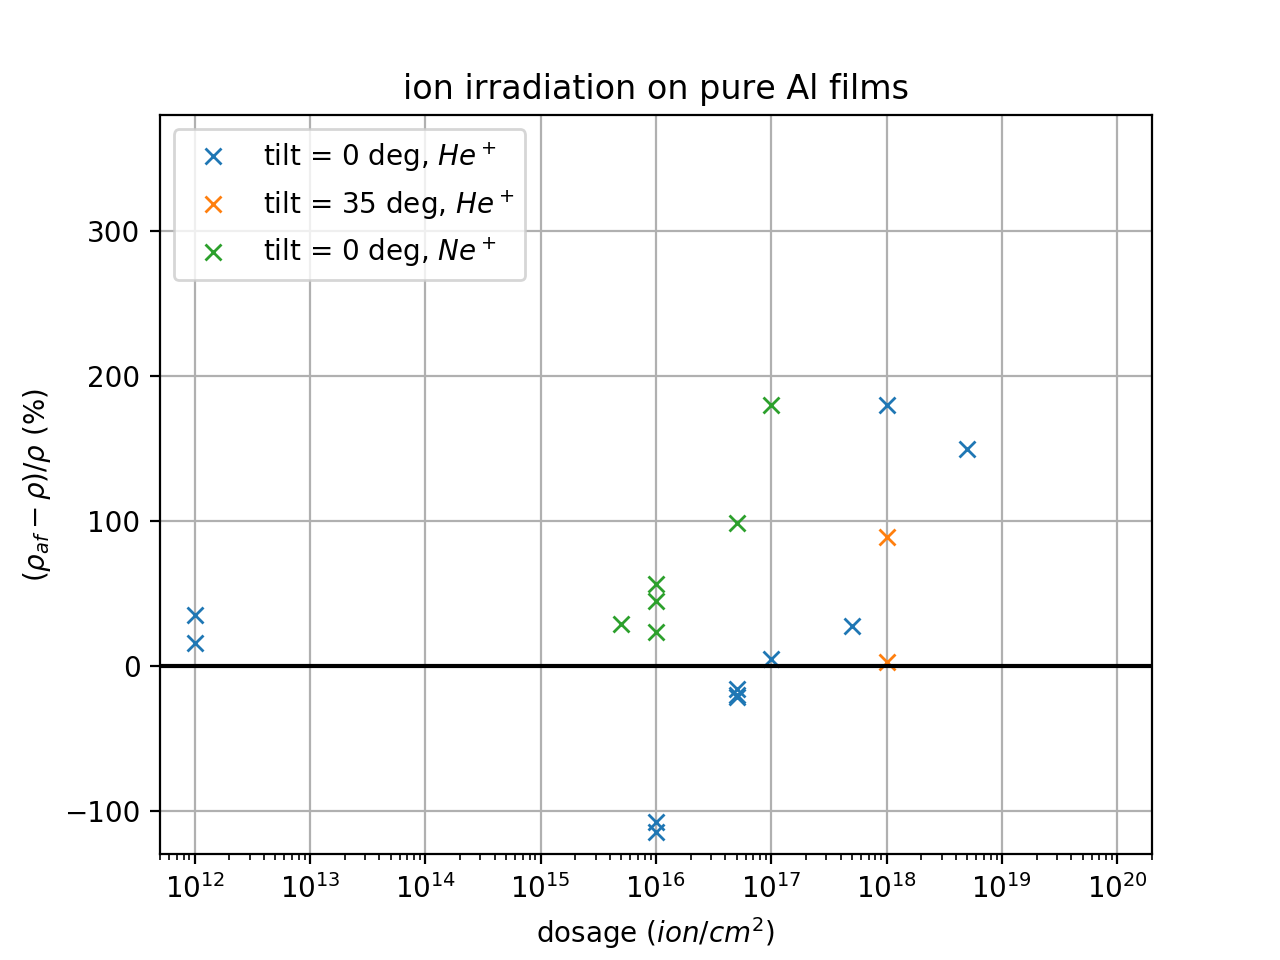

In [7]:
dWDF = domeWetDF[domeWetDF['ion'] == 'He']
rho    = (dWDF['$R$']*dWDF['$l_i$']/dWDF['$l_{re}$'])                                        /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$'] 
rho_af = (dWDF['$R_{af}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']
rho_1w = (dWDF['$R_{1w}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']

drho   = (rho_af - rho)/rho / np.cos(np.radians(dWDF['tilt'].tolist()))

plt.close('all')
f,ax=plt.subplots()

ax.plot(dWDF[dWDF[:]['tilt'] == 0]['dose'].tolist(),
    drho[dWDF[dWDF[:]['tilt'] == 0].index.tolist()]*100,
    'x', label = 'tilt = 0 deg, $He^+$')

ax.plot(dWDF[dWDF[:]['tilt'] == 35]['dose'].tolist(),
    drho[dWDF[dWDF[:]['tilt'] == 35].index.tolist()]*100,
    'x', label = 'tilt = 35 deg, $He^+$')

dWDF = domeWetDF[domeWetDF['ion'] == 'Ne']
rho    = (dWDF['$R$']*dWDF['$l_i$']/dWDF['$l_{re}$'])                                        /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$'] 
rho_af = (dWDF['$R_{af}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']
rho_1w = (dWDF['$R_{1w}$'] - dWDF['$R$']*(dWDF['$l_{re}$']-dWDF['$l_i$'])/dWDF['$l_{re}$'])  /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']

drho   = (rho_af - rho)/rho / np.cos(np.radians(dWDF['tilt'].tolist()))
ax.plot(dWDF[dWDF[:]['tilt'] == 0]['dose'].tolist(),
    drho[dWDF[dWDF[:]['tilt'] == 0].index.tolist()]*100,
    'x', label = 'tilt = 0 deg, $Ne^+$')

ax.axhline(color = 'black')

ax.set_ylim(-130,100*float(drho.max())+200)
ax.set_xlim(5e11,2e20)
ax.set_ylabel('$(\\rho_{af} - \\rho)/\\rho$ $(\%)$')
ax.set_xlabel('dosage ($ion/cm^2)$')
ax.set_title('ion irradiation on pure Al films')
ax.set_xscale('log')
ax.legend(loc = 2)
ax.grid(True)
plt.show()

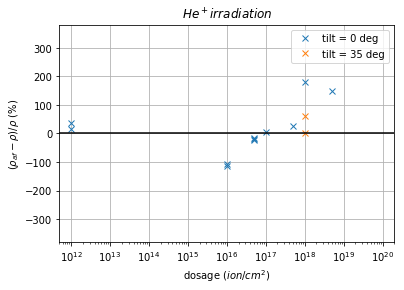

In [93]:
dWDF = domeWetDF[domeWetDF['ion'] == 'He']
rho    = dWDF['$R$']     /dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']
rho_af = dWDF['$R_{af}$']/dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']
rho_1w = dWDF['$R_{1w}$']/dWDF['$l_{re}$']*dWDF['THK']*dWDF['$w_{re}$']

drho = (rho_af - rho)/rho * dWDF['$l_{re}$']/(dWDF['$l_i$'] / np.cos(np.radians(dWDF['tilt'].tolist())))

plt.close('all')
f,ax=plt.subplots()

ax.plot(dWDF[dWDF[:]['tilt'] == 0]['dose'].tolist(),
        drho[dWDF[dWDF[:]['tilt'] == 0].index.tolist()]*100,
        'x', label = 'tilt = 0 deg')

ax.plot(dWDF[dWDF[:]['tilt'] == 35]['dose'].tolist(),
        drho[dWDF[dWDF[:]['tilt'] == 35].index.tolist()]*100,
        'x', label = 'tilt = 35 deg')

ax.axhline(color = 'black')

ax.set_ylim(-100*float(drho.max())-200,100*float(drho.max())+200)
ax.set_xlim(5e11,2e20)
ax.set_ylabel('$(\\rho_{af} - \\rho)/\\rho$ $(\%)$')
ax.set_xlabel('dosage ($ion/cm^2)$')
ax.set_title('$He^+ irradiation$')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
plt.show()

<IPython.core.display.Javascript object>


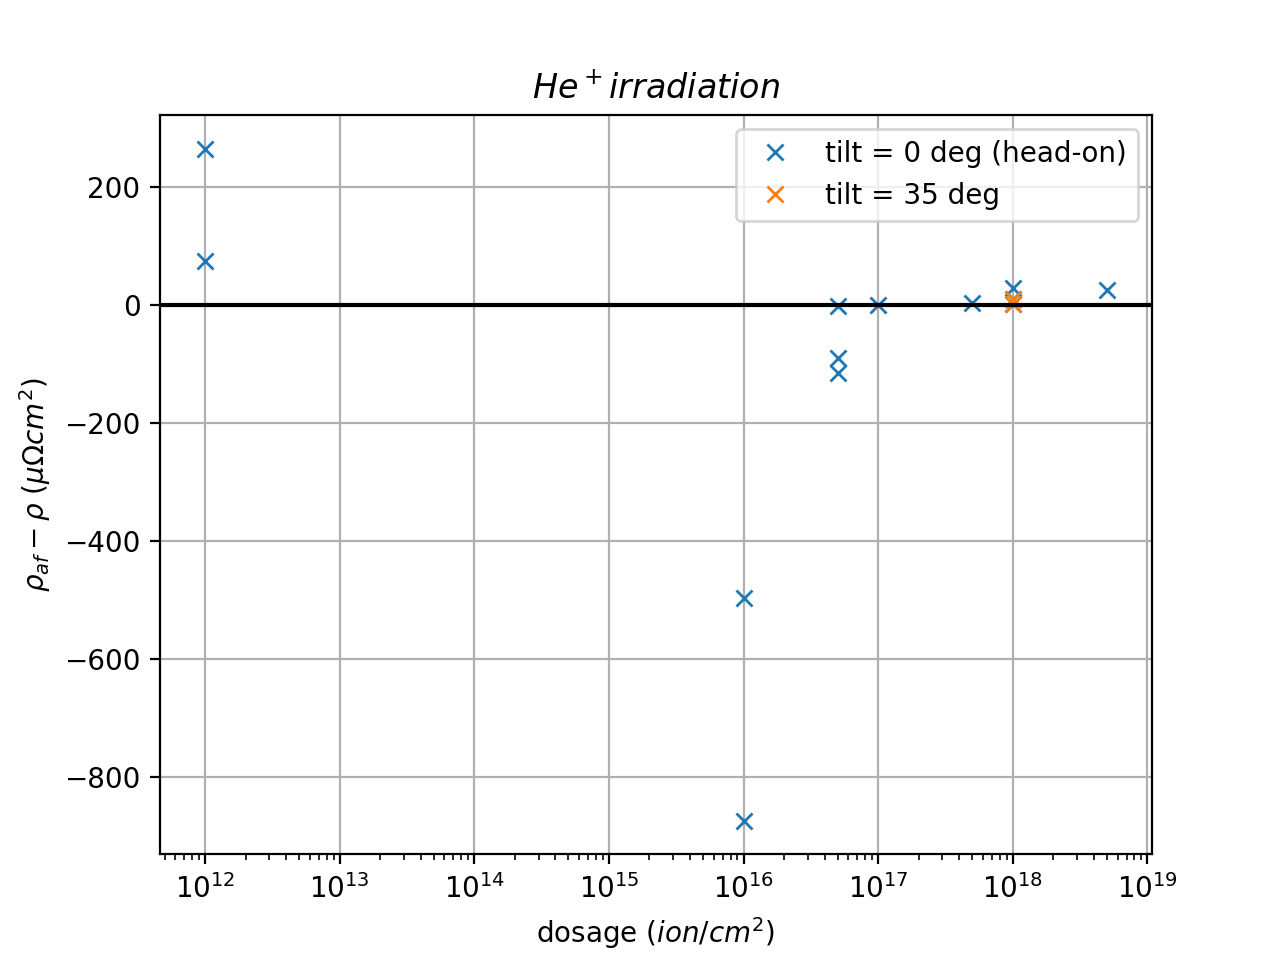

In [79]:
rho    = domeWetDF['$R$']     /domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_af = domeWetDF['$R_{af}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_1w = domeWetDF['$R_{1w}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']

drho = (rho_af - rho)*1e8# * domeWetDF['$l_{re}$']/domeWetDF['$l_i$']

plt.close('all')
f,ax=plt.subplots()
ax.plot(domeWetDF['dose'],drho, 'x', label = 'tilt = 0 deg (head-on)')
ax.plot(domeWetDF['dose'][20],drho[20], 'x', label = 'tilt = 35 deg')
ax.plot(domeWetDF['dose'][26],drho[26], 'x', color = 'C1')
ax.axhline(color = 'black')

# ax.set_ylim(-100*float(drho.max())-200,100*float(drho.max())+200)
# ax.set_xlim(5e11,2e20)
ax.set_ylabel('$\\rho_{af} - \\rho$ $(\mu\Omega cm^2)$')
ax.set_xlabel('dosage ($ion/cm^2)$')
ax.set_title('$He^+ irradiation$')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
plt.show()

<IPython.core.display.Javascript object>


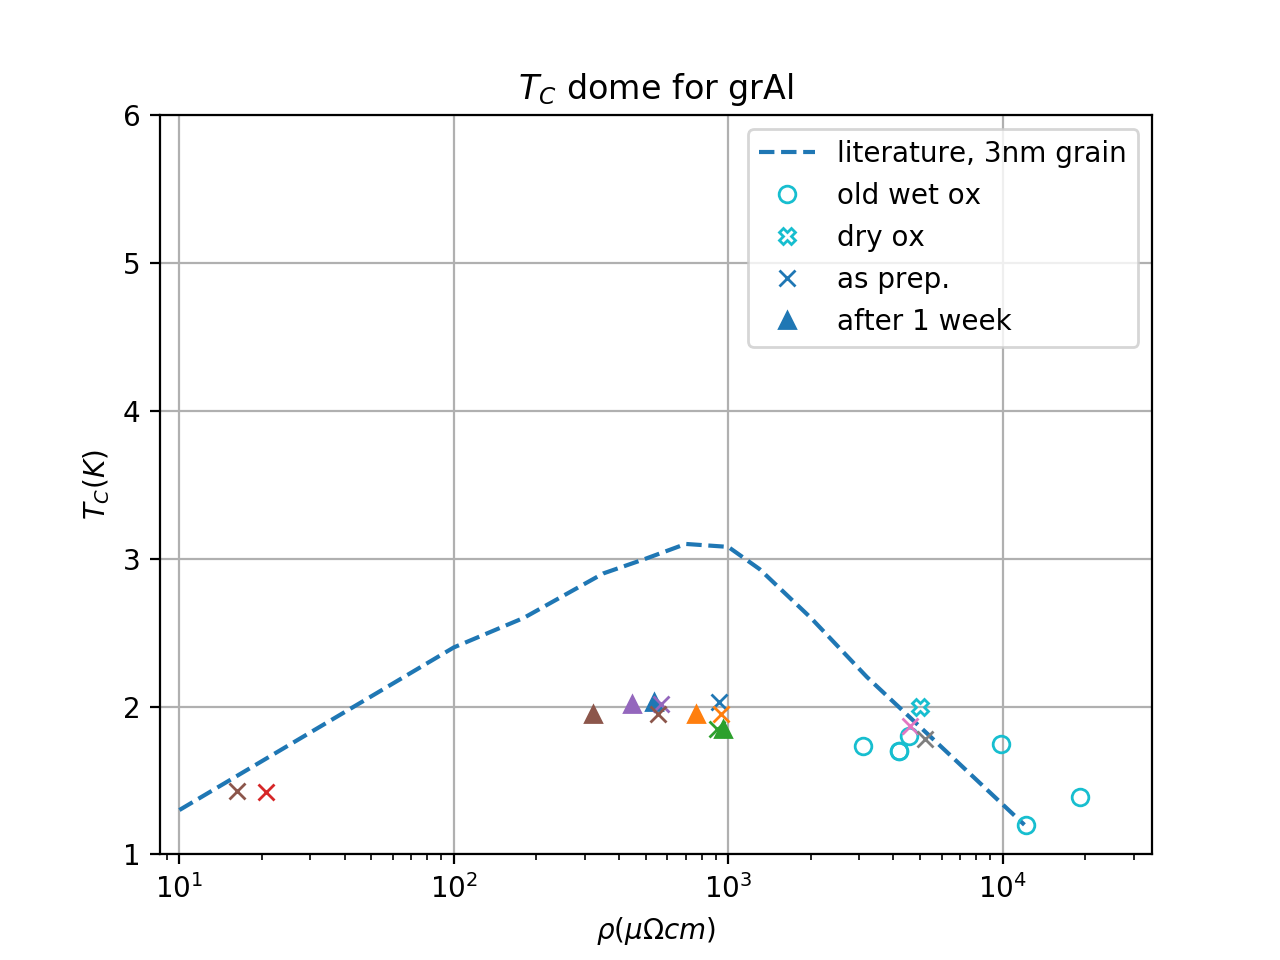

In [31]:
rho    = domeWetDF['$R$']     /domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_af = domeWetDF['$R_{af}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_1w = domeWetDF['$R_{1w}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']

plt.close('all')
f,ax=plt.subplots()
ax.plot(domeLitDF['$\\rho$']*1e8, domeLitDF['$T_C$'], '--', label = 'literature, 3nm grain')
ax.plot(rho[ 0: 7]*1e8, domeWetDF['$T_C$'][ 0: 7], 'o', fillstyle='none', label = 'old wet ox', color = 'C9')

ax.plot(5000, 2, 'X', fillstyle='none', label = 'dry ox', color = 'C9')

label = [['as prep.','after 1 week']]
for i,v in enumerate(range(8,len(domeWetDF))):#
    label.append([None,None])
    ax.plot(rho[v   ]*1e8,domeWetDF['$T_C$'][v], 'x', label = label[i][0], color='C{}'.format(int(i%9)))
    ax.plot(rho_1w[v]*1e8,domeWetDF['$T_C$'][v], '^', label = label[i][1], color='C{}'.format(int(i%9)))

# label = [['as prep.','af HIM/1 wk']]
# for i in range(8,23+1):
#     label.append([None,None])
#     ax.plot(rho[i]   *1e8, domeWetDF['$T_C$'][i]     , 'x', label = label[i-8][0], color = 'C{}'.format(int(i%9)))
#     ax.plot(rho_af[v]*1e8,domeWetDF['dose'][v], '.', label = label[i][1], color='C{}'.format(int(i%9)))    ax.plot(rho_1w[i]*1e8, domeWetDF['$T_{C,1w}$'][i], '^', label = label[i-8][1], color = 'C{}'.format(int(i%9)))

ax.set_xlim(8.5e-8*1e8,3.5e-4*1e8)
ax.set_ylim(1,6)
ax.set_xlabel('$\\rho (\mu\Omega cm)$')
ax.set_ylabel('$T_C (K)$')
ax.set_title('$T_C$ dome for grAl')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
# ax.ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))
plt.show()

#### <span class="mark">pure Al thin film quality</span>
"resistivity mean free path electron phonon aluminum"

<IPython.core.display.Javascript object>


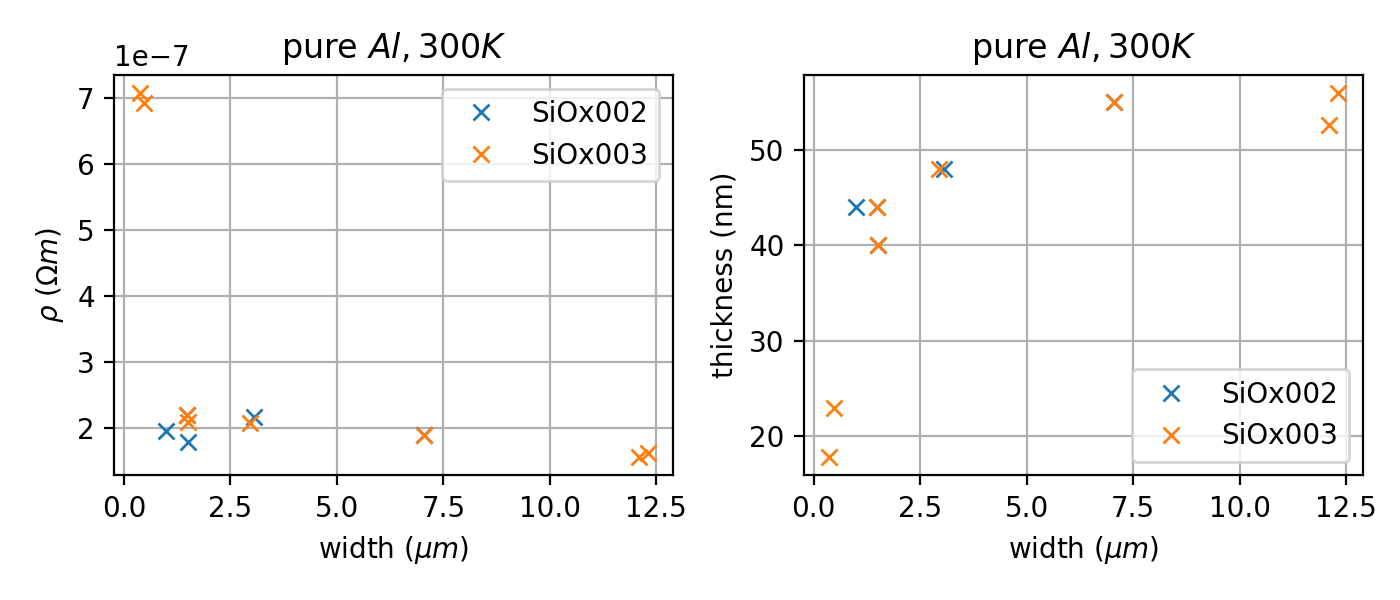

In [65]:
rho    = domeWetDF[16:]['$R$']     /domeWetDF[16:]['$l_{re}$']*domeWetDF[16:]['THK']*domeWetDF[16:]['$w_{re}$']
rho_1w = domeWetDF[16:]['$R_{1w}$']/domeWetDF[16:]['$l_{re}$']*domeWetDF[16:]['THK']*domeWetDF[16:]['$w_{re}$']
rho_af = domeWetDF[16:]['$R_{af}$']/domeWetDF[16:]['$l_{re}$']*domeWetDF[16:]['THK']*domeWetDF[16:]['$w_{re}$']

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

ax[0].plot(domeWetDF[16:26]['$w_{re}$']*1e6, rho[:10], 'x', label = 'SiOx002')
ax[0].plot(domeWetDF[26:36]['$w_{re}$']*1e6, rho[10:], 'x', label = 'SiOx003')
ax[0].ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))

ax[0].legend()
ax[0].set_xlabel('width ($\mu m$)')
ax[0].set_ylabel('$\\rho$ $(\Omega m)$')
ax[0].set_title('pure $Al, 300K$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

ax[1].plot(domeWetDF[16:26]['$w_{re}$']*1e6, domeWetDF[16:26]['THK']*1e9, 'x', label = 'SiOx002')
ax[1].plot(domeWetDF[26:36]['$w_{re}$']*1e6, domeWetDF[26:36]['THK']*1e9, 'x', label = 'SiOx003')
ax[1].ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))

ax[1].legend()
ax[1].set_xlabel('width ($\mu m$)')
ax[1].set_ylabel('thickness (nm)')
ax[1].set_title('pure $Al, 300K$')
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


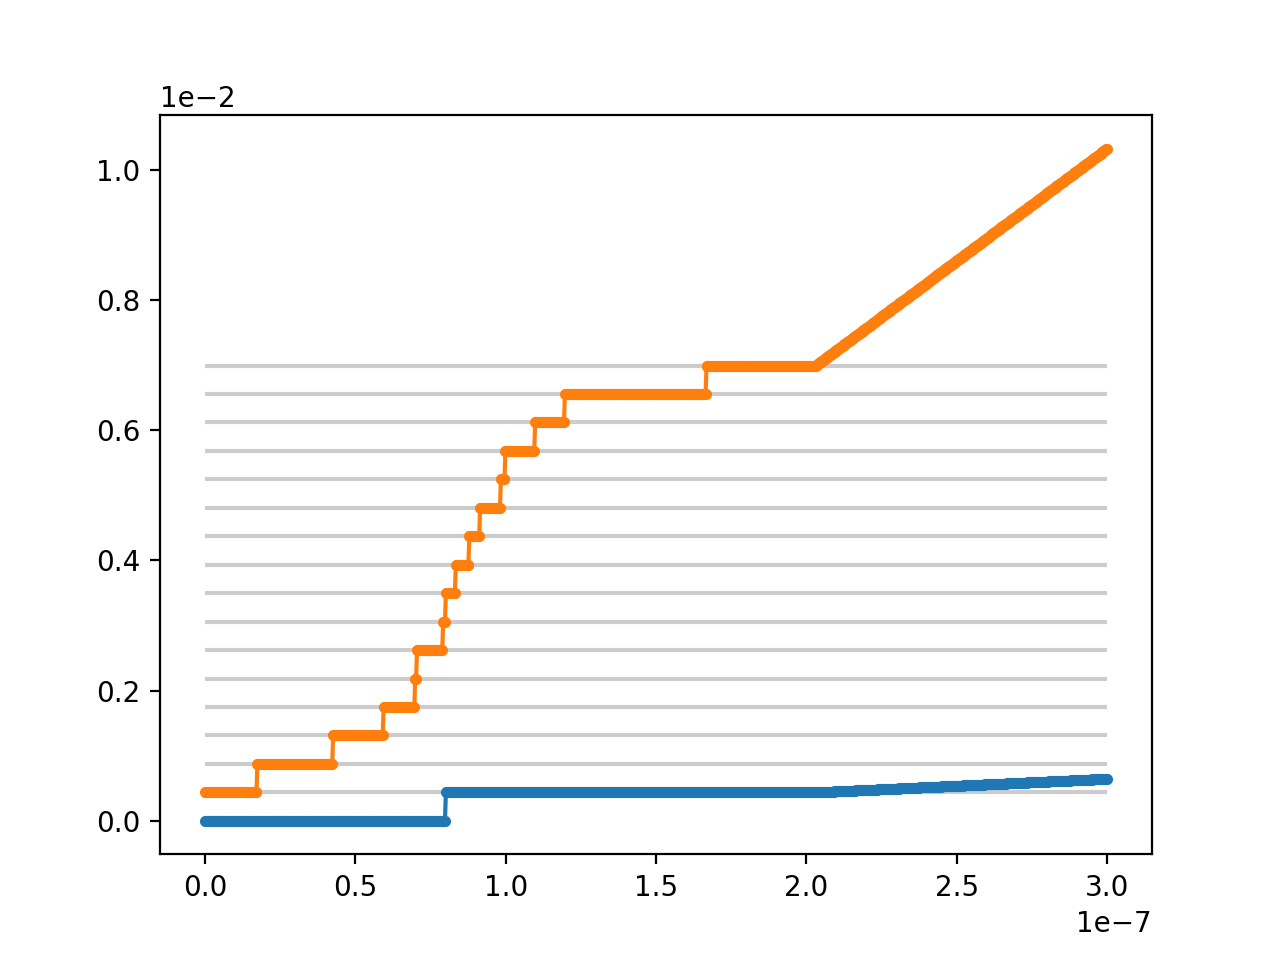

In [178]:
def IVcgen(Ic = 150e-9, IsM = 300e-9, RN = 2.15e3, gap = 437e-6):
    V = lambda I : (I)*RN
    Is = np.linspace(0, IsM, 1001)
    Vs = np.where(Ic < Is, np.where(gap/RN < Is, V(Is), gap), 0)
    return [Is,Vs]

plt.close('all')
f,ax = plt.subplots()

[Is,IVcttl] = IVcgen(Ic = 80e-9)
ax.plot(Is,IVcttl,'.',ls='-')

for i in np.random.normal(20e-9, 50e-9, 15)+30e-9:
    IVcttl = IVcttl + IVcgen(Ic = i)[1]
# for i in np.asarray([50,50,50,120])*1e-9:
#     IVcttl = IVcttl + IVcgen(Ic = i)[1]
    
ax.plot(Is,IVcttl,'.',ls='-')
for i in range(1,16+1):
    ax.hlines(i*437e-6,0,300e-9,alpha = 0.2)

ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
plt.show()

<IPython.core.display.Javascript object>


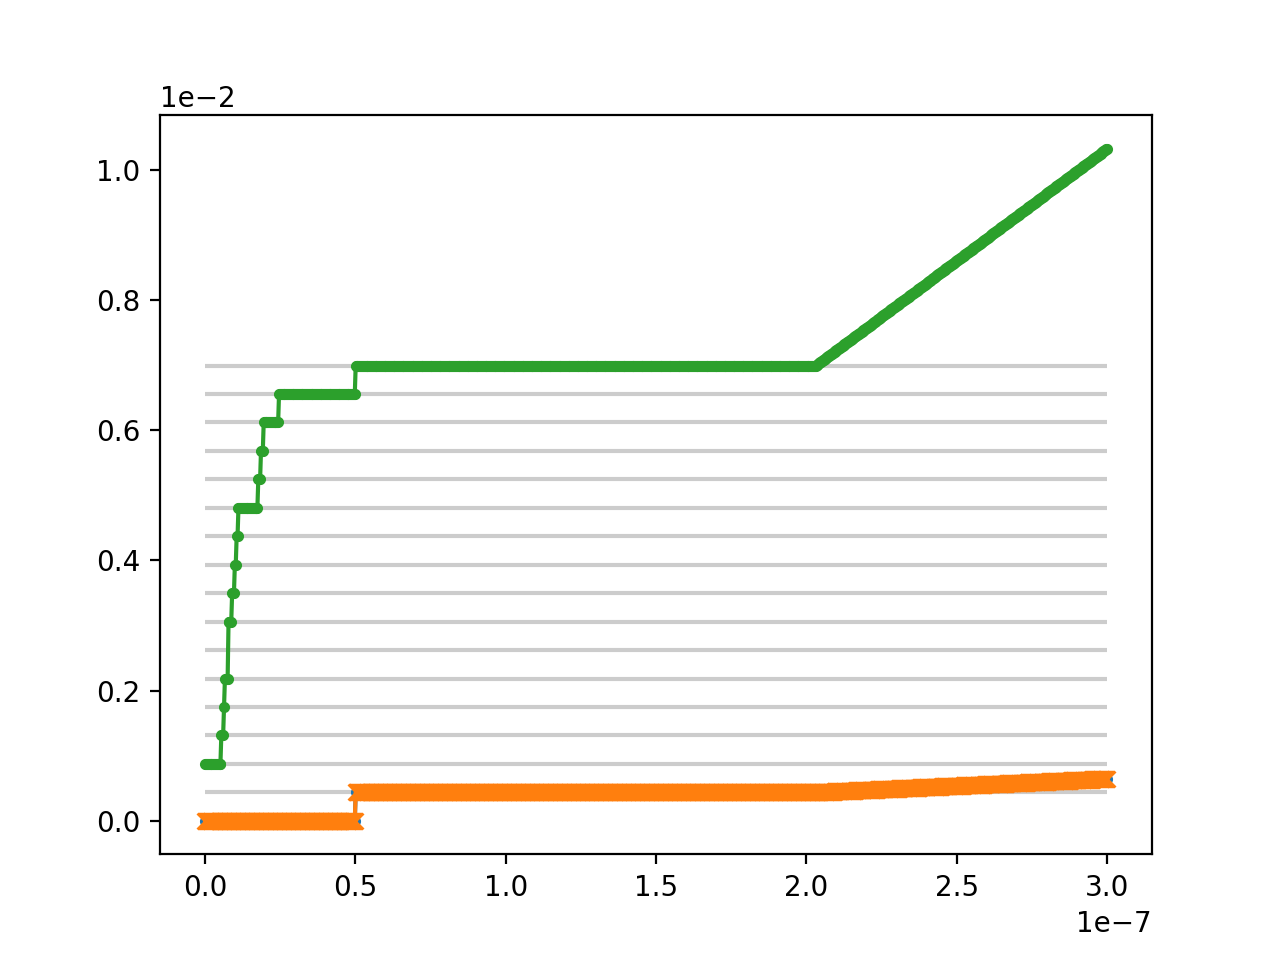

In [212]:
def IVcgen(Ic = 150e-9, dI = 0e-9, IsM = 300e-9, RN = 2.15e3, gap = 437e-6, V0 = 0):
    V = lambda I : (I+dI)*RN-V0
    Is = np.linspace(0, IsM, 1001)
    Vs = np.where(Ic < Is, np.where((gap-dI*RN+V0)/RN < Is, V(Is), gap), 0)
    return [Is,Vs]

plt.close('all')
f,ax = plt.subplots()

# [Is,IVcttl] = IVcgen(Ic = 150e-9, dI = 0.2*210e-9)
# ax.plot(Is,IVcttl,'.',ls='-')
[Is,IVcttl] = IVcgen(Ic = 50e-9, dI = 0e-9)
ax.plot(Is,IVcttl,'.',ls='-')

IVcttl1 = IVcttl
IVcttl2 = IVcttl

for i in np.random.normal(10e-9, 10e-9, 15)+0e-9:
#     IVcttl1 = IVcttl1 + IVcgen(Ic = i, dI = i)[1]
    IVcttl2 = IVcttl2 + IVcgen(Ic = i, dI = 0)[1]

ax.plot(Is,IVcttl1,'x',ls='-')
ax.plot(Is,IVcttl2,'.',ls='-')
for i in range(1,16+1):
    ax.hlines(i*437e-6,0,300e-9,alpha = 0.2)

ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
plt.show()

## Real products

### Fridge handling log

In [ ]:
# action = 'User: wsLu. Sample: {}. Roughing'.format(SAMPLE)
# action = 'ON Turbo @P1 = 6.47E-2'
# action = 'ON PT @P1 = 8.26E-4. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 3.51E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 1.89E-1'
# action = 'Start Pulse_PreCool @T8 = 11.56K'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [48, 3.7, 0.661, 0.030, 0.80]
# Tlst = ['dont care']
flow = '0.20'
stillOut = '0'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

# T8.get()

### Update RTc for T8>102K

Locate files "CH8 T dd-mm-yy.log" and "CH0 T dd-mm-yy.log" under below path:

C:\Users\KelvinOX25\Documents\GitHub\measDC

Copy them to below path:

\\SERIN135_DR-PC\BlueFors\Temperature Log\dd-mm-yy

Then run below two cells

In [272]:
import time, datetime

def getTt(rootpath, filedate = '21-11-19', Tch = 0):
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
    filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)

def fillDataGap(ref_x1, gapped_x2, gapped_y2):
    filled_y2 = np.full_like(np.arange(len(ref_x1)),np.nan, dtype=np.double)
    for i,v2 in enumerate(gapped_x2):
        for j,v1 in enumerate(ref_x1):
            vt1 = v1.year*525600 + v1.month*43800 + v1.day*1440 + v1.hour*60 + v1.minute
            vt2 = v2.year*525600 + v2.month*43800 + v2.day*1440 + v2.hour*60 + v2.minute
            if vt2 == vt1:
                filled_y2[j]= gapped_y2[i]
                break
    return filled_y2

<IPython.core.display.Javascript object>


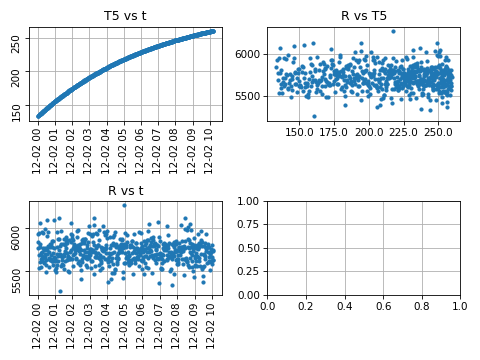

In [281]:
rootpath = r'\\SERIN135_DR-PC\BlueFors\Temperature Log'
filedate = '02-12-19'
Tch = 5
dhrslst1, dlst1, Tlst1 = getTt(rootpath=rootpath, filedate = filedate, Tch = Tch)
dhrslstR, dlstR, TlstR = getTt(rootpath=rootpath, filedate = filedate, Tch = 0)

TlstRnew = fillDataGap(ref_x1 = dlst1, gapped_x2 = dlstR, gapped_y2 = TlstR)
plt.close('all')
f,ax = plt.subplots(2,2)
ax[0][0].plot(dlst1,Tlst1,'.')
ax[0][0].set_title('T{} vs t'.format(Tch))
ax[0][0].tick_params(labelrotation=90)

ax[1][0].plot(dlstR,TlstR,'.')
ax[1][0].set_title('R vs t')
ax[1][0].tick_params(labelrotation=90)

ax[0][1].plot(Tlst1,TlstRnew,'.')
from matplotlib.ticker import FormatStrFormatter
ax[0][1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0][1].set_title('R vs T{}'.format(Tch))


for i in [0,1]:
    for j in [0,1]:
        ax[i][j].grid()

plt.tight_layout()
plt.show()

### Search I_SW segments

NameError: name 'filetoDFM' is not defined

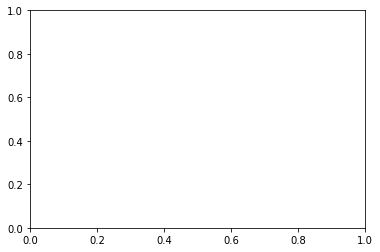

In [11]:
filepath = r'C:\Users\racco\Documents\2experimental log toolbox'

f,ax=plt.subplots()
dataLV = filetoDFM(filepath + r'\191104-70N3_IVc-115218.txt')
ax.plot(dataLV[0]['IS'],dataLV[0]['V1'], '.', ls='-',label = 'meas by LabVIEW')
ax.show()

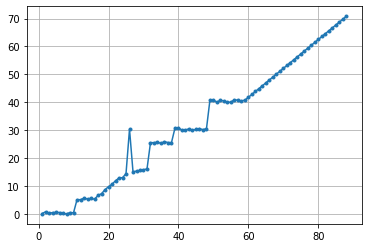

In [9]:
s = 10
lst = np.asarray([])
lsts = [np.random.rand(1,  s)                                 ,
        np.random.rand(1,  5) + 5                             ,
        np.random.rand(1,  s) + 5 + 1*np.linspace(0,s-1,s)    ,
        np.random.rand(1,  1) + s + s*2                       ,
        np.random.rand(1,  1) + s + 5 + 1*np.linspace(0, 1 ,5),
        np.random.rand(1,  7) + s + s*1.5                     ,
        np.random.rand(1, 10) + s + s*2                       ,
        np.random.rand(1, 10) + s + s*3                       ,
        np.random.rand(1,  1) + s*4   +30*np.linspace(0, 1 ,30) ]

for l in lsts:
    lst = np.append(lst, 1*l)

plt.plot(np.linspace(1,len(lst),len(lst)),lst,'.-')
plt.grid(True)
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataLV[0]['IS']
dataLV[0]['V1']
lstx = dataLV[0]['IS'].values.tolist()
lst = dataLV[0]['V1'].values.tolist()
datarngs = 0
datarnge = int(np.floor(1*len(lst)/4))
datarngs = int(np.floor(2*len(lst)/4))
datarnge = int(np.floor(3*len(lst)/4))
lstx = lstx[datarngs:datarnge]
lst = lst[datarngs:datarnge]


In [5]:
y_thr = 5.5e-3
y_jmp = 0.4e-3

lstd = np.flip(np.append(np.flip(np.diff(lst),0), lst[0]),0)
ids = np.array([])

for i,v in enumerate(lstd):
    if i <= len(lstd)-1 :
        if ((np.abs(v) >= y_jmp) and (np.abs(lstd[i+1]) <= y_jmp)) or (lst[i] >= y_thr):
            ids = np.append(ids, i)
            if lst[i] >= y_thr:
                break

ids = ids.astype(int)
lstNew = np.asarray([])

plt.close('all')
f,ax = plt.subplots()
ax.plot(lstx,lst,'-')
ax.grid(True)

ids = np.flip(np.append(np.flip(ids,0), 0),0)
for i,v in enumerate(ids):
    if i <= len(ids)-2:
        x =  lst[v:ids[i+1]]
        y =  lst[v:ids[i+1]]
        ax.plot(x,y,'.')

plt.show()

NameError: name 'lst' is not defined

### Copy image and show inline

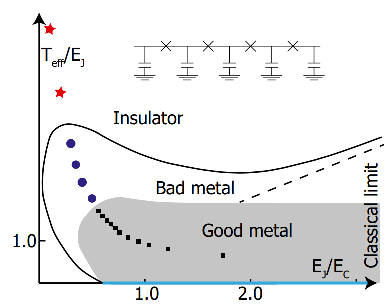

In [751]:
#This code saves the image sources in clipboard into png file and copy a short PY code back into clipboard to display the specific png file. 

import time, os
dir_path = os.getcwd()
pngpath = dir_path+"\\img\\{}{}{}-{}{}{}.png".format(time.localtime()[0]%100,
                                                     time.localtime()[1],
                                                     time.localtime()[2],
                                                     time.localtime()[3],
                                                     time.localtime()[4],
                                                     time.localtime()[5])

from PIL import ImageGrab
img = ImageGrab.grabclipboard()
img.save(pngpath, 'PNG')

resize = 2
from PIL import Image
try: 
    img = Image.open(pngpath) 
    width, height = img.size 
    img = img.resize((int(width/resize), int(height/resize))) 
    img.save(pngpath) 
except IOError: 
    pass

from IPython.display import Image, display
display(Image(filename=pngpath))

import clipboard
clipboard.copy('display(Image(filename=r\'{}\'))'.format(pngpath))
# display(Image(filename=r'C:\Users\racco\Documents\2experimental log toolbox\img\19113-124212.png'))

### Strip data strings from dry fridge logs

In [ ]:
import time, datetime

def getTt(filepath, Tch = 0):
    filedate = '21-11-19'
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
#     filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)

### Align data with gaps

In [4]:
def fillDataGap(ref_x1, gapped_x2, gapped_y2):
    filled_y2 = np.full_like(np.arange(len(ref_x1)),np.nan, dtype=np.double)
    for i,v2 in enumerate(gapped_x2):
        for j,v1 in enumerate(ref_x1):
#             vt1 = v1.year*525600 + v1.month*43800 + v1.day*1440 + v1.hour*60 + v1.minute
#             vt2 = v2.year*525600 + v2.month*43800 + v2.day*1440 + v2.hour*60 + v2.minute
            if v2 == v1:
                filled_y2[j]= gapped_y2[i]
                break
    return filled_y2

In [13]:
#x1 = np.linspace(1,20,20)
# y = x1+1

# x2 = np.append(np.linspace(1,10,10),(np.linspace(16,20,5)))
# z = 2*x2+1

x1 = np.linspace(1,200,200)
y1 = np.sin(x1/len(x1)*np.pi*2)

x2 = np.append(np.linspace(1,100,100),(np.linspace(151,200,50)))
y2 = np.cos(x2/len(x1)*np.pi*2)

y2new = fillDataGap(ref_x1 = x1, gapped_x2 = x2, gapped_y2 = y2)

<IPython.core.display.Javascript object>


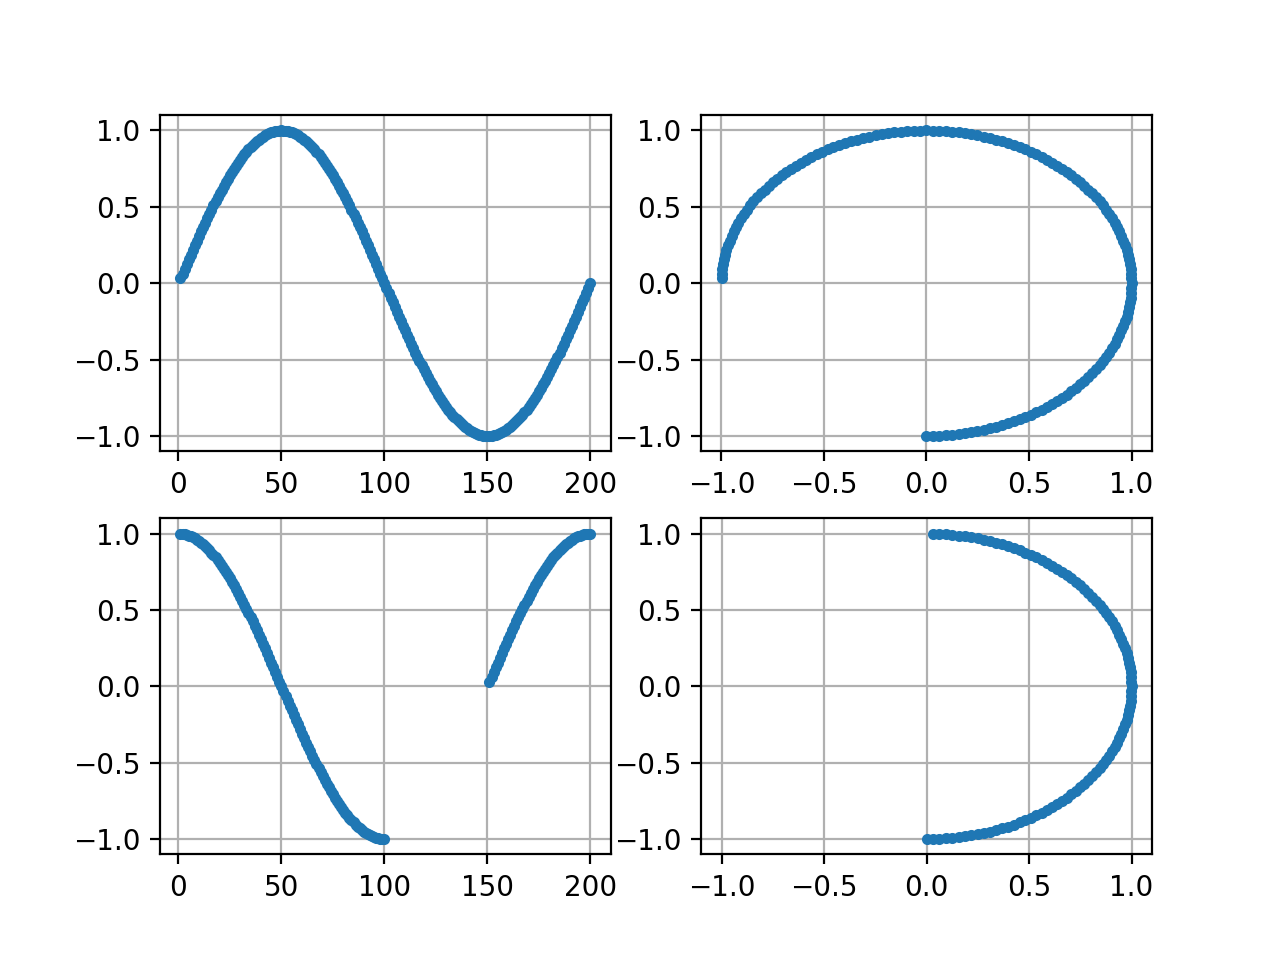

In [14]:
plt.close('all')
f,ax = plt.subplots(2,2)
ax[0][0].plot(x1,y1,'.')
ax[1][0].plot(x2,y2,'.')
ax[0][1].plot(y1,y2new,'.')
ax[1][1].plot(y1[0:100],y2[0:100],'.')

ax[1][1].set_xlim(-1.1,1.1)
ax[1][1].set_ylim(-1.1,1.1)
for i in [0,1]:
    for j in [0,1]:
        ax[i][j].grid()     
plt.show()

### Handle exception

In [144]:
for i in (domeWetDF['$R$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$'])[10:15]:
    try:
        print(si_format(i,4))
    except (ValueError,IOError) as err:
        print(err)

9.1000 µ
cannot convert float NaN to integer
5.6875 µ
5.5250 µ
111.7246 µ


### Log ids, data centering etc

In [3]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

pd.set_option("display.precision", 3)

In [29]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[              [8,9,10],  43e-3, np.array([ZF,midF,FF])              ,   4e-3, 'quick IVc meas'  ],  
       [                  [13],  43e-3, np.array([ZF,midF,FF])              ,  4e-3, ''                ],  
       [range(  22,   42+1)[:],  50e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  43,   63+1)[:], 100e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  64,   84+1)[:], 150e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  85,  105+1)[:], 200e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 106,  126+1)[:], 250e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 127,  147+1)[:], 300e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 148,  168+1)[:], 350e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 169,  189+1)[:], 400e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 190,  210+1)[:], 450e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 211,  231+1)[:], 500e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 232,  252+1)[:], 550e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 253,  262+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc_ada'],  
#        [range( 263,  272+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc'    ],  
       [range( 273,  282+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc'    ],    
       [range( 286,  336+1)[:],  43e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at Tbase'   ],    
       [range( 337,  387+1)[:],  75e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at  75mK'   ],    
       [range( 388,  438+1)[:], 125e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 125mK'   ],    
       [range( 439,  489+1)[:], 175e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 175mK'   ],    
       [range( 490,  540+1)[:], 225e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 225mK'   ],    
       [         [541,542,543],  44e-3, np.array([ZF,midF,FF])              ,   4e-3, 'IVcB,  no attn'  ],    
       [         [544,545,546],  44e-3, np.array([ZF,midF,FF])              ,   4e-3, 'IVcB, 10x attn'  ]]

ex74N4 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()
ex74N4.iloc[3]['ids']

range(43, 64)

<IPython.core.display.Javascript object>


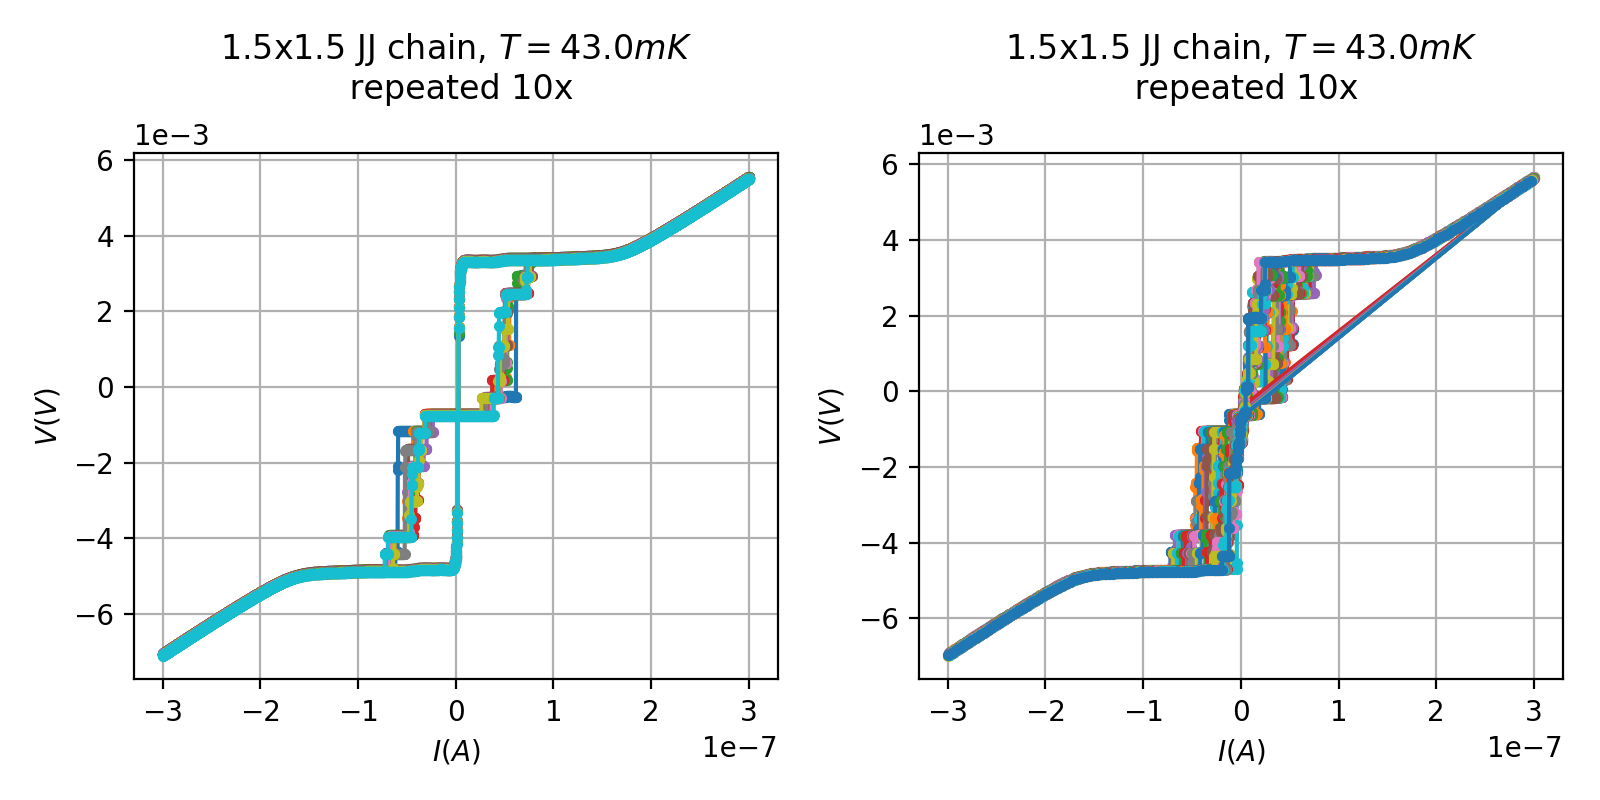

In [7]:
#demonstration about how to plot with multiple lists
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'C:\Users\racco\Documents\QCoDes\ExdData\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()

T = 43e-3
idlst = ex74N4[ex74N4['T'] == T]['ids'].tolist()[-2:]
for j,idl in enumerate(idlst):
    for i,v in enumerate(idl):
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']
        ax[j].plot(Is, Vs, '.',ls='-',label = '$T={}K$'.format(si_format(T)))#alpha=1-0.99*i ,  
        ax[j].set_xlabel('$I(A)$')
        ax[j].set_ylabel('$V(V)$')
        ax[j].set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
        ax[j].grid(True)
        ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


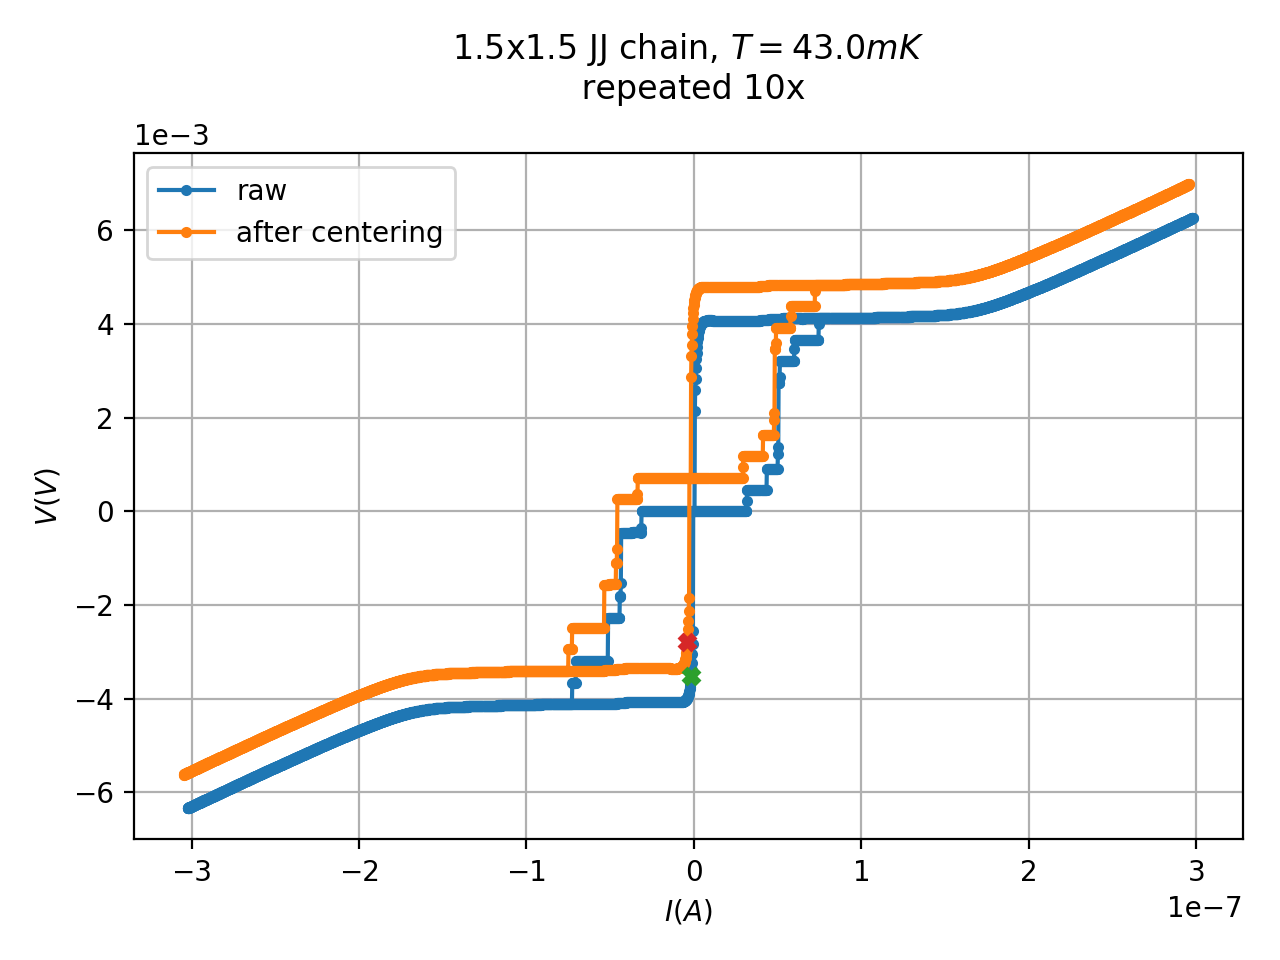

In [6]:
plt.close('all')
f,ax=plt.subplots()
# ax = ax.flatten()

T = 43e-3
for i,v in enumerate([275]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    
    Vs_off = (Vs[20]+Vs[int(len(Is)/2)])/2  
    Is_off = 2.25e-9
    Is_step= 2e-10
    Is = Is-Is_off
    Vs = Vs-(Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2
    
    ax.plot(Is, Vs, '.',ls='-',label = 'raw')
    ax.plot(Is-Is_off, Vs-Vs_off, '.',ls='-',label = 'after centering')
    ax.plot(Is[3], Vs[3], 'X')
    ax.plot(Is[3]-Is_off, Vs[3]-Vs_off, 'X')
    ax.set_xlabel('$I(A)$')
    ax.set_ylabel('$V(V)$')
    ax.set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
    ax.legend()
    ax.grid('true')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [192]:
def IVc_shift (Is, Vs, Is_off = 2.25e-9, Is_step= 2e-10):
    Is1 = Is-Is_off
    Vs1 = Vs-(Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2

    IVs = pd.DataFrame(data = list(zip(Is1,Vs1)), columns = ['Is', 'Vs'])
    
    ofsInd = int(np.floor(np.abs(IVs['Is'][0])/Is_step))+1
    IVs_shift = IVs.shift(periods=-1*ofsInd)
    IVs_shift = pd.concat([IVs_shift[:-1*ofsInd], IVs[0:ofsInd]], ignore_index=True)
    maxInd = IVs_shift[IVs_shift['Is'] == IVs_shift['Is'].max()].index[0]+1
    IVs_shift = pd.concat([IVs_shift[:3*maxInd], IVs_shift[-1*maxInd-1:]])
    return IVs_shift

<IPython.core.display.Javascript object>


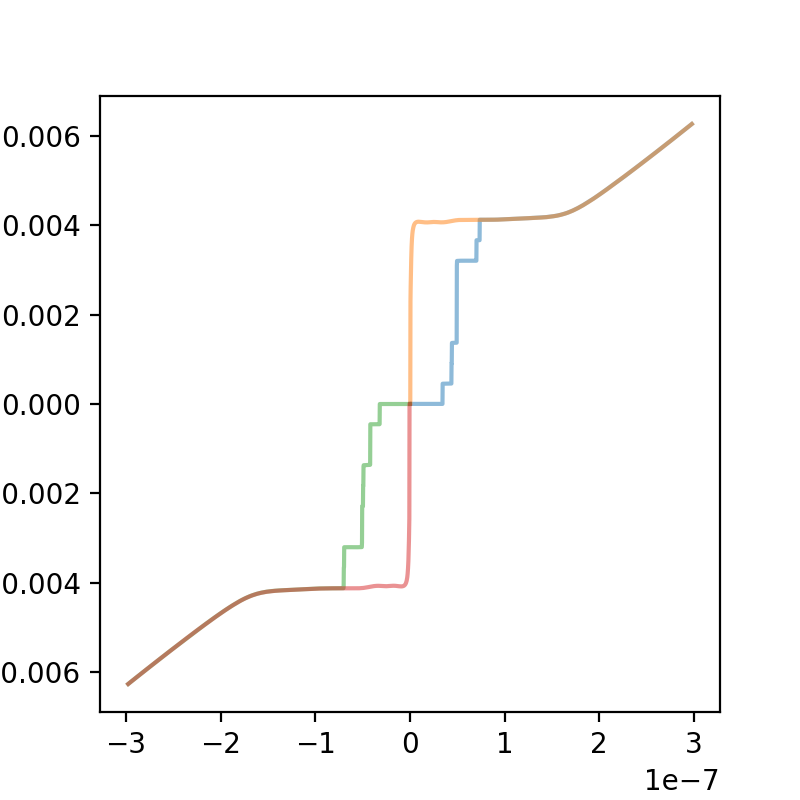

In [196]:
plt.close('all')
f,ax = plt.subplots(figsize=(4,4))

IVshift = IVc_shift(get_data_by_id(279)[0][0]['data'], 
                    get_data_by_id(279)[0][1]['data'],
                    Is_off = 2.25e-9, Is_step= 2e-10)

l = len(IVshift['Is'])

for i in [0,1,2,3]:
    ax.plot(IVshift['Is'][int(l*i/4):int(l*(i+1)/4)],
            IVshift['Vs'][int(l*i/4):int(l*(i+1)/4)],'-',alpha = 0.5)
plt.show()

### Fridge Handling

In [ ]:
key =  [ 'still',       'R','$w_{re}$','$l_{re}$',    'THK',      '$R_s$',    '$\\rho$', 'T_C']
unit=  [     'V','$\Omega$',       'm',       'm',     'm' ,'$\Omega$/sq', '$\Omega m$',   'K']
lst = [      
       [  10e-6 ,     2.91 ,  12.1e-6 ,  11.9e-6 , 52.6e-9 ,       2.959 ,  0.15564e-6 ,    0 ],
       [   1e-6 ,     159  ,   np.nan ,   np.nan ,   np.nan,      np.nan ,      np.nan ,    0 ],
      ]

thinAlDF = pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
thinAlun =   dict(zip(key, unit))

### AFM profile visualization

<IPython.core.display.Javascript object>


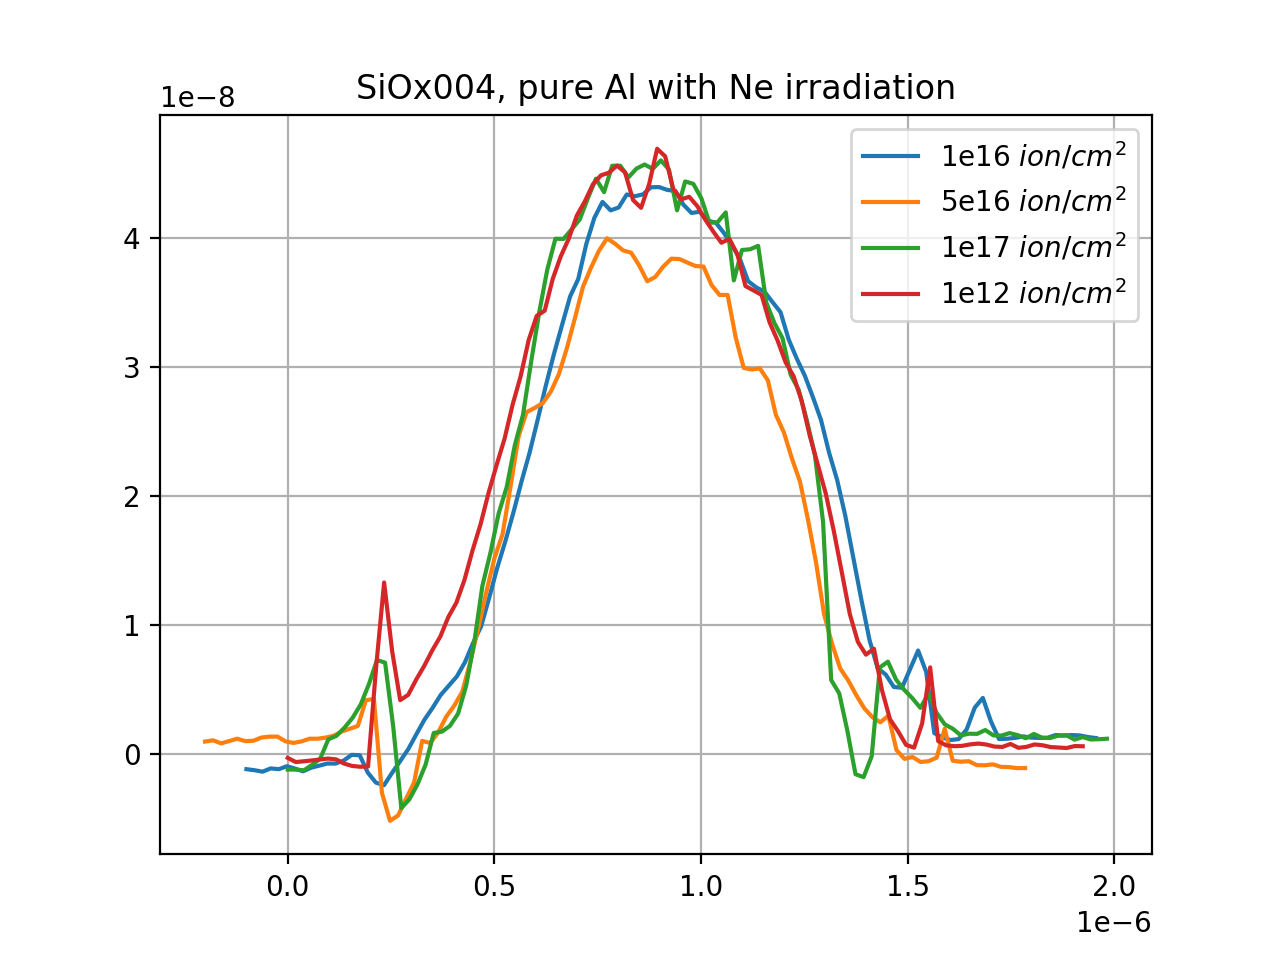

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [37]:
from os import listdir
from os.path import isfile, join
path = r'dataframes/SiOx004/'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

f,ax = plt.subplots()
shiftlst = [0.1e-6, 0.2e-6, 0e-6, 0e-6]
lbllst   = ['1e16', '5e16', '1e17', '1e12']
for i,l in enumerate(onlyfiles):
    with open(path+l,'r') as f:
        AFM = pd.read_csv(f,skiprows=1, delimiter = '  ',index_col = False)
        AFM = AFM.drop(AFM.index[0])
        AFM = AFM.astype(float)
    ax.plot(AFM.x-shiftlst[i],AFM.y-(AFM.y.iloc[1]+AFM.y.iloc[-1])/2, label = lbllst[i]+' $ion/cm^2$')
ax.set_title('SiOx004, pure Al with Ne irradiation')
ax.grid()
ax.legend()
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

### Data visualization

<IPython.core.display.Javascript object>


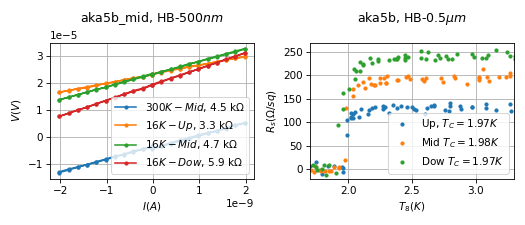

In [265]:
SAMPLE = 'aka5b' #1ab,3ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

# wid_des = 0.5e-6
# devW   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$w_{re}$'].mean()
# devL   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$l_{re}$'].mean()
# devTHK = thinAlDF[thinAlDF['$w_d$']==wid_des]['THK'].mean()

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelL = ['$300K-Mid$',
          '$16K-Up$',
          '$16K-Mid$',
          '$16K-Dow$']
for i,v in enumerate([21,25,24,26]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('{}_mid, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))


labelR = [#'from 300K',14,15,18,19
          'Up, $T_C = 1.97K$',
          'Mid $T_C = 1.98K$',
          'Dow $T_C = 1.97K$']
for i,v in enumerate([27,29,31]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].set_title('{}, HB-$0.5\mu m$'.format(SAMPLE), pad=20)
ax[1].set_ylim(-20,270)
ax[1].set_xlim(1.7,3.3)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


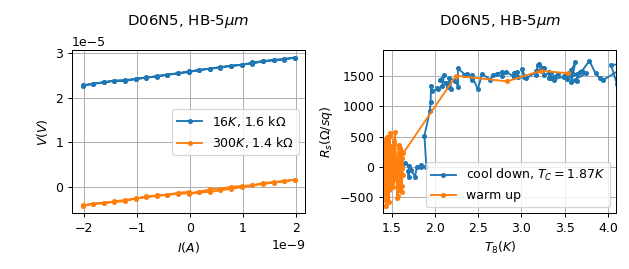

In [212]:
SAMPLE = 'D06N5' #9a7b,9b6a
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

wid_des = 5e-6
devW   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$w_{re}$'].mean()
devL   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$l_{re}$'].mean()
devTHK = thinAlDF[thinAlDF['$w_d$']==wid_des]['THK'].mean()

labelL = ['$16K$',
          '$300K$']
for i,v in enumerate([2,1]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('{}, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',14,15,18,19
          'cool down, $T_C = 1.87K$',
          'warm up',
          'from 300K']
factor = [1e9/2.2e6, # has R corrected due to incorrect R_bias setting when measured
          1]
for i,v in enumerate([3,4]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']*factor[i]
    Rs = R*devW/devL
    ax[1].plot(T, R, '.',ls='-', label = labelR[i])#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].set_title('{}, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
# ax[1].set_ylim(-100,3100)
ax[1].set_xlim(1.4,4.1)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


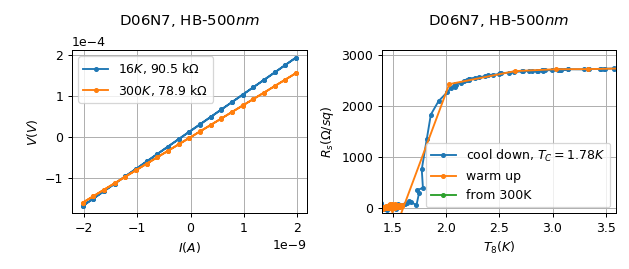

In [214]:
SAMPLE = 'D06N7' #12a11a,12b11b
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

wid_des = 0.5e-6
devW   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$w_{re}$'].mean()
devL   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$l_{re}$'].mean()
devTHK = thinAlDF[thinAlDF['$w_d$']==wid_des]['THK'].mean()

labelL = ['$16K$',
          '$300K$']
for i,v in enumerate([8,1]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('{}, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))


labelR = [#'from 300K',14,15,18,19
          'cool down, $T_C = 1.78K$',
          'warm up',
          'from 300K']
for i,v in enumerate([5,6,2]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.',ls='-', label = labelR[i])#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].set_title('{}, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
ax[1].set_ylim(-100,3100)
ax[1].set_xlim(1.4,3.6)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()